In [ ]:
!df -h

In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import random
import sklearn
from sklearn import metrics
import sklearn.model_selection
import datetime
import time
import os
import math
random.seed(1)
%matplotlib inline

In [ ]:
import multiprocessing as mp
mp.cpu_count()

In [ ]:
# import mine_concept
# import importlib
# from multiprocessing import Pool
# importlib.reload(mine_concept)

In [ ]:
DATA_FOLDER = 'GiveMeSomeCredit'
FILE_NAME = 'cs-training.csv'

In [ ]:
df = pd.read_csv(os.path.join(DATA_FOLDER, FILE_NAME), index_col=0)
df.head()
df.shape
df.dropna().shape

In [7]:
RANDOM_SEED = 42
SAMPLE_SIZE = 25000
TEST_SAMPLE_SIZE = 5000

df_sample = df.sample(SAMPLE_SIZE, random_state=RANDOM_SEED)

df_test = df_sample.sample(TEST_SAMPLE_SIZE, random_state=RANDOM_SEED)
df_train = df_sample.drop(df_test.index)
df_train_pos = df_train[df_train['SeriousDlqin2yrs']==1].drop('SeriousDlqin2yrs',axis=1)
df_train_neg = df_train[df_train['SeriousDlqin2yrs']==0].drop('SeriousDlqin2yrs',axis=1)
df_test_pos = df_test[df_test['SeriousDlqin2yrs']==1].drop('SeriousDlqin2yrs',axis=1)
df_test_neg = df_test[df_test['SeriousDlqin2yrs']==0].drop('SeriousDlqin2yrs',axis=1)

df_sample.isnull().sum()

SeriousDlqin2yrs                           0
RevolvingUtilizationOfUnsecuredLines       0
age                                        0
NumberOfTime30-59DaysPastDueNotWorse       0
DebtRatio                                  0
MonthlyIncome                           5038
NumberOfOpenCreditLinesAndLoans            0
NumberOfTimes90DaysLate                    0
NumberRealEstateLoansOrLines               0
NumberOfTime60-89DaysPastDueNotWorse       0
NumberOfDependents                       665
dtype: int64

In [8]:
df_train = df_train.drop('SeriousDlqin2yrs',axis=1)
df_test = df_test.drop('SeriousDlqin2yrs',axis=1)

In [9]:
X = df_sample.drop('SeriousDlqin2yrs', axis=1)
y = df_sample['SeriousDlqin2yrs']
X.shape

(25000, 10)

In [10]:
y_test = y[df_test.index].values
y_train = y[df_train.index].values

In [11]:
# import psutil
# psutil.virtual_memory()

In [12]:
df_train_pos.to_csv(os.path.join(DATA_FOLDER, 'df_train_pos.csv'))
df_train_neg.to_csv(os.path.join(DATA_FOLDER, 'df_train_neg.csv'))
df_test.to_csv(os.path.join(DATA_FOLDER, 'df_test.csv'))

In [13]:
df_train_pos = pd.read_csv(os.path.join(DATA_FOLDER, 'df_train_pos.csv'),index_col=0)
df_train_neg = pd.read_csv(os.path.join(DATA_FOLDER, 'df_train_neg.csv'),index_col=0)
df_test= pd.read_csv(os.path.join(DATA_FOLDER, 'df_test.csv'),index_col=0)

In [14]:
df_train_pos.head()

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
41981,1.000000,55,0,0.132852,4982.0,1,1,0,0,0.0
7488,0.419628,63,1,0.438756,10000.0,13,1,2,0,0.0
25706,0.147335,54,0,0.031626,3572.0,8,0,0,0,1.0
49307,0.762409,39,0,0.529434,2700.0,6,0,0,0,4.0
4891,0.000000,60,3,0.292697,6750.0,5,1,1,2,0.0


In [15]:
df_train_neg.shape

(18699, 10)

In [16]:
X_pos = df_train_pos.values
X_neg = df_train_neg.values
X_test = df_test.values
y_test_true = y[df_test.index].values

In [17]:
X_test.shape

(5000, 10)

#### ConceptMiner


In [79]:
def nunique_percol_sort(a):
    """Number of unique values in a row of array"""
    b = np.sort(a,axis=1)
    return (b[:,1:] != b[:,:-1]).sum(axis=1)+1

class PatternStructuresMiner():
    """
    Basic class to explore intersections of objects and build hypotheses
    """
    def __init__(self, data_pos, data_neg, feature_list):
        """
        :param data_pos: Pandas.DataFrame with objects from class 1
        :param data_neg: Pandas.DataFrame with objects from class 0
        :param feature_list: list of column names used as features
        """
        self.data_pos = data_pos[feature_list]
        self.data_neg = data_neg[feature_list]
        self.X_pos_expanded = np.expand_dims(self.data_pos.values, 0)
        self.X_neg_expanded = np.expand_dims(self.data_neg.values, 0)
        self.feature_list = feature_list
        self.is_nan_X_pos_expanded = np.isnan(self.X_pos_expanded)
        self.is_nan_X_neg_expanded = np.isnan(self.X_neg_expanded)
    
    def mine_obj_intersections(self, n_obj, subs_size, concepts_type):
        # np.random.choice is too slow
        print("Mining {} intersections".format(n_obj))
        data = self.data_pos if concepts_type == 'pos' else self.data_neg
        indexes = np.random.randint(0, data.shape[0], size=(n_obj, subs_size))

        # provide objects in subsamples are unique
        n_unique = nunique_percol_sort(indexes)
        indexes = indexes[n_unique == subs_size]
        
        # left & right borders of interval pattern structures
        concepts_min = np.expand_dims(np.nanmin(data.values[indexes], axis=1), 1)
        concepts_max = np.expand_dims(np.nanmax(data.values[indexes], axis=1), 1)

        # 
        num_neg_objs_in_concepts = ((((concepts_min <= self.X_neg_expanded) | np.isnan(concepts_min)) & 
                                    ((concepts_max >= self.X_neg_expanded) | np.isnan(concepts_max))) | 
                                    self.is_nan_X_neg_expanded).all(axis=2).sum(axis=1)
        num_pos_objs_in_concepts = ((((concepts_min <= self.X_pos_expanded) | np.isnan(concepts_min)) & 
                                    ((concepts_max >= self.X_pos_expanded) | np.isnan(concepts_max))) | 
                                    self.is_nan_X_pos_expanded).all(axis=2).sum(axis=1)
        
        # stats
        pos_support = num_pos_objs_in_concepts / self.data_pos.shape[0]
        neg_support = num_neg_objs_in_concepts / self.data_neg.shape[0]
        pos_confidence = num_pos_objs_in_concepts / (num_pos_objs_in_concepts + num_neg_objs_in_concepts) 
        neg_confidence = num_neg_objs_in_concepts / (num_pos_objs_in_concepts + num_neg_objs_in_concepts) 
        
#         print("Mining obj Finished")
        return concepts_min[:,0,:], concepts_max[:,0,:], \
                pd.DataFrame({'N_pos_in_concepts':num_pos_objs_in_concepts,
                              'N_neg_in_concepts':num_neg_objs_in_concepts,
                              'concepts_type':[concepts_type]*num_pos_objs_in_concepts.shape[0],
                              'subs_size':[subs_size]*num_pos_objs_in_concepts.shape[0],
                              'N_pos_all':[self.data_pos.shape[0]]*num_pos_objs_in_concepts.shape[0],
                              'N_neg_all':[self.data_neg.shape[0]]*num_pos_objs_in_concepts.shape[0],
                              'pos_support' : pos_support,
                              'neg_support' : neg_support,
                              'pos_confidence' : pos_confidence,
                              'neg_confidence' : neg_confidence
                               })
    
    
    def mine_hypotheses(self, alpha, hypo_type, subs_size,
                      N_hypo_need = None, N_iterations = None, batch_size = 1000, save_path = None):
        N_mined_hypo = 0
        hypotheses_min_LIST = []
        hypotheses_max_LIST = []
        iter_total = 0
        
        while N_mined_hypo < N_hypo_need:
            concepts_min, concepts_max, stats_concepts = self.mine_obj_intersections(batch_size, subs_size, hypo_type)
            good_hypos_idxs = stats_concepts.query(hypo_type + "_confidence >= " + str(alpha)).index
            hypotheses_min_LIST.append(concepts_min[good_hypos_idxs])
            hypotheses_max_LIST.append(concepts_max[good_hypos_idxs])
            N_mined_hypo += good_hypos_idxs.shape[0]
            print("N_mined_hypos of type " + hypo_type, N_mined_hypo)
            iter_total += batch_size
            if N_iterations and iter_total >= N_iterations:
                break
            
        hypotheses_min = np.concatenate(hypotheses_min_LIST)
        hypotheses_max = np.concatenate(hypotheses_max_LIST)
        if N_hypo_need:
            hypotheses_min = hypotheses_min[:N_hypo_need]
            hypotheses_max = hypotheses_max[:N_hypo_need]
        
        if save_path:
            pd.DataFrame(hypotheses_min).to_csv(os.path.join(save_path, "hypotheses_min.csv"), header=None, index=None)
            pd.DataFrame(hypotheses_max).to_csv(os.path.join(save_path, "hypotheses_max.csv"), header=None, index=None)
        
        return hypotheses_min, hypotheses_max
        


In [80]:
features = ['RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents']

In [81]:
%%time
PSM = PatternStructuresMiner(df_train_pos, df_train_neg, features)

CPU times: user 5.98 ms, sys: 0 ns, total: 5.98 ms
Wall time: 4.62 ms


In [82]:
# %%time
# _, _, stats_concepts_pos = PSM.mine_obj_intersections(10000, 3, 'pos')
# _, _, stats_concepts_neg = PSM.mine_obj_intersections(10000, 3, 'neg')

In [83]:
# import shutil
# folder = os.path.join(DATA_FOLDER,'Hypotheses')
# shutil.rmtree(folder)
# os.mkdir(folder)

### Mine positive hypotheses

Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:36: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal


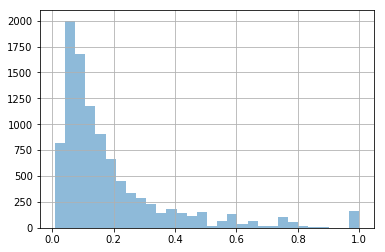

In [86]:
_, _, stats_concepts_pos = PSM.mine_obj_intersections(10000, 3, 'pos')
stats_concepts_pos['pos_confidence'].hist(alpha = 0.5, bins = 30)

In [35]:
%%time
from sklearn.model_selection import ParameterGrid
import multiprocessing

param_grid = {
    'subs_size': list(range(2,12)),
    'alpha': np.linspace(0,1,51), 
    'hypo_type' : ['pos'],
    'N_hypo_need' : [2000],
    'N_iterations' : [400000],
    'batch_size' : [10000],
}

### WARNING! round(params['alpha'], 4) ---> for readable folder names
MyParamGrid = []
for params in ParameterGrid(param_grid):
    save_path = os.path.join(DATA_FOLDER, 
                             'Hypotheses',
                             params['hypo_type'] + '_' + 
                             str(params['subs_size']) + '_' + 
                             str(round(params['alpha'], 4)))
    if not os.path.exists(save_path):
        os.mkdir(save_path)
    params['save_path'] = save_path
    MyParamGrid.append(params)


pool = multiprocessing.Pool(processes=50) #use all available cores, otherwise specify the number you want as an argument
for args in MyParamGrid:
    pool.apply_async(PSM.mine_hypotheses, args=(args['alpha'],
                                                args['hypo_type'],
                                                args['subs_size'],
                                                args['N_hypo_need'],
                                                args['N_iterations'],
                                                args['batch_size'],
                                                args['save_path'],
                                               ))
pool.close()
pool.join()

Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:36: RuntimeWarning: All-NaN slice encountered


Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:36: RuntimeWarning: All-NaN slice encountered


Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:36: RuntimeWarning: All-NaN slice encountered


Mining 10000 intersections
Mining 10000 intersections
Mining 10000 intersections
Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:36: RuntimeWarning: All-NaN slice encountered


Mining 10000 intersections
Mining 10000 intersections
Mining 10000 intersections
Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:36: RuntimeWarning: All-NaN slice encountered


Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:36: RuntimeWarning: All-NaN slice encountered


Mining 10000 intersections
Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN slice encountered


Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:36: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN slice encountered


Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:36: RuntimeWarning: All-NaN slice encountered


Mining 10000 intersections
Mining 10000 intersections
Mining 10000 intersections
Mining 10000 intersections
Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:36: RuntimeWarning: All-NaN slice encountered


Mining 10000 intersections
Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:36: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN slice encountered


Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:36: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN slice encountered


Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:36: RuntimeWarning: All-NaN slice encountered


Mining 10000 intersections
Mining 10000 intersections
Mining 10000 intersections
Mining 10000 intersections
Mining 10000 intersections
Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:36: RuntimeWarning: All-NaN slice encountered


Mining 10000 intersections
Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN slice encountered


Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:36: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN slice encountered


Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:36: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:36: RuntimeWarning: All-NaN slice encountered


Mining 10000 intersections
Mining 10000 intersections
Mining 10000 intersections
Mining 10000 intersections
Mining 10000 intersections
Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:36: RuntimeWarning: All-NaN slice encountered


Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN slice encountered


Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:36: RuntimeWarning: All-NaN slice encountered


Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:36: RuntimeWarning: All-NaN slice encountered


Mining 10000 intersections
Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:36: RuntimeWarning: All-NaN slice encountered


Mining 10000 intersections
Mining 10000 intersections
Mining 10000 intersections
Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_

/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/sit

N_mined_hypos of type pos 9982
Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less_equal


N_mined_hypos of type pos 9655


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less_equal


N_mined_hypos of type pos 9492
Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN slice encountered


Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:36: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:36: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal


N_mined_hypos of type pos 9838


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less_equal


Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:36: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWa

N_mined_hypos of type pos 9561


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less_equal


Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal


N_mined_hypos of type pos 8963
N_mined_hypos of type pos 9726


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less_equal


N_mined_hypos of type pos 9883


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal


Mining 10000 intersections
Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less_equal


Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/i

N_mined_hypos of type pos 9900
N_mined_hypos of type pos 9677
N_mined_hypos of type pos 9777
N_mined_hypos of type pos 9933
Mining 10000 intersections
N_mined_hypos of type pos 9655
Mining 10000 intersections
Mining 10000 intersections
Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:36: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal


N_mined_hypos of type pos 9592
Mining 10000 intersections
N_mined_hypos of type pos 9994


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:36: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal


Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN slice encountered


Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:36: RuntimeWarning: All-NaN slice encountered


N_mined_hypos of type pos 3987


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less_equal


N_mined_hypos of type pos 9592


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal


Mining 10000 intersections
Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less_equal


N_mined_hypos of type pos 4610
N_mined_hypos of type pos 9777


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less_equal


Mining 10000 intersections
N_mined_hypos of type pos 9925
Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal


N_mined_hypos of type pos 9525
Mining 10000 intersections
Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:36: RuntimeWarning: All-NaN slice encountered


N_mined_hypos of type pos 9519
N_mined_hypos of type pos 9200


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal


Mining 10000 intersections
Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:36: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:42: Runtim

N_mined_hypos of type pos 7351


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less_equal


Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less_equal


N_mined_hypos of type pos 6760


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal


N_mined_hypos of type pos 7203
N_mined_hypos of type pos 9959


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal


Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal


N_mined_hypos of type pos 7245
Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less_equal


Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal


Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal


N_mined_hypos of type pos 4220
N_mined_hypos of type pos 9726
Mining 10000 intersections
N_mined_hypos of type pos 9132
Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal


Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal


N_mined_hypos of type pos 9348


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal


N_mined_hypos of type pos 5160


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal


N_mined_hypos of type pos 7205
Mining 10000 intersections
Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less_equal


Mining 10000 intersections
N_mined_hypos of type pos 7213
N_mined_hypos of type pos 9900


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal


N_mined_hypos of type pos 9913
Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:36: RuntimeWarning: All-NaN slice encountered


Mining 10000 intersections
Mining 10000 intersections
N_mined_hypos of type pos 7981
N_mined_hypos of type pos 7199


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal


N_mined_hypos of type pos 4380
Mining 10000 intersections
N_mined_hypos of type pos 3781
Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less_equal


N_mined_hypos of type pos 9408


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal


N_mined_hypos of type pos 9297
N_mined_hypos of type pos 9881
Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal


N_mined_hypos of type pos 9836


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal


Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:36: RuntimeWarning: All-NaN slice encountered


Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN slice encountered


Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:36: RuntimeWarning: All-NaN slice encountered


Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:36: RuntimeWarning: All-NaN slice encountered


Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal


N_mined_hypos of type pos 7216
N_mined_hypos of type pos 7232
Mining 10000 intersections
Mining 10000 intersections
N_mined_hypos of type pos 9537
Mining 10000 intersections
N_mined_hypos of type pos 5660
N_mined_hypos of type pos 4891
Mining 10000 intersections
Mining 10000 intersections
N_mined_hypos of type pos 8578
Mining 10000 intersections
N_mined_hypos of type pos 5748
Mining 10000 intersections
N_mined_hypos of type pos 3702
Mining 10000 intersections
N_mined_hypos of type pos 4936
N_mined_hypos of type pos 1014
Mining 10000 intersections
Mining 10000 intersections
N_mined_hypos of type pos 1805
N_mined_hypos of type pos 1335
Mining 10000 intersections
Mining 10000 intersections
N_mined_hypos of type pos 8206
N_mined_hypos of type pos 663
Mining 10000 intersections
Mining 10000 intersections
N_mined_hypos of type pos 226
Mining 10000 intersections
N_mined_hypos of type pos 7459
Mining 10000 intersections
N_mined_hypos of type pos 462
Mining 10000 intersections
N_mined_hypos of 

/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN slice encountered


N_mined_hypos of type pos 7987
Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:36: RuntimeWarning: All-NaN slice encountered


N_mined_hypos of type pos 1481
Mining 10000 intersections
N_mined_hypos of type pos 500
Mining 10000 intersections
Mining 10000 intersections
N_mined_hypos of type pos 2594
Mining 10000 intersections
N_mined_hypos of type pos 1829
Mining 10000 intersections
N_mined_hypos of type pos 1973
Mining 10000 intersections
N_mined_hypos of type pos 2147
Mining 10000 intersections
N_mined_hypos of type pos 1109
Mining 10000 intersections
N_mined_hypos of type pos 3299
Mining 10000 intersections
N_mined_hypos of type pos 321
Mining 10000 intersections
N_mined_hypos of type pos 3659
Mining 10000 intersections
N_mined_hypos of type pos 804
Mining 10000 intersections
N_mined_hypos of type pos 1230
Mining 10000 intersections
N_mined_hypos of type pos 3219
N_mined_hypos of type pos 208
Mining 10000 intersections
Mining 10000 intersections
N_mined_hypos of type pos 837
Mining 10000 intersections
N_mined_hypos of type pos 2576
Mining 10000 intersections
N_mined_hypos of type pos 1539
Mining 10000 inters

/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:36: RuntimeWarning: All-NaN slice encountered


N_mined_hypos of type pos 3522
Mining 10000 intersections
N_mined_hypos of type pos 610
Mining 10000 intersections
N_mined_hypos of type pos 7270
Mining 10000 intersections
N_mined_hypos of type pos 455
Mining 10000 intersections
N_mined_hypos of type pos 1008
Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:36: RuntimeWarning: All-NaN slice encountered


N_mined_hypos of type pos 139
Mining 10000 intersections
N_mined_hypos of type pos 1184
Mining 10000 intersections
N_mined_hypos of type pos 886
Mining 10000 intersections
N_mined_hypos of type pos 297
Mining 10000 intersections
N_mined_hypos of type pos 188
Mining 10000 intersections
N_mined_hypos of type pos 1975
Mining 10000 intersections
N_mined_hypos of type pos 94
Mining 10000 intersections
N_mined_hypos of type pos 1629
Mining 10000 intersections
N_mined_hypos of type pos 7100
Mining 10000 intersections
N_mined_hypos of type pos 33
Mining 10000 intersections
N_mined_hypos of type pos 356
Mining 10000 intersections
N_mined_hypos of type pos 1341
Mining 10000 intersections
N_mined_hypos of type pos 3972
Mining 10000 intersections
N_mined_hypos of type pos 112
Mining 10000 intersections
N_mined_hypos of type pos 3613
N_mined_hypos of type pos 2451
Mining 10000 intersections
Mining 10000 intersections
N_mined_hypos of type pos 410
Mining 10000 intersections
N_mined_hypos of type pos

/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:36: RuntimeWarning: All-NaN slice encountered


N_mined_hypos of type pos 940
Mining 10000 intersections
N_mined_hypos of type pos 1651
Mining 10000 intersections
N_mined_hypos of type pos 3037
Mining 10000 intersections
N_mined_hypos of type pos 2103
N_mined_hypos of type pos 31
Mining 10000 intersections
Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:36: RuntimeWarning: All-NaN slice encountered


N_mined_hypos of type pos 295
Mining 10000 intersections
N_mined_hypos of type pos 192
Mining 10000 intersections
N_mined_hypos of type pos 41
Mining 10000 intersections
N_mined_hypos of type pos 11
Mining 10000 intersections
N_mined_hypos of type pos 1092
Mining 10000 intersections
N_mined_hypos of type pos 425
Mining 10000 intersections
N_mined_hypos of type pos 168
Mining 10000 intersections
N_mined_hypos of type pos 853
Mining 10000 intersections
N_mined_hypos of type pos 4
Mining 10000 intersections
N_mined_hypos of type pos 2741
Mining 10000 intersections
N_mined_hypos of type pos 1676
Mining 10000 intersections
N_mined_hypos of type pos 106
Mining 10000 intersections
N_mined_hypos of type pos 6877
Mining 10000 intersections
N_mined_hypos of type pos 771
Mining 10000 intersections
N_mined_hypos of type pos 680
Mining 10000 intersections
N_mined_hypos of type pos 2195
Mining 10000 intersections
N_mined_hypos of type pos 289
Mining 10000 intersections
N_mined_hypos of type pos 376


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:36: RuntimeWarning: All-NaN slice encountered


N_mined_hypos of type pos 2003
Mining 10000 intersections
N_mined_hypos of type pos 223
Mining 10000 intersections
N_mined_hypos of type pos 817
Mining 10000 intersections
N_mined_hypos of type pos 222
Mining 10000 intersections
N_mined_hypos of type pos 2452
Mining 10000 intersections
N_mined_hypos of type pos 34
Mining 10000 intersections
N_mined_hypos of type pos 957
Mining 10000 intersections
N_mined_hypos of type pos 2427
Mining 10000 intersections
N_mined_hypos of type pos 50
Mining 10000 intersections
N_mined_hypos of type pos 5
Mining 10000 intersections
N_mined_hypos of type pos 6626
Mining 10000 intersections
N_mined_hypos of type pos 62
Mining 10000 intersections
N_mined_hypos of type pos 14
Mining 10000 intersections
N_mined_hypos of type pos 71
Mining 10000 intersections
N_mined_hypos of type pos 140
Mining 10000 intersections
N_mined_hypos of type pos 955
Mining 10000 intersections
N_mined_hypos of type pos 72
Mining 10000 intersections
N_mined_hypos of type pos 1
Mining 

/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:36: RuntimeWarning: All-NaN slice encountered


N_mined_hypos of type pos 2233
Mining 10000 intersections
N_mined_hypos of type pos 38
Mining 10000 intersections
N_mined_hypos of type pos 335
Mining 10000 intersections
N_mined_hypos of type pos 1147
Mining 10000 intersections
N_mined_hypos of type pos 24
Mining 10000 intersections
N_mined_hypos of type pos 21
Mining 10000 intersections
N_mined_hypos of type pos 4
Mining 10000 intersections
N_mined_hypos of type pos 36
Mining 10000 intersections
N_mined_hypos of type pos 3639
Mining 10000 intersections
N_mined_hypos of type pos 1720
Mining 10000 intersections
N_mined_hypos of type pos 1628
Mining 10000 intersections
N_mined_hypos of type pos 766
Mining 10000 intersections
N_mined_hypos of type pos 312
Mining 10000 intersections
N_mined_hypos of type pos 878
Mining 10000 intersections
N_mined_hypos of type pos 1273
Mining 10000 intersections
N_mined_hypos of type pos 904
Mining 10000 intersections
N_mined_hypos of type pos 2219
Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:36: RuntimeWarning: All-NaN slice encountered


N_mined_hypos of type pos 152
Mining 10000 intersections
N_mined_hypos of type pos 4
Mining 10000 intersections
N_mined_hypos of type pos 92
Mining 10000 intersections
N_mined_hypos of type pos 2348
Mining 10000 intersections
N_mined_hypos of type pos 11
Mining 10000 intersections
N_mined_hypos of type pos 1592
Mining 10000 intersections
N_mined_hypos of type pos 428
Mining 10000 intersections
N_mined_hypos of type pos 1052
Mining 10000 intersections
N_mined_hypos of type pos 996
Mining 10000 intersections
N_mined_hypos of type pos 2
Mining 10000 intersections
N_mined_hypos of type pos 8
Mining 10000 intersections
N_mined_hypos of type pos 1584
Mining 10000 intersections
N_mined_hypos of type pos 674
Mining 10000 intersections
N_mined_hypos of type pos 16
Mining 10000 intersections
N_mined_hypos of type pos 254
Mining 10000 intersections
N_mined_hypos of type pos 410
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 38
Mining 10

Mining 10000 intersections
N_mined_hypos of type pos 637
Mining 10000 intersections
N_mined_hypos of type pos 61
Mining 10000 intersections
N_mined_hypos of type pos 1294
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 255
Mining 10000 intersections
N_mined_hypos of type pos 1400
Mining 10000 intersections
N_mined_hypos of type pos 150
Mining 10000 intersections
N_mined_hypos of type pos 1331
Mining 10000 intersections
N_mined_hypos of type pos 17
Mining 10000 intersections
N_mined_hypos of type pos 19
Mining 10000 intersections
N_mined_hypos of type pos 764
Mining 10000 intersections
N_mined_hypos of type pos 95
Mining 10000 intersections
N_mined_hypos of type pos 78
Mining 10000 intersections
N_mined_hypos of type pos 388
Mining 10000 intersections
N_mined_hypos of type pos 23
Mining 10000 intersections
N_mined_hypos of type pos 379
Mining 10000 intersections
N_mined_hypos of type pos 606
Mining 10000 intersections
N_mined_h

N_mined_hypos of type pos 58
Mining 10000 intersections
N_mined_hypos of type pos 76
Mining 10000 intersections
N_mined_hypos of type pos 1358
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 85
Mining 10000 intersections
N_mined_hypos of type pos 2
Mining 10000 intersections
N_mined_hypos of type pos 25
Mining 10000 intersections
N_mined_hypos of type pos 27
Mining 10000 intersections
N_mined_hypos of type pos 134
Mining 10000 intersections
N_mined_hypos of type pos 1937
Mining 10000 intersections
N_mined_hypos of type pos 657
Mining 10000 intersections
N_mined_hypos of type pos 36
Mining 10000 intersections
N_mined_hypos of type pos 241
Mining 10000 intersections
N_mined_hypos of type pos 1103
Mining 10000 intersections
N_mined_hypos of type pos 146
Mining 10000 intersections
N_mined_hypos of type pos 912
Mining 10000 intersections
N_mined_hypos of type pos 276
Mining 10000 intersections
N_mined_hypos of type pos 835
Mining 1

/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:36: RuntimeWarning: All-NaN slice encountered


N_mined_hypos of type pos 2188
Mining 10000 intersections
N_mined_hypos of type pos 1176
Mining 10000 intersections
N_mined_hypos of type pos 527
Mining 10000 intersections
N_mined_hypos of type pos 646
Mining 10000 intersections
N_mined_hypos of type pos 64
Mining 10000 intersections
N_mined_hypos of type pos 13
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 1968
Mining 10000 intersections
N_mined_hypos of type pos 80
Mining 10000 intersections
N_mined_hypos of type pos 1499
Mining 10000 intersections
N_mined_hypos of type pos 160
Mining 10000 intersections
N_mined_hypos of type pos 309
Mining 10000 intersections
N_mined_hypos of type pos 277
Mining 10000 intersections
N_mined_hypos of type pos 96
Mining 10000 intersections
N_mined_hypos of type pos 99
Mining 10000 intersections
N_mined_hypos of type pos 737
Mining 10000 intersections
N_mined_hypos of type pos 159
Mining 10000 intersections
N_mined_hypos of type pos 30
Minin

N_mined_hypos of type pos 1
Mining 10000 intersections
N_mined_hypos of type pos 13
Mining 10000 intersections
N_mined_hypos of type pos 394
Mining 10000 intersections
N_mined_hypos of type pos 78
Mining 10000 intersections
N_mined_hypos of type pos 6
Mining 10000 intersections
N_mined_hypos of type pos 1495
Mining 10000 intersections
N_mined_hypos of type pos 116
Mining 10000 intersections
N_mined_hypos of type pos 99
Mining 10000 intersections
N_mined_hypos of type pos 4
Mining 10000 intersections
N_mined_hypos of type pos 2040
Mining 10000 intersections
N_mined_hypos of type pos 495
Mining 10000 intersections
N_mined_hypos of type pos 769
Mining 10000 intersections
N_mined_hypos of type pos 17
Mining 10000 intersections
N_mined_hypos of type pos 1
Mining 10000 intersections
N_mined_hypos of type pos 385
Mining 10000 intersections
N_mined_hypos of type pos 288
Mining 10000 intersections
N_mined_hypos of type pos 962
Mining 10000 intersections
N_mined_hypos of type pos 68
Mining 10000

N_mined_hypos of type pos 1819
Mining 10000 intersections
N_mined_hypos of type pos 99
Mining 10000 intersections
N_mined_hypos of type pos 100
Mining 10000 intersections
N_mined_hypos of type pos 3
Mining 10000 intersections
N_mined_hypos of type pos 609
Mining 10000 intersections
N_mined_hypos of type pos 801
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 11
Mining 10000 intersections
N_mined_hypos of type pos 39
Mining 10000 intersections
N_mined_hypos of type pos 32
Mining 10000 intersections
N_mined_hypos of type pos 2
Mining 10000 intersections
N_mined_hypos of type pos 1245
Mining 10000 intersections
N_mined_hypos of type pos 6
Mining 10000 intersections
N_mined_hypos of type pos 116
Mining 10000 intersections
N_mined_hypos of type pos 19
Mining 10000 intersections
N_mined_hypos of type pos 21
Mining 10000 intersections
N_mined_hypos of type pos 359
Mining 10000 intersections
N_mined_hypos of type pos 139
Mining 10000 

N_mined_hypos of type pos 137
Mining 10000 intersections
N_mined_hypos of type pos 60
Mining 10000 intersections
N_mined_hypos of type pos 64
Mining 10000 intersections
N_mined_hypos of type pos 117
Mining 10000 intersections
N_mined_hypos of type pos 16
Mining 10000 intersections
N_mined_hypos of type pos 699
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 136
Mining 10000 intersections
N_mined_hypos of type pos 3
Mining 10000 intersections
N_mined_hypos of type pos 970
Mining 10000 intersections
N_mined_hypos of type pos 17
Mining 10000 intersections
N_mined_hypos of type pos 86
Mining 10000 intersections
N_mined_hypos of type pos 1756
Mining 10000 intersections
N_mined_hypos of type pos 491
Mining 10000 intersections
N_mined_hypos of type pos 954
Mining 10000 intersections
N_mined_hypos of type pos 22
Mining 10000 intersections
N_mined_hypos of type pos 1392
Mining 10000 intersections
N_mined_hypos of type pos 24
Mining 100

N_mined_hypos of type pos 23
Mining 10000 intersections
N_mined_hypos of type pos 297
Mining 10000 intersections
N_mined_hypos of type pos 258
Mining 10000 intersections
N_mined_hypos of type pos 667
N_mined_hypos of type pos 75
Mining 10000 intersections
Mining 10000 intersections
N_mined_hypos of type pos 153
Mining 10000 intersections
N_mined_hypos of type pos 2037
Mining 10000 intersections
N_mined_hypos of type pos 133
Mining 10000 intersections
N_mined_hypos of type pos 2
Mining 10000 intersections
N_mined_hypos of type pos 302
Mining 10000 intersections
N_mined_hypos of type pos 1132
Mining 10000 intersections
N_mined_hypos of type pos 5
Mining 10000 intersections
N_mined_hypos of type pos 185
Mining 10000 intersections
N_mined_hypos of type pos 1588
Mining 10000 intersections
N_mined_hypos of type pos 32
Mining 10000 intersections
N_mined_hypos of type pos 27
Mining 10000 intersections
N_mined_hypos of type pos 99
Mining 10000 intersections
N_mined_hypos of type pos 179
Mining 

N_mined_hypos of type pos 2077
Mining 10000 intersections
N_mined_hypos of type pos 1508
Mining 10000 intersections
N_mined_hypos of type pos 1783
Mining 10000 intersections
N_mined_hypos of type pos 1313
Mining 10000 intersections
N_mined_hypos of type pos 3
Mining 10000 intersections
N_mined_hypos of type pos 476
Mining 10000 intersections
N_mined_hypos of type pos 1272
Mining 10000 intersections
N_mined_hypos of type pos 33
Mining 10000 intersections
N_mined_hypos of type pos 1911
Mining 10000 intersections
N_mined_hypos of type pos 36
Mining 10000 intersections
N_mined_hypos of type pos 304
Mining 10000 intersections
N_mined_hypos of type pos 153
Mining 10000 intersections
N_mined_hypos of type pos 602
Mining 10000 intersections
N_mined_hypos of type pos 33
Mining 10000 intersections
N_mined_hypos of type pos 394
Mining 10000 intersections
N_mined_hypos of type pos 339
Mining 10000 intersections
N_mined_hypos of type pos 1295
Mining 10000 intersections
N_mined_hypos of type pos 30


Mining 10000 intersections
N_mined_hypos of type pos 87
Mining 10000 intersections
N_mined_hypos of type pos 7
Mining 10000 intersections
N_mined_hypos of type pos 3
Mining 10000 intersections
N_mined_hypos of type pos 3
Mining 10000 intersections
N_mined_hypos of type pos 413
Mining 10000 intersections
N_mined_hypos of type pos 172
Mining 10000 intersections
N_mined_hypos of type pos 535
Mining 10000 intersections
N_mined_hypos of type pos 63
Mining 10000 intersections
N_mined_hypos of type pos 80
Mining 10000 intersections
N_mined_hypos of type pos 4
Mining 10000 intersections
N_mined_hypos of type pos 661
Mining 10000 intersections
N_mined_hypos of type pos 1482
Mining 10000 intersections
N_mined_hypos of type pos 359
Mining 10000 intersections
N_mined_hypos of type pos 193
Mining 10000 intersections
N_mined_hypos of type pos 232
Mining 10000 intersections
N_mined_hypos of type pos 127
Mining 10000 intersections
N_mined_hypos of type pos 35
Mining 10000 intersections
N_mined_hypos o

/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:36: RuntimeWarning: All-NaN slice encountered


N_mined_hypos of type pos 680
Mining 10000 intersections
N_mined_hypos of type pos 1707
Mining 10000 intersections
N_mined_hypos of type pos 240
Mining 10000 intersections
N_mined_hypos of type pos 19
Mining 10000 intersections
N_mined_hypos of type pos 812
Mining 10000 intersections
N_mined_hypos of type pos 7
Mining 10000 intersections
N_mined_hypos of type pos 91
Mining 10000 intersections
N_mined_hypos of type pos 161
Mining 10000 intersections
N_mined_hypos of type pos 66
Mining 10000 intersections
N_mined_hypos of type pos 894
Mining 10000 intersections
N_mined_hypos of type pos 4
Mining 10000 intersections
N_mined_hypos of type pos 1521
Mining 10000 intersections
N_mined_hypos of type pos 1095
Mining 10000 intersections
N_mined_hypos of type pos 555
Mining 10000 intersections
N_mined_hypos of type pos 431
Mining 10000 intersections
N_mined_hypos of type pos 83
Mining 10000 intersections
N_mined_hypos of type pos 179
Mining 10000 intersections
N_mined_hypos of type pos 363
Mining

N_mined_hypos of type pos 16
Mining 10000 intersections
N_mined_hypos of type pos 2379
Mining 10000 intersections
N_mined_hypos of type pos 22
Mining 10000 intersections
N_mined_hypos of type pos 1927
Mining 10000 intersections
N_mined_hypos of type pos 1638
Mining 10000 intersections
N_mined_hypos of type pos 52
Mining 10000 intersections
N_mined_hypos of type pos 11
Mining 10000 intersections
N_mined_hypos of type pos 252
Mining 10000 intersections
N_mined_hypos of type pos 1
Mining 10000 intersections
N_mined_hypos of type pos 6
Mining 10000 intersections
N_mined_hypos of type pos 265
Mining 10000 intersections
N_mined_hypos of type pos 435
Mining 10000 intersections
N_mined_hypos of type pos 745
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 1073
Mining 10000 intersections
N_mined_hypos of type pos 197
Mining 10000 intersections
N_mined_hypos of type pos 38
Mining 10000 intersections
N_mined_hypos of type pos 582
Mining 1

N_mined_hypos of type pos 384
Mining 10000 intersections
N_mined_hypos of type pos 218
Mining 10000 intersections
N_mined_hypos of type pos 1817
Mining 10000 intersections
N_mined_hypos of type pos 64
Mining 10000 intersections
N_mined_hypos of type pos 289
Mining 10000 intersections
N_mined_hypos of type pos 8
Mining 10000 intersections
N_mined_hypos of type pos 4
Mining 10000 intersections
N_mined_hypos of type pos 661
Mining 10000 intersections
N_mined_hypos of type pos 1306
Mining 10000 intersections
N_mined_hypos of type pos 48
Mining 10000 intersections
N_mined_hypos of type pos 1828
Mining 10000 intersections
N_mined_hypos of type pos 437
Mining 10000 intersections
N_mined_hypos of type pos 63
Mining 10000 intersections
N_mined_hypos of type pos 273
Mining 10000 intersections
N_mined_hypos of type pos 217
Mining 10000 intersections
N_mined_hypos of type pos 42
N_mined_hypos of type pos 26
Mining 10000 intersections
Mining 10000 intersections
N_mined_hypos of type pos 42
Mining 1

Mining 10000 intersections
N_mined_hypos of type pos 54
Mining 10000 intersections
N_mined_hypos of type pos 45
Mining 10000 intersections
N_mined_hypos of type pos 1487
Mining 10000 intersections
N_mined_hypos of type pos 1139
Mining 10000 intersections
N_mined_hypos of type pos 117
Mining 10000 intersections
N_mined_hypos of type pos 244
Mining 10000 intersections
N_mined_hypos of type pos 719
Mining 10000 intersections
N_mined_hypos of type pos 5
Mining 10000 intersections
N_mined_hypos of type pos 1948
Mining 10000 intersections
N_mined_hypos of type pos 1978
Mining 10000 intersections
N_mined_hypos of type pos 720
Mining 10000 intersections
N_mined_hypos of type pos 514
Mining 10000 intersections
N_mined_hypos of type pos 472
Mining 10000 intersections
N_mined_hypos of type pos 31
Mining 10000 intersections
N_mined_hypos of type pos 877
Mining 10000 intersections
N_mined_hypos of type pos 301
Mining 10000 intersections
N_mined_hypos of type pos 1
Mining 10000 intersections
N_mined

Mining 10000 intersections
N_mined_hypos of type pos 196
Mining 10000 intersections
N_mined_hypos of type pos 1785
Mining 10000 intersections
N_mined_hypos of type pos 1
Mining 10000 intersections
N_mined_hypos of type pos 57
Mining 10000 intersections
N_mined_hypos of type pos 153
Mining 10000 intersections
N_mined_hypos of type pos 5
Mining 10000 intersections
N_mined_hypos of type pos 1101
N_mined_hypos of type pos 1042
Mining 10000 intersections
Mining 10000 intersections
N_mined_hypos of type pos 323
Mining 10000 intersections
N_mined_hypos of type pos 59
Mining 10000 intersections
N_mined_hypos of type pos 1226
Mining 10000 intersections
N_mined_hypos of type pos 1
Mining 10000 intersections
N_mined_hypos of type pos 70
Mining 10000 intersections
N_mined_hypos of type pos 641
Mining 10000 intersections
N_mined_hypos of type pos 779
Mining 10000 intersections
N_mined_hypos of type pos 268
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hyp

/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:36: RuntimeWarning: All-NaN slice encountered


N_mined_hypos of type pos 1658
Mining 10000 intersections
N_mined_hypos of type pos 578
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 170
Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:36: RuntimeWarning: All-NaN slice encountered


N_mined_hypos of type pos 1315
Mining 10000 intersections
N_mined_hypos of type pos 2
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 687
Mining 10000 intersections
N_mined_hypos of type pos 444
Mining 10000 intersections
N_mined_hypos of type pos 5362
Mining 10000 intersections
N_mined_hypos of type pos 14
Mining 10000 intersections
N_mined_hypos of type pos 6
Mining 10000 intersections
N_mined_hypos of type pos 193
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 6
Mining 10000 intersections
N_mined_hypos of type pos 592
Mining 10000 intersections
N_mined_hypos of type pos 210
Mining 10000 intersections
N_mined_hypos of type pos 11
Mining 10000 intersections
N_mined_hypos of type pos 1113
Mining 10000 intersections
N_mined_hypos of type pos 600
Mining 10000 intersections
N_mined_hypos of type pos 131
Mining 10000 intersections
N_mined_hypos of type pos 64
Mining 1000

/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:36: RuntimeWarning: All-NaN slice encountered


N_mined_hypos of type pos 1
Mining 10000 intersections
N_mined_hypos of type pos 1732
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 609
Mining 10000 intersections
N_mined_hypos of type pos 6
Mining 10000 intersections
N_mined_hypos of type pos 2
Mining 10000 intersections
N_mined_hypos of type pos 484
Mining 10000 intersections
N_mined_hypos of type pos 220
Mining 10000 intersections
N_mined_hypos of type pos 1146
Mining 10000 intersections
N_mined_hypos of type pos 316
Mining 10000 intersections
N_mined_hypos of type pos 1
Mining 10000 intersections
N_mined_hypos of type pos 102
Mining 10000 intersections
N_mined_hypos of type pos 1388
Mining 10000 intersections
N_mined_hypos of type pos 8
Mining 10000 intersections
N_mined_hypos of type pos 1
Mining 10000 intersections
N_mined_hypos of type pos 220
Mining 10000 intersections
N_mined_hypos of type pos 82
Mining 10000 intersections
N_mined_hypos of type pos 70
Mining 10000 i

N_mined_hypos of type pos 1
Mining 10000 intersections
N_mined_hypos of type pos 2
Mining 10000 intersections
N_mined_hypos of type pos 10
Mining 10000 intersections
N_mined_hypos of type pos 1000
Mining 10000 intersections
N_mined_hypos of type pos 2
Mining 10000 intersections
N_mined_hypos of type pos 3
Mining 10000 intersections
N_mined_hypos of type pos 160
Mining 10000 intersections
N_mined_hypos of type pos 498
Mining 10000 intersections
N_mined_hypos of type pos 2
Mining 10000 intersections
N_mined_hypos of type pos 1004
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 1
Mining 10000 intersections
N_mined_hypos of type pos 278
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 1
Mining 10000 intersections
N_mined_hypos of type pos 148
Mining 10000 intersections
N_mined_hypos of type pos 66
Mining 10000 intersections
N_mined_hypos of type pos 730
Mining 10000 inters

/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:36: RuntimeWarning: All-NaN slice encountered


N_mined_hypos of type pos 1
Mining 10000 intersections
N_mined_hypos of type pos 2
Mining 10000 intersections
N_mined_hypos of type pos 563
Mining 10000 intersections
N_mined_hypos of type pos 31
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 106
Mining 10000 intersections
N_mined_hypos of type pos 33
Mining 10000 intersections
N_mined_hypos of type pos 5
Mining 10000 intersections
N_mined_hypos of type pos 1
Mining 10000 intersections
N_mined_hypos of type pos 2
Mining 10000 intersections
N_mined_hypos of type pos 69
Mining 10000 intersections
N_mined_hypos of type pos 2
Mining 10000 intersections
N_mined_hypos of type pos 162
Mining 10000 intersections
N_mined_hypos of type pos 1194
Mining 10000 intersections
N_mined_hypos of type pos 301
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 2061
Mining 10000 intersections
N_mined_hypos of type pos 2
Mining 10000 interse

Mining 10000 intersections
N_mined_hypos of type pos 1371
Mining 10000 intersections
N_mined_hypos of type pos 245
Mining 10000 intersections
N_mined_hypos of type pos 35
Mining 10000 intersections
N_mined_hypos of type pos 3
Mining 10000 intersections
N_mined_hypos of type pos 59
Mining 10000 intersections
N_mined_hypos of type pos 95
Mining 10000 intersections
N_mined_hypos of type pos 89
Mining 10000 intersections
N_mined_hypos of type pos 1140
Mining 10000 intersections
N_mined_hypos of type pos 115
Mining 10000 intersections
N_mined_hypos of type pos 2
Mining 10000 intersections
N_mined_hypos of type pos 609
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 383
Mining 10000 intersections
N_mined_hypos of type pos 2
Mining 10000 intersections
N_mined_hypos of type pos 1
Mining 10000 intersections
N_mined_hypos of type pos 1
Mining 10000 intersections
N_mined_hypos of type pos 5
Mining 10000 intersections
N_mined_hypos of typ

N_mined_hypos of type pos 1
Mining 10000 intersections
N_mined_hypos of type pos 19
Mining 10000 intersections
N_mined_hypos of type pos 158
Mining 10000 intersections
N_mined_hypos of type pos 3
Mining 10000 intersections
N_mined_hypos of type pos 1644
Mining 10000 intersections
N_mined_hypos of type pos 14
Mining 10000 intersections
N_mined_hypos of type pos 3
Mining 10000 intersections
N_mined_hypos of type pos 43
Mining 10000 intersections
N_mined_hypos of type pos 117
Mining 10000 intersections
N_mined_hypos of type pos 265
Mining 10000 intersections
N_mined_hypos of type pos 13
Mining 10000 intersections
N_mined_hypos of type pos 1
Mining 10000 intersections
N_mined_hypos of type pos 11
Mining 10000 intersections
N_mined_hypos of type pos 71
Mining 10000 intersections
N_mined_hypos of type pos 1075
Mining 10000 intersections
N_mined_hypos of type pos 1238
Mining 10000 intersections
N_mined_hypos of type pos 5
Mining 10000 intersections
N_mined_hypos of type pos 130
Mining 10000 i

Mining 10000 intersections
N_mined_hypos of type pos 104
Mining 10000 intersections
N_mined_hypos of type pos 1106
Mining 10000 intersections
N_mined_hypos of type pos 1
Mining 10000 intersections
N_mined_hypos of type pos 7
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 92
Mining 10000 intersections
N_mined_hypos of type pos 4
Mining 10000 intersections
N_mined_hypos of type pos 4
Mining 10000 intersections
N_mined_hypos of type pos 4
Mining 10000 intersections
N_mined_hypos of type pos 114
Mining 10000 intersections
N_mined_hypos of type pos 285
Mining 10000 intersections
N_mined_hypos of type pos 19
Mining 10000 intersections
N_mined_hypos of type pos 12
Mining 10000 intersections
N_mined_hypos of type pos 63
Mining 10000 intersections
N_mined_hypos of type pos 1
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 2169
Mining 10000 intersections
N_mined_hypos of type 

N_mined_hypos of type pos 158
Mining 10000 intersections
N_mined_hypos of type pos 1
Mining 10000 intersections
N_mined_hypos of type pos 2
Mining 10000 intersections
N_mined_hypos of type pos 57
Mining 10000 intersections
N_mined_hypos of type pos 343
N_mined_hypos of type pos 183
Mining 10000 intersections
Mining 10000 intersections
N_mined_hypos of type pos 1994
Mining 10000 intersections
N_mined_hypos of type pos 4
Mining 10000 intersections
N_mined_hypos of type pos 610
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 12
Mining 10000 intersections
N_mined_hypos of type pos 4
Mining 10000 intersections
N_mined_hypos of type pos 1
Mining 10000 intersections
N_mined_hypos of type pos 6
Mining 10000 intersections
N_mined_hypos of type pos 297
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 21
Mining 10000 intersec

Mining 10000 intersections
N_mined_hypos of type pos 5
Mining 10000 intersections
N_mined_hypos of type pos 1
Mining 10000 intersections
N_mined_hypos of type pos 1
Mining 10000 intersections
N_mined_hypos of type pos 292
Mining 10000 intersections
N_mined_hypos of type pos 41
Mining 10000 intersections
N_mined_hypos of type pos 326
N_mined_hypos of type pos 0
Mining 10000 intersections
Mining 10000 intersections
N_mined_hypos of type pos 62
Mining 10000 intersections
N_mined_hypos of type pos 9
Mining 10000 intersections
N_mined_hypos of type pos 401
Mining 10000 intersections
N_mined_hypos of type pos 10
Mining 10000 intersections
N_mined_hypos of type pos 8
Mining 10000 intersections
N_mined_hypos of type pos 252
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 730
Mining 10000 intersections
N_mined_hypos of type pos 178
Mining 10000 intersections
N_mined_hypos of type pos 123
Mining 10000 intersections
N_mined_hypos of type

Mining 10000 intersections
N_mined_hypos of type pos 1
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 458
Mining 10000 intersections
N_mined_hypos of type pos 1
Mining 10000 intersections
N_mined_hypos of type pos 6
Mining 10000 intersections
N_mined_hypos of type pos 8
Mining 10000 intersections
N_mined_hypos of type pos 198
Mining 10000 intersections
N_mined_hypos of type pos 58
Mining 10000 intersections
N_mined_hypos of type pos 1
Mining 10000 intersections
N_mined_hypos of type pos 79
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 7
Mining 10000 intersections
N_mined_hypos of type pos 70
Mining 10000 intersections
N_mined_hypos of type pos 2
Mining 10000 intersections
N_mined_hypos of type pos 840
Mining 10000 intersections
N_mined_hypos of type pos 10
Mining 10000 intersections
N_mined_hypos of type pos 142
Mining 10000 intersections
N_mined_hypos of type pos 

Mining 10000 intersections
N_mined_hypos of type pos 8
Mining 10000 intersections
N_mined_hypos of type pos 7
Mining 10000 intersections
N_mined_hypos of type pos 42
Mining 10000 intersections
N_mined_hypos of type pos 33
Mining 10000 intersections
N_mined_hypos of type pos 261
Mining 10000 intersections
N_mined_hypos of type pos 728
Mining 10000 intersections
N_mined_hypos of type pos 224
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 504
Mining 10000 intersections
N_mined_hypos of type pos 2
Mining 10000 intersections
N_mined_hypos of type pos 105
Mining 10000 intersections
N_mined_hypos of type pos 1
Mining 10000 intersections
N_mined_hypos of type pos 21
Mining 10000 intersections
N_mined_hypos of type pos 155
Mining 10000 intersections
N_mined_hypos of type pos 956
Mining 10000 intersections
N_mined_hypos of type pos 1
Mining 10000 intersections
N_mined_hypos of type

N_mined_hypos of type pos 76
Mining 10000 intersections
N_mined_hypos of type pos 12
Mining 10000 intersections
N_mined_hypos of type pos 34
Mining 10000 intersections
N_mined_hypos of type pos 1368
Mining 10000 intersections
N_mined_hypos of type pos 10
Mining 10000 intersections
N_mined_hypos of type pos 37
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 11
Mining 10000 intersections
N_mined_hypos of type pos 1472
Mining 10000 intersections
N_mined_hypos of type pos 787
Mining 10000 intersections
N_mined_hypos of type pos 548
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 49
Mining 10000 intersections
N_mined_hypos of type pos 2
Mining 10000 intersections
N_mined_hypos of type pos 240
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 2
Mining 10000 intersections
N_mined_hypos of type pos 285
Mining 10000 int

Mining 10000 intersections
N_mined_hypos of type pos 2
Mining 10000 intersections
N_mined_hypos of type pos 1535
Mining 10000 intersections
N_mined_hypos of type pos 1
Mining 10000 intersections
N_mined_hypos of type pos 11
Mining 10000 intersections
N_mined_hypos of type pos 37
N_mined_hypos of type pos 294
Mining 10000 intersections
Mining 10000 intersections
N_mined_hypos of type pos 1145
Mining 10000 intersections
N_mined_hypos of type pos 1
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 320
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 3
Mining 10000 intersections
N_mined_hypos of type pos 12
Mining 10000 intersections
N_mined_hypos of type pos 60
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 853
N_mined_hypos of type pos 1842
Mining 10000 intersections
Mining 10000 intersections
N_mined_hypos of ty

N_mined_hypos of type pos 310
Mining 10000 intersections
N_mined_hypos of type pos 1680
Mining 10000 intersections
N_mined_hypos of type pos 976
Mining 10000 intersections
N_mined_hypos of type pos 1261
Mining 10000 intersections
N_mined_hypos of type pos 95
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 25
Mining 10000 intersections
N_mined_hypos of type pos 4
Mining 10000 intersections
N_mined_hypos of type pos 2
Mining 10000 intersections
N_mined_hypos of type pos 11
Mining 10000 intersections
N_mined_hypos of type pos 2
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 3
Mining 10000 intersections
N_mined_hypos of type pos 571
Mining 10000 intersections
N_mined_hypos of type pos 82
Mining 10000 intersections
N_mined_hypos of type pos 4
Mining 10000 intersections
N_mined_hypos of type pos 68
Mining 10000 interse

Mining 10000 intersections
N_mined_hypos of type pos 0
N_mined_hypos of type pos 0
Mining 10000 intersections
Mining 10000 intersections
N_mined_hypos of type pos 381
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 859
Mining 10000 intersections
N_mined_hypos of type pos 2
Mining 10000 intersections
N_mined_hypos of type pos 549
Mining 10000 intersections
N_mined_hypos of type pos 28
Mining 10000 intersections
N_mined_hypos of type pos 84
Mining 10000 intersections
N_mined_hypos of type pos 4
Mining 10000 intersections
N_mined_hypos of type pos 659
N_mined_hypos of type pos 3
Mining 10000 intersections
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 152
Mining 10000 intersections
N_mined_hypos of type pos 67
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 2
Mining 10000 intersections
N_mined_hypos of type pos

Mining 10000 intersections
N_mined_hypos of type pos 153
Mining 10000 intersections
N_mined_hypos of type pos 28
Mining 10000 intersections
N_mined_hypos of type pos 4576
Mining 10000 intersections
N_mined_hypos of type pos 1
Mining 10000 intersections
N_mined_hypos of type pos 1173
Mining 10000 intersections
N_mined_hypos of type pos 427
Mining 10000 intersections
N_mined_hypos of type pos 31
Mining 10000 intersections
N_mined_hypos of type pos 4
Mining 10000 intersections
N_mined_hypos of type pos 17
Mining 10000 intersections
N_mined_hypos of type pos 0
N_mined_hypos of type pos 51
Mining 10000 intersections
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 1
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 329
Mining 10000 intersections
N_mined_hypos of type pos 2
Mining 10000 intersections
N_mined_hypos of type pos 1167
Mining 10000 intersections
N_mined_hypos of ty

/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:36: RuntimeWarning: All-NaN slice encountered


N_mined_hypos of type pos 481
Mining 10000 intersections
N_mined_hypos of type pos 74
Mining 10000 intersections
N_mined_hypos of type pos 2
Mining 10000 intersections
N_mined_hypos of type pos 200
Mining 10000 intersections
N_mined_hypos of type pos 8
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 4
Mining 10000 intersections
N_mined_hypos of type pos 1373
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 11
Mining 10000 intersections
N_mined_hypos of type pos 2
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 41
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 23
Mining 10000 intersections
N_mined_hypos of type pos 1268
N_mined_hypos of type pos 171
Mining 10000 intersections
Mining 10000 intersec

Mining 10000 intersections
N_mined_hypos of type pos 1
Mining 10000 intersections
N_mined_hypos of type pos 1
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 109
Mining 10000 intersections
N_mined_hypos of type pos 4
Mining 10000 intersections
N_mined_hypos of type pos 5
Mining 10000 intersections
N_mined_hypos of type pos 321
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 52
Mining 10000 intersections
N_mined_hypos of type pos 172
Mining 10000 intersections
N_mined_hypos of type pos 6
Mining 10000 intersections
N_mined_hypos of type pos 260
Mining 10000 intersections
N_mined_hypos of type pos 15
Mining 10000 intersections
N_mined_hypos of type pos 8
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 80
Mining 10000 intersections
N_mined_hypos of type pos 1

N_mined_hypos of type pos 1969
Mining 10000 intersections
N_mined_hypos of type pos 1
Mining 10000 intersections
N_mined_hypos of type pos 499
Mining 10000 intersections
N_mined_hypos of type pos 10
Mining 10000 intersections
N_mined_hypos of type pos 48
Mining 10000 intersections
N_mined_hypos of type pos 1
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 1095
Mining 10000 intersections
N_mined_hypos of type pos 28
Mining 10000 intersections
N_mined_hypos of type pos 342
Mining 10000 intersections
N_mined_hypos of type pos 196
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 108
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 903
Mining 10000 intersections
N_mined_hypos of type pos 118
Mining 10000 intersections
N_mined_hypos of type pos 10
Mining 10000 in

Mining 10000 intersections
N_mined_hypos of type pos 63
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 134
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 1
Mining 10000 intersections
N_mined_hypos of type pos 268
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 1
Mining 10000 intersections
N_mined_hypos of type pos 4
Mining 10000 intersections
N_mined_hypos of type pos 1197
Mining 10000 intersections
N_mined_hypos of type pos 725
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 338
Mining 10000 intersections
N_mined_hypos of type pos 539
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type po

/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:36: RuntimeWarning: All-NaN slice encountered


N_mined_hypos of type pos 215
Mining 10000 intersections
N_mined_hypos of type pos 3
Mining 10000 intersections
N_mined_hypos of type pos 10
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 5
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 2
Mining 10000 intersections
N_mined_hypos of type pos 483
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 1
Mining 10000 intersections
N_mined_hypos of type pos 4
Mining 10000 intersections
N_mined_hypos of type pos 5
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 37
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mi

Mining 10000 intersections
N_mined_hypos of type pos 1938
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 1103
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 3
Mining 10000 intersections
N_mined_hypos of type pos 110
Mining 10000 intersections
N_mined_hypos of type pos 68
Mining 10000 intersections
N_mined_hypos of type pos 419
Mining 10000 intersections
N_mined_hypos of type pos 2
Mining 10000 intersections
N_mined_hypos of type pos 260
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 7
Mining 10000 intersections
N_mined_hypos of type pos 10
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 643
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 1
Mining 10000 intersections
N_mined_hypos of type 

N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 1
Mining 10000 intersections
N_mined_hypos of type pos 17
Mining 10000 intersections
N_mined_hypos of type pos 82
Mining 10000 intersections
N_mined_hypos of type pos 134
Mining 10000 intersections
N_mined_hypos of type pos 4
Mining 10000 intersections
N_mined_hypos of type pos 85
Mining 10000 intersections
N_mined_hypos of type pos 38
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 1871
Mining 10000 intersections
N_mined_hypos of type pos 6
Mining 10000 intersections
N_mined_hypos of type pos 792
Mining 10000 intersections
N_mined_hypos of type pos 299
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 468
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersect

Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 5
Mining 10000 intersections
N_mined_hypos of type pos 147
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 327
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 464
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 1
Mining 10000 intersections
N_mined_hypos of type pos 217
Mining 10000 intersections
N_mined_hypos of type pos 33
Mining 10000 intersections
N_mined_hypos of type pos 4
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 10
Mining 10000 intersections
N_mined_hypos of type pos 4
Mining 10000 intersections
N_mined_hypos of type pos 1
Mining 10000 intersections
N_mined_hypos of type pos 0


N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 177
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 2
Mining 10000 intersections
N_mined_hypos of type pos 567
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 1421
Mining 10000 intersections
N_mined_hypos of type pos 145
Mining 10000 intersections
N_mined_hypos of type pos 1
Mining 10000 intersections
N_mined_hypos of type pos 5
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 9
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N

Mining 10000 intersections
N_mined_hypos of type pos 4
Mining 10000 intersections
N_mined_hypos of type pos 11
Mining 10000 intersections
N_mined_hypos of type pos 34
Mining 10000 intersections
N_mined_hypos of type pos 725
Mining 10000 intersections
N_mined_hypos of type pos 63
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 1630
Mining 10000 intersections
N_mined_hypos of type pos 10
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 3
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 5
Mining 10000 intersections
N_mined_hypos of type pos 0
M

N_mined_hypos of type pos 447
Mining 10000 intersections
N_mined_hypos of type pos 24
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 74
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 35
Mining 10000 intersections
N_mined_hypos of type pos 67
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 6
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 859
Mining 10000 intersections
N_mined_hypos of type pos 12
Mining 10000 intersections
N_mined_hypos of type pos 230
Mining 10000 intersections
N_mined_hypos of type pos 301
Mining 10000 intersections
N_mined_hypos of type pos 1821
Mining 10000 intersections
N_mined_hypos of type pos 3
Mining 10000 intersec

Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 2
Mining 10000 intersections
N_mined_hypos of type pos 526
Mining 10000 intersections
N_mined_hypos of type pos 88
Mining 10000 intersections
N_mined_hypos of type pos 6
Mining 10000 intersections
N_mined_hypos of type pos 73
Mining 10000 intersections
N_mined_hypos of type pos 4
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 1653
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 49
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 253
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0


N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 49
Mining 10000 intersections
N_mined_hypos of type pos 30
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 280
Mining 10000 intersections
N_mined_hypos of type pos 2
Mining 10000 intersections
N_mined_hypos of type pos 1818
Mining 10000 intersections
N_mined_hypos of type pos 9
Mining 10000 intersections
N_mined_hypos of type pos 644
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 1
Mining 10000 intersections
N_mined_hypos of type pos 61
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 82
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections

/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:36: RuntimeWarning: All-NaN slice encountered


N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 39
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 22
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 9
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 112
Mining 10000 intersections
N_mined_hypos of type pos 366
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 207
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_

Mining 10000 intersections
N_mined_hypos of type pos 9
Mining 10000 intersections
N_mined_hypos of type pos 80
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 42
Mining 10000 intersections
N_mined_hypos of type pos 29
Mining 10000 intersections
N_mined_hypos of type pos 1
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 21
Mining 10000 intersections
N_mined_hypos of type pos 229
Mining 10000 intersections
N_mined_hypos of type pos 0
Mini

N_mined_hypos of type pos 0
Mining 10000 intersections
Mining 10000 intersections
N_mined_hypos of type pos 39
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 1202
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 40
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 1
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 94
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 1
Mining 10000 intersections
N_mined_hypos of type pos 417
Mining 10000 intersections
N_mined_hypos of type pos 0
Mi

Mining 10000 intersections
N_mined_hypos of type pos 1585
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 14
Mining 10000 intersections
N_mined_hypos of type pos 19
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 44
Mining 10000 intersections
N_mined_hypos of type pos 3
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 340
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 42
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 540
Mining 10000 intersections
N_mined_hypos of type pos 0

N_mined_hypos of type pos 0
Mining 10000 intersections
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 20
N_mined_hypos of type pos 61
Mining 10000 intersections
Mining 10000 intersections
N_mined_hypos of type pos 1734
Mining 10000 intersections
N_mined_hypos of type pos 3
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 1183
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 365
Mining 10000 intersections
N_mined_hypos of type pos 0


Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 3
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 325
Mining 10000 intersections
N_mined_hypos of type pos 73
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 466
Mining 10000 intersections
N_mined_hypos of type pos 28
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 1
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mini

Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 1
Mining 10000 intersections
N_mined_hypos of type pos 71
Mining 10000 intersections
N_mined_hypos of type pos 2
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 409
Mining 10000 intersections
N_mined_hypos of type pos 142
Mining 10000 intersections
N_mined_hypos of type pos 197
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 845
Mining 10000 intersections
N_mined_hypos of type pos 37
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0


Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 3401
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 264
Mining 10000 intersections
N_mined_hypos of type pos 138
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 1
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 1
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 27
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 87
Mining 10000 intersections
N_mined_hypos of type pos 156
Mining 10000 intersections
N_mined_hypos of type pos 0

Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 335
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 749
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 1
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 1
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 198
Mining 10000 intersections
N_mined_hypos of type pos 28
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 2
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Min

Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 3
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 2
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 405
Mining 10000 intersections
N_mined_hypos of type pos 1
Mining 10000 intersections
N_mined_hypos of type pos 272
Mining 10000 intersections
N_mined_hypos of type pos 59
Mining 10000 intersections
N_mined_hypos of type pos 862
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 104
Mining 10000 intersections
N_mined_hypos of type pos 12
Mining 10000 intersections
N_mined_hypos of type pos 0


Mining 10000 intersections
N_mined_hypos of type pos 1
Mining 10000 intersections
N_mined_hypos of type pos 174
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 3
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 967
Mining 10000 intersections
N_mined_hypos of type pos 57
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 41
Mining 10000 intersections
N_mined_hypos of type pos 1
Mining 10000 intersections
N_mined_hypos of type pos 0
Mini

Mining 10000 intersections
N_mined_hypos of type pos 1
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 48
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 407
Mining 10000 intersections
N_mined_hypos of type pos 67
Mining 10000 intersections
N_mined_hypos of type pos 3
Mining 10000 intersections
N_mined_hypos of type pos 127
Mining 10000 intersections
N_mined_hypos of type pos 1
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 1044
M

Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 79
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 1
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 3
Mining 10000 intersections
N_mined_hypos of type pos 3
Mining 10000 intersections
N_mined_hypos of type pos 1
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 53
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 1515
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 850
Mining 10000 intersections
N_mined_hypos of type pos 75
Mi

Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 659
Mining 10000 intersections
N_mined_hypos of type pos 1
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 60
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 3
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 3
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 369
Minin

Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 63
Mining 10000 intersections
N_mined_hypos of type pos 31
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 1
N_mined_hypos of type pos 0
Mining 10000 intersections
Mining 10000 intersections
N_mined_hypos of type pos 1
Mining 10000 intersections
N_mined_hypos of type pos 1329
N_mined_hypos of type pos 0
Mining 10000 intersections
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 1
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 4
Minin

Mining 10000 intersections
N_mined_hypos of type pos 3
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 1
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 70
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 5
Mining 10000 intersections
N_mined_hypos of type pos 2
Mining 10

Mining 10000 intersections
N_mined_hypos of type pos 2040
Mining 10000 intersections
N_mined_hypos of type pos 1
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 76
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 3
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 119
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 726
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 1
Mi

Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 931
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 578
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 170
Mining 10000 intersections
N_mined_hypos of type pos 2
N_mined_hypos of type pos 1442
Mining 10000 intersections
Mining 10000 intersections
N_mined_hypos of type pos 6
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 779
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0

Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 1
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 111
Mining 10000 intersections
N_mined_hypos of type pos 0
N_mined_hypos of type pos 0
Mining 10000 intersections
Mining 10000 intersections
N_mined_hypos of type pos 1
Mining 10000 intersections
N_mined_hypos of type pos 221
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 9
Mining 10000 intersections
N_mined_hypos of type pos 48
Mining 10000 intersections
N_mined_hypos of type pos 3
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 24
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 2
Mining 10000 intersections
N_mined_hypos of type pos 0
Mini

Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 1
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 1
Mining 10000 intersections
N_mined_hypos of type pos 692
Mining 10000 intersections
N_mined_hypos of type pos 365
Mining 10000 intersections
N_mined_hypos of type pos 10
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
N_mined_hypos of type pos 0
Mining 10000 intersections
Mining 10000 intersections
N_mined_hypos of type pos 270
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 46
Mining 10000 intersections
N_mined_hypos of type pos 1
Mining 10000 intersections
N_mined_hypos of type pos 24
M

Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 1
Mining 10000 intersections
N_mined_hypos of type pos 3
N_mined_hypos of type pos 0
Mining 10000 intersections
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 1
Mining 10000 intersections
N_mined_hypos of type pos 311
N_mined_hypos of type pos 0
Mining 10000 intersections
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 177
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 1
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining

Mining 10000 intersections
N_mined_hypos of type pos 1
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 356
Mining 10000 intersections
N_mined_hypos of type pos 12
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 23
Mining 10000 intersections
N_mined_hypos of type pos 8
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining

Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 32
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 3
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 405
Mining 10000 intersections
N_mined_hypos of type pos 9
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 

Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 31
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 448
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 10
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining

N_mined_hypos of type pos 32
Mining 10000 intersections
N_mined_hypos of type pos 504
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 1
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 125
Mining 10000 intersections
N_mined_hypos of type pos 0
N_mined_hypos of type pos 0
Mining 10000 intersections
Mining 10000 intersections
N_mined_hypos of type pos 70
Mining 10000 intersections
N_mined_hypos of type pos 335
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 11
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N

Mining 10000 intersections
N_mined_hypos of type pos 7
Mining 10000 intersections
N_mined_hypos of type pos 373
Mining 10000 intersections
N_mined_hypos of type pos 336
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 6
Mining 10000 intersections
N_mined_hypos of type pos 150
Mining 10000 intersections
N_mined_hypos of type pos 247
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 1
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 1
Mining 10000 intersections
N_mined_hypos of type pos 13
M

N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 415
Mining 10000 intersections
N_mined_hypos of type pos 1
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 6
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 26
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 167
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 3
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 599
Mining 10000 intersections
N_m

Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 1
Mining 10000 intersections
N_mined_hypos of type pos 1389
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 454
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 51
Mini

N_mined_hypos of type pos 1
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 65
Mining 10000 intersections
N_mined_hypos of type pos 29
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 21
Mining 10000 intersections
N_mined_hypos of type pos 15
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 1917
Mining 10000 intersections
N_mined_hypos of type pos 795
Mining 10000 intersections
N

Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 146
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 1
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 11
Mining 10000 intersections
N_mined_hypos of type pos 329
Mining 10000 intersections
N_mined_hypos of type pos 0
Minin

N_mined_hypos of type pos 1
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 168
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 28
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined

Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 262
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 102
Mining 10000 intersections
N_mined_hypos of type pos 189
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 12
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 639
M

N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 30
Mining 10000 intersections
N_mined_hypos of type pos 292
Mining 10000 intersections
N_mined_hypos of type pos 114
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 1
Mining 10000 intersections
N_mined_hypos of type pos 0
N_mined_hypos of type pos 1
Mining 10000 intersections
Mining 10000 intersections
N_min

Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 326
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 8
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 131
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining

N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 58
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 98
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 844
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 250
Mining 10000 intersections
N_mi

Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 17
Mining 10000 intersections
N_mined_hypos of type pos 73
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 1

N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 1
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 182
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 1819
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_min

Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 1
Mining 10000 intersections
N_mined_hypos of type pos 37
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
N_mined_hypos of type pos 0
Mining 1

Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 51
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 1
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 1
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10

Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 57
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 165
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 

N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 4
Mining 10000 intersections
N_mined_hypos of type pos 191
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 72
Mining 10000 intersections
N_mined_hypos of type pos 1
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined

Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 96
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 131
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 1
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 1
Mining 10000 intersections
N_mined_hypos of type pos 191
N_mined_hypos of type pos 151
Mining 10000 intersections
N_mined_hypos of type pos 0
Mi

Mining 10000 intersections
N_mined_hypos of type pos 173
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 4
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_

Mining 10000 intersections
N_mined_hypos of type pos 181
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 1
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 185
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 1
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 0
Mining 10000 intersections
N_mined_hypos of type pos 190
Mining 10000 intersections
N_mined_hypos of type pos 0
Mini

### Mine negative hypotheses

Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:36: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal


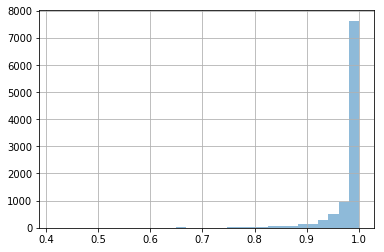

In [36]:
_, _, stats_concepts_pos = PSM.mine_obj_intersections(10000, 2, 'neg')
stats_concepts_pos['neg_confidence'].hist(alpha = 0.5, bins = 30)

In [37]:
%%time
from sklearn.model_selection import ParameterGrid
import multiprocessing

param_grid = {
    'subs_size': list(range(2,12)),
    'alpha': np.linspace(0.6,1,41), 
    'hypo_type' : ['neg'],
    'N_hypo_need' : [2000],
    'N_iterations' : [400000],
    'batch_size' : [10000],
}

### WARNING! round(params['alpha'], 4) ---> for readable folder names
MyParamGrid = []
for params in ParameterGrid(param_grid):
    save_path = os.path.join(DATA_FOLDER, 
                             'Hypotheses',
                             params['hypo_type'] + '_' + 
                             str(params['subs_size']) + '_' + 
                             str(round(params['alpha'], 4)))
    if not os.path.exists(save_path):
        os.mkdir(save_path)
    params['save_path'] = save_path
    MyParamGrid.append(params)


pool = multiprocessing.Pool(processes=50) #use all available cores, otherwise specify the number you want as an argument
for args in MyParamGrid:
    pool.apply_async(PSM.mine_hypotheses, args=(args['alpha'],
                                                args['hypo_type'],
                                                args['subs_size'],
                                                args['N_hypo_need'],
                                                args['N_iterations'],
                                                args['batch_size'],
                                                args['save_path'],
                                               ))
pool.close()
pool.join()

Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:36: RuntimeWarning: All-NaN slice encountered


Mining 10000 intersections
Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN slice encountered


Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:36: RuntimeWarning: All-NaN slice encountered


Mining 10000 intersections
Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:36: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN slice encountered


Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:36: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:36: RuntimeWarning: All-NaN slice encountered


Mining 10000 intersections
Mining 10000 intersections
Mining 10000 intersections
Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:36: RuntimeWarning: All-NaN slice encountered


Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:36: RuntimeWarning: All-NaN slice encountered


Mining 10000 intersections
Mining 10000 intersections
Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN slice encountered


Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:36: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:36: RuntimeWarning: All-NaN slice encountered


Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:36: RuntimeWarning: All-NaN slice encountered


Mining 10000 intersections
Mining 10000 intersections
Mining 10000 intersections
Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:36: RuntimeWarning: All-NaN slice encountered


Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:36: RuntimeWarning: All-NaN slice encountered


Mining 10000 intersections
Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:36: RuntimeWarning: All-NaN slice encountered


Mining 10000 intersections
Mining 10000 intersections
Mining 10000 intersections
Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:36: RuntimeWarning: All-NaN slice encountered


Mining 10000 intersections
Mining 10000 intersections
Mining 10000 intersections
Mining 10000 intersections
Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN slice encountered


Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:36: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN slice encountered


Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:36: RuntimeWarning: All-NaN slice encountered


Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:36: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:36: RuntimeWarning: All-NaN slice encountered


Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN slice encountered


Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:36: RuntimeWarning: All-NaN slice encountered


Mining 10000 intersections
Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:36: RuntimeWarning: All-NaN slice encountered


Mining 10000 intersections
Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:36: RuntimeWarning: All-NaN slice encountered


Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN slice encountered


Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:36: RuntimeWarning: All-NaN slice encountered


Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN slice encountered


Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:36: RuntimeWarning: All-NaN slice encountered


Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:36: RuntimeWarning: All-NaN slice encountered


Mining 10000 intersections
Mining 10000 intersections
Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:36: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39

/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/sit

N_mined_hypos of type neg 9984
Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less_equal


N_mined_hypos of type neg 9996
Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal


N_mined_hypos of type neg 9979


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less_equal


N_mined_hypos of type neg 9979
Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:36: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less_equal


Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:36: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less_equal


N_mined_hypos of type neg 9964
Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:36: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: Run

N_mined_hypos of type neg 9994
N_mined_hypos of type neg 9993
Mining 10000 intersections
Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal


N_mined_hypos of type neg 9971


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less_equal


N_mined_hypos of type neg 9971
N_mined_hypos of type neg 9994
Mining 10000 intersections
N_mined_hypos of type neg 9985
Mining 10000 intersections
Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less_equal


Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:36: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal


N_mined_hypos of type neg 9984


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less_equal


Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less_equal


N_mined_hypos of type neg 9974
N_mined_hypos of type neg 9985


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal


Mining 10000 intersections
Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:36: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:36: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value enco

N_mined_hypos of type neg 9985


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less_equal


N_mined_hypos of type neg 9964
N_mined_hypos of type neg 9971


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less_equal


Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less_equal


Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal


Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less_equal


N_mined_hypos of type neg 9994


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal


Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal


N_mined_hypos of type neg 9996


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less_equal


N_mined_hypos of type neg 9985
N_mined_hypos of type neg 9994
Mining 10000 intersections
N_mined_hypos of type neg 9995


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal


Mining 10000 intersections
Mining 10000 intersections
Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less_equal


N_mined_hypos of type neg 9989
N_mined_hypos of type neg 9994


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal


Mining 10000 intersections
N_mined_hypos of type neg 9964
Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal


Mining 10000 intersections
N_mined_hypos of type neg 9974


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN slice encountered


N_mined_hypos of type neg 9996
N_mined_hypos of type neg 9974


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:36: RuntimeWarning: All-NaN slice encountered


Mining 10000 intersections
N_mined_hypos of type neg 9994
Mining 10000 intersections
N_mined_hypos of type neg 9984
Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less_equal


Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less_equal


N_mined_hypos of type neg 9989
N_mined_hypos of type neg 9964
Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal


N_mined_hypos of type neg 9989
Mining 10000 intersections
Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:36: RuntimeWarning: All-NaN slice encountered


Mining 10000 intersections
N_mined_hypos of type neg 9964
N_mined_hypos of type neg 9979


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less_equal


N_mined_hypos of type neg 9974


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal


Mining 10000 intersections
N_mined_hypos of type neg 9994


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal


Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN slice encountered


Mining 10000 intersections
N_mined_hypos of type neg 9974


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:36: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:36: RuntimeWarning: All-NaN slice encountered


Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less_equal


Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less_equal


N_mined_hypos of type neg 9984
N_mined_hypos of type neg 9994


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less_equal


Mining 10000 intersections
N_mined_hypos of type neg 9971
Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less_equal


Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:36: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: 

N_mined_hypos of type neg 9989
N_mined_hypos of type neg 9984
N_mined_hypos of type neg 9985
N_mined_hypos of type neg 9989
Mining 10000 intersections
Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN slice encountered


Mining 10000 intersections
Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:36: RuntimeWarning: All-NaN slice encountered


N_mined_hypos of type neg 9979
N_mined_hypos of type neg 9993
Mining 10000 intersections
N_mined_hypos of type neg 9979
N_mined_hypos of type neg 9971


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN slice encountered


Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:36: RuntimeWarning: All-NaN slice encountered


Mining 10000 intersections
Mining 10000 intersections
N_mined_hypos of type neg 9994
Mining 10000 intersections
N_mined_hypos of type neg 9999
Mining 10000 intersections
N_mined_hypos of type neg 9978
Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:36: RuntimeWarning: All-NaN slice encountered


N_mined_hypos of type neg 9987
Mining 10000 intersections
N_mined_hypos of type neg 9988
Mining 10000 intersections
N_mined_hypos of type neg 9996
N_mined_hypos of type neg 9993
Mining 10000 intersections
Mining 10000 intersections
N_mined_hypos of type neg 9995
Mining 10000 intersections
N_mined_hypos of type neg 9983
Mining 10000 intersections
N_mined_hypos of type neg 9997
Mining 10000 intersections
N_mined_hypos of type neg 9997
Mining 10000 intersections
N_mined_hypos of type neg 9990
N_mined_hypos of type neg 9973
Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:36: RuntimeWarning: All-NaN slice encountered


Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN slice encountered


N_mined_hypos of type neg 9971


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:36: RuntimeWarning: All-NaN slice encountered


Mining 10000 intersections
N_mined_hypos of type neg 9981
N_mined_hypos of type neg 9991
Mining 10000 intersections
Mining 10000 intersections
N_mined_hypos of type neg 9991
N_mined_hypos of type neg 9981
Mining 10000 intersections
Mining 10000 intersections
N_mined_hypos of type neg 9973
Mining 10000 intersections
N_mined_hypos of type neg 9981
Mining 10000 intersections
N_mined_hypos of type neg 9988
Mining 10000 intersections
N_mined_hypos of type neg 9973
N_mined_hypos of type neg 9992
N_mined_hypos of type neg 9969
Mining 10000 intersections
Mining 10000 intersections
Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:36: RuntimeWarning: All-NaN slice encountered


N_mined_hypos of type neg 9964
N_mined_hypos of type neg 9973
Mining 10000 intersections
N_mined_hypos of type neg 9997
Mining 10000 intersections
Mining 10000 intersections
N_mined_hypos of type neg 9967
Mining 10000 intersections
N_mined_hypos of type neg 9970
Mining 10000 intersections
N_mined_hypos of type neg 9997
Mining 10000 intersections
N_mined_hypos of type neg 9975
N_mined_hypos of type neg 9992
Mining 10000 intersections
N_mined_hypos of type neg 9988
Mining 10000 intersections
Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:36: RuntimeWarning: All-NaN slice encountered


N_mined_hypos of type neg 9981
Mining 10000 intersections
N_mined_hypos of type neg 9990
Mining 10000 intersections
N_mined_hypos of type neg 9986


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:36: RuntimeWarning: All-NaN slice encountered


Mining 10000 intersections
N_mined_hypos of type neg 9972
N_mined_hypos of type neg 9997
Mining 10000 intersections
N_mined_hypos of type neg 9993
Mining 10000 intersections
N_mined_hypos of type neg 9973
Mining 10000 intersections
Mining 10000 intersections
N_mined_hypos of type neg 9992
Mining 10000 intersections
N_mined_hypos of type neg 9996
N_mined_hypos of type neg 9980
Mining 10000 intersections
Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN slice encountered


N_mined_hypos of type neg 9995


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:36: RuntimeWarning: All-NaN slice encountered


Mining 10000 intersections
N_mined_hypos of type neg 9991
Mining 10000 intersections
N_mined_hypos of type neg 9969
N_mined_hypos of type neg 9997
Mining 10000 intersections
Mining 10000 intersections
N_mined_hypos of type neg 9973
N_mined_hypos of type neg 9993
N_mined_hypos of type neg 9966
Mining 10000 intersections
Mining 10000 intersections
Mining 10000 intersections
N_mined_hypos of type neg 9960
Mining 10000 intersections
N_mined_hypos of type neg 9960
Mining 10000 intersections
N_mined_hypos of type neg 9997
Mining 10000 intersections
N_mined_hypos of type neg 9953
Mining 10000 intersections
N_mined_hypos of type neg 9996
N_mined_hypos of type neg 9999
Mining 10000 intersections
N_mined_hypos of type neg 9988
Mining 10000 intersections
Mining 10000 intersections
N_mined_hypos of type neg 9991
Mining 10000 intersections
N_mined_hypos of type neg 9994
Mining 10000 intersections
N_mined_hypos of type neg 9975
Mining 10000 intersections
N_mined_hypos of type neg 9983
Mining 10000 i

/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN slice encountered


N_mined_hypos of type neg 9993
Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:36: RuntimeWarning: All-NaN slice encountered


Mining 10000 intersections
N_mined_hypos of type neg 9977
Mining 10000 intersections
N_mined_hypos of type neg 9983
Mining 10000 intersections
N_mined_hypos of type neg 9990
Mining 10000 intersections
N_mined_hypos of type neg 9995
N_mined_hypos of type neg 9997
Mining 10000 intersections
Mining 10000 intersections
N_mined_hypos of type neg 9989
Mining 10000 intersections
N_mined_hypos of type neg 9964
Mining 10000 intersections
N_mined_hypos of type neg 9995
Mining 10000 intersections
N_mined_hypos of type neg 9996
Mining 10000 intersections
N_mined_hypos of type neg 9981
Mining 10000 intersections
N_mined_hypos of type neg 9991
Mining 10000 intersections
N_mined_hypos of type neg 9990
Mining 10000 intersections
N_mined_hypos of type neg 9997
Mining 10000 intersections
N_mined_hypos of type neg 9988
Mining 10000 intersections
N_mined_hypos of type neg 9973
N_mined_hypos of type neg 9983
N_mined_hypos of type neg 9995
Mining 10000 intersections
Mining 10000 intersections
Mining 10000 i

/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN slice encountered


N_mined_hypos of type neg 9995


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:36: RuntimeWarning: All-NaN slice encountered


Mining 10000 intersections
Mining 10000 intersections
Mining 10000 intersections
N_mined_hypos of type neg 9902
N_mined_hypos of type neg 9982
Mining 10000 intersections
Mining 10000 intersections
N_mined_hypos of type neg 9996
Mining 10000 intersections
N_mined_hypos of type neg 9990
Mining 10000 intersections
N_mined_hypos of type neg 9991
Mining 10000 intersections
N_mined_hypos of type neg 9978
Mining 10000 intersections
N_mined_hypos of type neg 9996
N_mined_hypos of type neg 9925
Mining 10000 intersections
N_mined_hypos of type neg 9996
Mining 10000 intersections
Mining 10000 intersections
N_mined_hypos of type neg 9988
Mining 10000 intersections
N_mined_hypos of type neg 9972
Mining 10000 intersections
N_mined_hypos of type neg 9900
N_mined_hypos of type neg 9983
N_mined_hypos of type neg 9997
Mining 10000 intersections
Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN slice encountered


Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:36: RuntimeWarning: All-NaN slice encountered


N_mined_hypos of type neg 9995
Mining 10000 intersections
N_mined_hypos of type neg 9990
Mining 10000 intersections
N_mined_hypos of type neg 9976
N_mined_hypos of type neg 9995
Mining 10000 intersections
N_mined_hypos of type neg 9983
N_mined_hypos of type neg 9991
Mining 10000 intersections
Mining 10000 intersections
N_mined_hypos of type neg 9986
Mining 10000 intersections
Mining 10000 intersections
N_mined_hypos of type neg 9904
Mining 10000 intersections
N_mined_hypos of type neg 9983
Mining 10000 intersections
N_mined_hypos of type neg 9983
Mining 10000 intersections
N_mined_hypos of type neg 9999
Mining 10000 intersections
N_mined_hypos of type neg 9990
Mining 10000 intersections
N_mined_hypos of type neg 9994
Mining 10000 intersections
N_mined_hypos of type neg 9992
Mining 10000 intersections
N_mined_hypos of type neg 9995
Mining 10000 intersections
N_mined_hypos of type neg 9992
Mining 10000 intersections
N_mined_hypos of type neg 9968
N_mined_hypos of type neg 9984
Mining 100

Mining 10000 intersections
N_mined_hypos of type neg 9918
N_mined_hypos of type neg 9361
Mining 10000 intersections
Mining 10000 intersections
N_mined_hypos of type neg 9668
Mining 10000 intersections
N_mined_hypos of type neg 9616
Mining 10000 intersections
N_mined_hypos of type neg 9940
Mining 10000 intersections
N_mined_hypos of type neg 9331
Mining 10000 intersections
N_mined_hypos of type neg 9848
N_mined_hypos of type neg 9900
Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:36: RuntimeWarning: All-NaN slice encountered


Mining 10000 intersections
N_mined_hypos of type neg 9855
Mining 10000 intersections
N_mined_hypos of type neg 9598
N_mined_hypos of type neg 9944
Mining 10000 intersections
Mining 10000 intersections
N_mined_hypos of type neg 9936
Mining 10000 intersections
N_mined_hypos of type neg 9856
N_mined_hypos of type neg 9967
Mining 10000 intersections
Mining 10000 intersections
N_mined_hypos of type neg 9684
N_mined_hypos of type neg 9159
Mining 10000 intersections
Mining 10000 intersections
N_mined_hypos of type neg 9494
Mining 10000 intersections
N_mined_hypos of type neg 9871
Mining 10000 intersections
N_mined_hypos of type neg 9624
N_mined_hypos of type neg 9784
Mining 10000 intersections
Mining 10000 intersections
N_mined_hypos of type neg 9850
Mining 10000 intersections
N_mined_hypos of type neg 8947
Mining 10000 intersections
N_mined_hypos of type neg 9827
N_mined_hypos of type neg 9621
Mining 10000 intersections
Mining 10000 intersections
N_mined_hypos of type neg 8878
Mining 10000 i

N_mined_hypos of type neg 2
Mining 10000 intersections
N_mined_hypos of type neg 0
N_mined_hypos of type neg 0
Mining 10000 intersections
Mining 10000 intersections
N_mined_hypos of type neg 16
Mining 10000 intersections
N_mined_hypos of type neg 0
Mining 10000 intersections
N_mined_hypos of type neg 467
Mining 10000 intersections
N_mined_hypos of type neg 171
Mining 10000 intersections
N_mined_hypos of type neg 1740
Mining 10000 intersections
N_mined_hypos of type neg 293
Mining 10000 intersections
N_mined_hypos of type neg 1465
Mining 10000 intersections
N_mined_hypos of type neg 0
Mining 10000 intersections
N_mined_hypos of type neg 923
Mining 10000 intersections
N_mined_hypos of type neg 17
Mining 10000 intersections
N_mined_hypos of type neg 0
Mining 10000 intersections
N_mined_hypos of type neg 3
Mining 10000 intersections
N_mined_hypos of type neg 0
Mining 10000 intersections
N_mined_hypos of type neg 0
Mining 10000 intersections
N_mined_hypos of type neg 192
Mining 10000 inters

Mining 10000 intersections
N_mined_hypos of type neg 505
Mining 10000 intersections
N_mined_hypos of type neg 1226
Mining 10000 intersections
N_mined_hypos of type neg 6
Mining 10000 intersections
N_mined_hypos of type neg 52
Mining 10000 intersections
N_mined_hypos of type neg 0
Mining 10000 intersections
N_mined_hypos of type neg 729
Mining 10000 intersections
N_mined_hypos of type neg 0
Mining 10000 intersections
N_mined_hypos of type neg 1
Mining 10000 intersections
N_mined_hypos of type neg 0
Mining 10000 intersections
N_mined_hypos of type neg 1269
Mining 10000 intersections
N_mined_hypos of type neg 532
Mining 10000 intersections
N_mined_hypos of type neg 6
Mining 10000 intersections
N_mined_hypos of type neg 52
Mining 10000 intersections
N_mined_hypos of type neg 0
Mining 10000 intersections
N_mined_hypos of type neg 760
Mining 10000 intersections
N_mined_hypos of type neg 0
Mining 10000 intersections
N_mined_hypos of type neg 1
Mining 10000 intersections
N_mined_hypos of type 

Mining 10000 intersections
N_mined_hypos of type neg 1261
Mining 10000 intersections
N_mined_hypos of type neg 0
Mining 10000 intersections
N_mined_hypos of type neg 0
Mining 10000 intersections
N_mined_hypos of type neg 1
Mining 10000 intersections
N_mined_hypos of type neg 894
Mining 10000 intersections
N_mined_hypos of type neg 7
Mining 10000 intersections
N_mined_hypos of type neg 100
Mining 10000 intersections
N_mined_hypos of type neg 0
Mining 10000 intersections
N_mined_hypos of type neg 1287
N_mined_hypos of type neg 0
N_mined_hypos of type neg 0
N_mined_hypos of type neg 2
N_mined_hypos of type neg 914
N_mined_hypos of type neg 103
N_mined_hypos of type neg 0
N_mined_hypos of type neg 8
CPU times: user 8.97 s, sys: 4.2 s, total: 13.2 s
Wall time: 8min 46s


In [81]:
# %%time
alpha_pos = 0.1
subs_size = 3
hypo_type = 'pos'

# save_path = os.path.join(DATA_FOLDER, 'Hypotheses',hypo_type + '_' + str(subs_size) + '_' + str(alpha_pos))
# # if not os.path.exists(save_path):
# #     os.mkdir(save_path)
pos_hypotheses_min, pos_hypotheses_max = PSM.mine_hypotheses(alpha = alpha_pos,
                                                             hypo_type = 'pos',
                                                             subs_size = 3,
                                                             N_hypo_need = 500,
                                                             N_iterations = 10000,
                                                             batch_size = 10000,
#                                                              save_path = save_path
                                                            )

Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:36: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less_equal


N_mined_hypos of type pos 5758


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal


In [82]:
%%time
alpha_neg = 0.9999
neg_hypotheses_min, neg_hypotheses_max = PSM.mine_hypotheses(alpha = alpha_neg,
                                                    hypo_type = 'neg',
                                                    subs_size = 3,
                                                    N_hypo_need = 500,
                                                    N_iterations = 20000,
                                                    batch_size = 10000
                                                   )

Mining 10000 intersections


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:36: RuntimeWarning: All-NaN slice encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less_equal


N_mined_hypos of type neg 1508
CPU times: user 5.72 s, sys: 2.48 s, total: 8.2 s
Wall time: 8.19 s


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal


### PatternStructuresClassifier

In [18]:
class PatternStructuresClassifier():
    """
    Classifier turns hypotheses given test objects into classifiers
    """
    def __init__(self, data_pos, data_neg, feature_list):
        """
        :param data_pos: Pandas.DataFrame with objects from class 1
        :param data_neg: Pandas.DataFrame with objects from class 0
        :param feature_list: list of column names used as features
        """
        self.data_pos = data_pos[feature_list]
        self.data_neg = data_neg[feature_list]
        self.X_pos_expanded = self.data_pos.values[None,:,:]
        self.X_neg_expanded = self.data_neg.values[None,:,:]
        self.feature_list = feature_list
        self.is_nan_X_pos_expanded = np.isnan(self.X_pos_expanded)
        self.is_nan_X_neg_expanded = np.isnan(self.X_neg_expanded)
        
    def classify_test_objects(self, X_test, hypotheses_min, hypotheses_max, alpha, 
                              save_scores_file_path=None, print_when_over=False):
        """
        :X_test: Pandas.DataFrame with objects from class 1
        :hypotheses_min: min_bound of hypotheses of shape (n_hypos, n_feat)
        :hypotheses_max: max_bound of hypotheses of shape (n_hypos, n_feat)
        :alpha: list of column names used as features
        :save_scores_file_path: path to FILE with scores for given test objects
        :print_when_over: print a message when completed (useful for parallel computing)
        """
        SCORE_RES = []
        for i in range(X_test.shape[0]):
            test_obj = X_test[[i],:]
#             test_obj = X_test[:,:]

            classifier_min = np.nanmin([np.repeat(test_obj, hypotheses_min.shape[0], axis=0), hypotheses_min], axis=0)[:,None,:]
            classifier_max = np.nanmax([np.repeat(test_obj, hypotheses_max.shape[0], axis=0), hypotheses_max], axis=0)[:,None,:]

            num_POS_objs_in_clfs = ((((classifier_min <= self.X_pos_expanded) | np.isnan(classifier_min)) & 
                                    ((classifier_max >= self.X_pos_expanded) | np.isnan(classifier_max))) | 
                                    self.is_nan_X_pos_expanded).all(axis=-1).sum(axis=-1)
            num_NEG_objs_in_clfs = ((((classifier_min <= self.X_neg_expanded) | np.isnan(classifier_min)) & 
                                    ((classifier_max >= self.X_neg_expanded) | np.isnan(classifier_max))) | 
                                    self.is_nan_X_neg_expanded).all(axis=-1).sum(axis=-1)
            NO_OBJ_IN_CLF = ((num_POS_objs_in_clfs == 0) & (num_NEG_objs_in_clfs == 0)).sum()
#             print(NO_OBJ_IN_CLF)
            num_POS_objs_in_clfs[(num_POS_objs_in_clfs == 0) & (num_NEG_objs_in_clfs == 0)] = 1
            POS_confinedce = num_POS_objs_in_clfs / (num_NEG_objs_in_clfs + num_POS_objs_in_clfs)
#             POS_confinedce = POS_confinedce[POS_confinedce == POS_confinedce]
            NEG_confinedce = 1 - POS_confinedce

            POS_alpha_weak_sum = (POS_confinedce >= alpha).sum(axis=-1)
            NEG_alpha_weak_sum = (NEG_confinedce >= alpha).sum(axis=-1)
            POS_alpha_weak_conf_sum = POS_confinedce[POS_confinedce >= alpha].sum(axis=-1)
            NEG_alpha_weak_conf_sum = NEG_confinedce[NEG_confinedce >= alpha].sum(axis=-1)
            
            POS_alpha_weak_mean = (POS_confinedce >= alpha).mean(axis=-1)
            NEG_alpha_weak_mean = (NEG_confinedce >= alpha).mean(axis=-1)
            POS_alpha_weak_conf_mean_alpha = POS_confinedce[POS_confinedce >= alpha].mean(axis=-1)
            NEG_alpha_weak_conf_mean_alpha = NEG_confinedce[NEG_confinedce >= alpha].mean(axis=-1)
            POS_alpha_weak_conf_mean_all = (POS_confinedce*(POS_confinedce >= alpha)).mean(axis=-1)
            NEG_alpha_weak_conf_mean_all = (NEG_confinedce*(NEG_confinedce >= alpha)).mean(axis=-1)


            scores_dict = {
                'num_POS_objs_sum' : num_POS_objs_in_clfs.sum(axis=-1),
                'num_NEG_objs_sum' : num_NEG_objs_in_clfs.sum(axis=-1),
                'POS_confinedce_sum' : POS_confinedce.sum(axis=-1),
                'NEG_confinedce_sum' : NEG_confinedce.sum(axis=-1),
                'num_POS_alpha_weak_sum' : POS_alpha_weak_sum,
                'num_NEG_alpha_weak_sum' : NEG_alpha_weak_sum,
                'POS_alpha_weak_conf_sum' : POS_alpha_weak_conf_sum,
                'NEG_alpha_weak_conf_sum' : NEG_alpha_weak_conf_sum,
                
                'num_POS_objs_mean' : num_POS_objs_in_clfs.mean(axis=-1),
                'num_NEG_objs_mean' : num_NEG_objs_in_clfs.mean(axis=-1),
                'POS_confinedce_mean' : POS_confinedce.mean(axis=-1),
                'NEG_confinedce_mean' : NEG_confinedce.mean(axis=-1),
                'num_POS_alpha_weak_mean' : POS_alpha_weak_mean,
                'num_NEG_alpha_weak_mean' : NEG_alpha_weak_mean,
                'POS_alpha_weak_conf_mean_alpha' : POS_alpha_weak_conf_mean_alpha,
                'NEG_alpha_weak_conf_mean_alpha' : NEG_alpha_weak_conf_mean_alpha,
                'POS_alpha_weak_conf_mean_all' : POS_alpha_weak_conf_mean_all,
                'NEG_alpha_weak_conf_mean_all' : NEG_alpha_weak_conf_mean_all,
                
#                 'num_POS2NEG_clf' : np.divide(num_POS_objs_in_clfs.astype(np.float32), 
#                                        num_NEG_objs_in_clfs.astype(np.float32), 
#                                        out=np.ones_like(num_POS_objs_in_clfs.astype(np.float32))*self.data_pos.shape[0],
#                                        where=num_NEG_objs_in_clfs.astype(np.float32)!=0).sum(axis=-1),
            }
            SCORE_RES.append(scores_dict)
            
        df_test_scores = pd.DataFrame(SCORE_RES)
        if save_scores_file_path:
            df_test_scores.to_csv(save_scores_file_path)
        
        if print_when_over:
            print(hypo_source_path, " is OVER now!!!")
        return df_test_scores

In [19]:
features = ['RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents']

In [20]:
PS_clf = PatternStructuresClassifier(df_train_pos, df_train_neg, features)

#### Find all not scored combinations

In [74]:
def is_non_zero_file(fpath):
    return True if os.path.isfile(fpath) and os.path.getsize(fpath) > 0 else False

listdir = os.listdir(os.path.join(DATA_FOLDER,'Hypotheses'))
# listdir.remove('.ipynb_checkpoints')
np.random.shuffle(listdir)

# MyParamGrid = []
i = 0
for hypo_source_dir in listdir:
    _, _, alpha = hypo_source_dir.split('_')
    alpha = float(alpha)
    
    hypo_source_path = os.path.join(DATA_FOLDER,'Hypotheses', hypo_source_dir)
    hypo_path_min = os.path.join(hypo_source_path, 'hypotheses_min.csv')
    hypo_path_max = os.path.join(hypo_source_path, 'hypotheses_max.csv')

    if is_non_zero_file(hypo_path_min):
        i+=1
#         hypotheses_min = pd.read_csv(hypo_path_min, header=None).values[:N_HYPO_MAX]
#         hypotheses_max = pd.read_csv(hypo_path_max, header=None).values[:N_HYPO_MAX]
#         hypo_source_path

#         args = {
#             'X_test':X_test,
#             'hypotheses_min':hypotheses_min,
#             'hypotheses_max':hypotheses_max,
#             'alpha':alpha,
#             'save_scores_file_path':os.path.join(hypo_source_path, 'df_test_scores.csv'),
#             'print_when_over':True
#         }

#         MyParamGrid.append(args)
# len(MyParamGrid)
i

798

#### Parallel through all combinations of Hyperparams

In [21]:
N_HYPO_MAX = 2000
N_PROC = 50

In [23]:
def is_non_zero_file(fpath):
    return True if os.path.isfile(fpath) and os.path.getsize(fpath) > 0 else False

listdir = os.listdir(os.path.join(DATA_FOLDER,'Hypotheses'))
# listdir.remove('.ipynb_checkpoints')
np.random.shuffle(listdir)

MyParamGrid = []
for hypo_source_dir in listdir:
    _, _, alpha = hypo_source_dir.split('_')
    alpha = float(alpha)
    
    hypo_source_path = os.path.join(DATA_FOLDER,'Hypotheses', hypo_source_dir)
    hypo_path_min = os.path.join(hypo_source_path, 'hypotheses_min.csv')
    hypo_path_max = os.path.join(hypo_source_path, 'hypotheses_max.csv')

    if is_non_zero_file(hypo_path_min):
        hypotheses_min = pd.read_csv(hypo_path_min, header=None).values[:N_HYPO_MAX]
        hypotheses_max = pd.read_csv(hypo_path_max, header=None).values[:N_HYPO_MAX]

        args = {
            'X_test':X_test,
            'hypotheses_min':hypotheses_min,
            'hypotheses_max':hypotheses_max,
            'alpha':alpha,
            'save_scores_file_path':os.path.join(hypo_source_path, 'df_test_scores.csv'),
            'print_when_over':True
        }

        MyParamGrid.append(args)
len(MyParamGrid)

798

#### Parallel through X_test (one set of params)

In [22]:
N_HYPO_MAX = 2000

In [23]:
def is_non_zero_file(fpath):
    return True if os.path.isfile(fpath) and os.path.getsize(fpath) > 0 else False

listdir = os.listdir(os.path.join(DATA_FOLDER,'Hypotheses'))
listdir.remove('.ipynb_checkpoints')
np.random.shuffle(listdir)

hypo_source_dir = 'pos_2_0.8'
_, _, alpha = hypo_source_dir.split('_')
alpha = float(alpha)
hypo_source_path = os.path.join(DATA_FOLDER,'Hypotheses', hypo_source_dir)
hypo_path_min = os.path.join(hypo_source_path, 'hypotheses_min.csv')
hypo_path_max = os.path.join(hypo_source_path, 'hypotheses_max.csv')

print("Any hypotheses in there? ", is_non_zero_file(hypo_path_min))
if is_non_zero_file(hypo_path_min):
    hypotheses_min = pd.read_csv(hypo_path_min, header=None).values[:N_HYPO_MAX]
    hypotheses_max = pd.read_csv(hypo_path_max, header=None).values[:N_HYPO_MAX]
MyParamGrid = []
for i in range(50):
# for test_obj in X_test[:90]:
    args = {
#         'X_test':test_obj[None,:],
        'X_test':X_test[100*i:100*(i+1)],
        'hypotheses_min':hypotheses_min,
        'hypotheses_max':hypotheses_max,
        'alpha':alpha,
        'save_scores_file_path':None,
        'print_when_over':False
    }
    MyParamGrid.append(args)

Any hypotheses in there?  True


#### Run parallel

In [ ]:
%%time
import multiprocessing
pool = multiprocessing.Pool(processes=60) #use all available cores, otherwise specify the number you want as an argument

results = []
for args in MyParamGrid:
#     print(args)
    res = pool.apply_async(PS_clf.classify_test_objects, args=(args['X_test'],
                                                               args['hypotheses_min'],
                                                               args['hypotheses_max'],
                                                               args['alpha'],
                                                               args['save_scores_file_path'],
                                                               args['print_when_over']
                                                              ))
    results.append(res)
    
pool.close()
pool.join()

/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:34: RuntimeWarning: All-NaN axis encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN axis encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:57: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encounter

/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:34: RuntimeWarning: All-NaN axis encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN axis encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:38: RuntimeWarn

/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:57: RuntimeWarning: Mean of empty slice.
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in greater_equal
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:57: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:34: RuntimeWarning: All-NaN axis encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN axis encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launche

/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN axis encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_lau

/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in less_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:57: RuntimeWarning: Mean of empty slice.
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:57: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:

/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:57: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:57: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in greater_equal
/home/autodeploy/.local/lib/pytho

/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:57: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:57: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:57: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:57: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.5/dist-packages/numpy/core/_

GiveMeSomeCredit/Hypotheses/neg_6_0.68  is OVER now!!!


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:34: RuntimeWarning: All-NaN axis encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN axis encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:57: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:57: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:57: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid v

GiveMeSomeCredit/Hypotheses/neg_6_0.68  is OVER now!!!


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:57: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:57: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:57: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


GiveMeSomeCredit/Hypotheses/neg_6_0.68  is OVER now!!!


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:34: RuntimeWarning: All-NaN axis encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN axis encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:57: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:57: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:58: RuntimeWarning: Mean of empty slice.
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:58: RuntimeWarnin

GiveMeSomeCredit/Hypotheses/neg_6_0.68  is OVER now!!!


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:34: RuntimeWarning: All-NaN axis encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN axis encountered


GiveMeSomeCredit/Hypotheses/neg_6_0.68  is OVER now!!!
GiveMeSomeCredit/Hypotheses/neg_6_0.68  is OVER now!!!


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:34: RuntimeWarning: All-NaN axis encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN axis encountered


GiveMeSomeCredit/Hypotheses/neg_6_0.68  is OVER now!!!
GiveMeSomeCredit/Hypotheses/neg_6_0.68  is OVER now!!!
GiveMeSomeCredit/Hypotheses/neg_6_0.68  is OVER now!!!


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:34: RuntimeWarning: All-NaN axis encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN axis encountered


GiveMeSomeCredit/Hypotheses/neg_6_0.68  is OVER now!!!


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:58: RuntimeWarning: Mean of empty slice.


GiveMeSomeCredit/Hypotheses/neg_6_0.68  is OVER now!!!
GiveMeSomeCredit/Hypotheses/neg_6_0.68  is OVER now!!!
GiveMeSomeCredit/Hypotheses/neg_6_0.68  is OVER now!!!
GiveMeSomeCredit/Hypotheses/neg_6_0.68  is OVER now!!!
GiveMeSomeCredit/Hypotheses/neg_6_0.68  is OVER now!!!
GiveMeSomeCredit/Hypotheses/neg_6_0.68  is OVER now!!!


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:34: RuntimeWarning: All-NaN axis encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN axis encountered


GiveMeSomeCredit/Hypotheses/neg_6_0.68  is OVER now!!!
GiveMeSomeCredit/Hypotheses/neg_6_0.68  is OVER now!!!
GiveMeSomeCredit/Hypotheses/neg_6_0.68  is OVER now!!!
GiveMeSomeCredit/Hypotheses/neg_6_0.68  is OVER now!!!


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:34: RuntimeWarning: All-NaN axis encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN axis encountered


GiveMeSomeCredit/Hypotheses/neg_6_0.68  is OVER now!!!
GiveMeSomeCredit/Hypotheses/neg_6_0.68  is OVER now!!!
GiveMeSomeCredit/Hypotheses/neg_6_0.68  is OVER now!!!


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:57: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:58: RuntimeWarning: Mean of empty slice.


GiveMeSomeCredit/Hypotheses/neg_6_0.68  is OVER now!!!
GiveMeSomeCredit/Hypotheses/neg_6_0.68  is OVER now!!!


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:34: RuntimeWarning: All-NaN axis encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN axis encountered


GiveMeSomeCredit/Hypotheses/neg_6_0.68  is OVER now!!!
GiveMeSomeCredit/Hypotheses/neg_6_0.68  is OVER now!!!
GiveMeSomeCredit/Hypotheses/neg_6_0.68  is OVER now!!!


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:58: RuntimeWarning: Mean of empty slice.


GiveMeSomeCredit/Hypotheses/neg_6_0.68  is OVER now!!!


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:34: RuntimeWarning: All-NaN axis encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN axis encountered


GiveMeSomeCredit/Hypotheses/neg_6_0.68  is OVER now!!!
GiveMeSomeCredit/Hypotheses/neg_6_0.68  is OVER now!!!
GiveMeSomeCredit/Hypotheses/neg_6_0.68  is OVER now!!!


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:34: RuntimeWarning: All-NaN axis encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN axis encountered


GiveMeSomeCredit/Hypotheses/neg_6_0.68  is OVER now!!!


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:58: RuntimeWarning: Mean of empty slice.


GiveMeSomeCredit/Hypotheses/neg_6_0.68  is OVER now!!!
GiveMeSomeCredit/Hypotheses/neg_6_0.68  is OVER now!!!
GiveMeSomeCredit/Hypotheses/neg_6_0.68  is OVER now!!!
GiveMeSomeCredit/Hypotheses/neg_6_0.68  is OVER now!!!
GiveMeSomeCredit/Hypotheses/neg_6_0.68  is OVER now!!!
GiveMeSomeCredit/Hypotheses/neg_6_0.68  is OVER now!!!
GiveMeSomeCredit/Hypotheses/neg_6_0.68  is OVER now!!!
GiveMeSomeCredit/Hypotheses/neg_6_0.68  is OVER now!!!
GiveMeSomeCredit/Hypotheses/neg_6_0.68  is OVER now!!!
GiveMeSomeCredit/Hypotheses/neg_6_0.68  is OVER now!!!
GiveMeSomeCredit/Hypotheses/neg_6_0.68  is OVER now!!!


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:34: RuntimeWarning: All-NaN axis encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN axis encountered


GiveMeSomeCredit/Hypotheses/neg_6_0.68  is OVER now!!!
GiveMeSomeCredit/Hypotheses/neg_6_0.68  is OVER now!!!
GiveMeSomeCredit/Hypotheses/neg_6_0.68  is OVER now!!!
GiveMeSomeCredit/Hypotheses/neg_6_0.68  is OVER now!!!
GiveMeSomeCredit/Hypotheses/neg_6_0.68  is OVER now!!!
GiveMeSomeCredit/Hypotheses/neg_6_0.68  is OVER now!!!
GiveMeSomeCredit/Hypotheses/neg_6_0.68  is OVER now!!!


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:34: RuntimeWarning: All-NaN axis encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN axis encountered


GiveMeSomeCredit/Hypotheses/neg_6_0.68  is OVER now!!!
GiveMeSomeCredit/Hypotheses/neg_6_0.68  is OVER now!!!


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:34: RuntimeWarning: All-NaN axis encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN axis encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:57: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


GiveMeSomeCredit/Hypotheses/neg_6_0.68  is OVER now!!!
GiveMeSomeCredit/Hypotheses/neg_6_0.68  is OVER now!!!
GiveMeSomeCredit/Hypotheses/neg_6_0.68  is OVER now!!!
GiveMeSomeCredit/Hypotheses/neg_6_0.68  is OVER now!!!
GiveMeSomeCredit/Hypotheses/neg_6_0.68  is OVER now!!!


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:34: RuntimeWarning: All-NaN axis encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN axis encountered


GiveMeSomeCredit/Hypotheses/neg_6_0.68  is OVER now!!!
GiveMeSomeCredit/Hypotheses/neg_6_0.68  is OVER now!!!


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:34: RuntimeWarning: All-NaN axis encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN axis encountered


GiveMeSomeCredit/Hypotheses/neg_6_0.68  is OVER now!!!


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:34: RuntimeWarning: All-NaN axis encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN axis encountered


GiveMeSomeCredit/Hypotheses/neg_6_0.68  is OVER now!!!


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:58: RuntimeWarning: Mean of empty slice.


GiveMeSomeCredit/Hypotheses/neg_6_0.68  is OVER now!!!
GiveMeSomeCredit/Hypotheses/neg_6_0.68  is OVER now!!!
GiveMeSomeCredit/Hypotheses/neg_6_0.68  is OVER now!!!
GiveMeSomeCredit/Hypotheses/neg_6_0.68  is OVER now!!!
GiveMeSomeCredit/Hypotheses/neg_6_0.68  is OVER now!!!


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:58: RuntimeWarning: Mean of empty slice.


GiveMeSomeCredit/Hypotheses/neg_6_0.68  is OVER now!!!


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:34: RuntimeWarning: All-NaN axis encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN axis encountered


GiveMeSomeCredit/Hypotheses/neg_6_0.68  is OVER now!!!


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:57: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


GiveMeSomeCredit/Hypotheses/neg_6_0.68  is OVER now!!!


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:34: RuntimeWarning: All-NaN axis encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN axis encountered


GiveMeSomeCredit/Hypotheses/neg_6_0.68  is OVER now!!!
GiveMeSomeCredit/Hypotheses/neg_6_0.68  is OVER now!!!
GiveMeSomeCredit/Hypotheses/neg_6_0.68  is OVER now!!!
GiveMeSomeCredit/Hypotheses/neg_6_0.68  is OVER now!!!
GiveMeSomeCredit/Hypotheses/neg_6_0.68  is OVER now!!!


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:34: RuntimeWarning: All-NaN axis encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN axis encountered


GiveMeSomeCredit/Hypotheses/neg_6_0.68  is OVER now!!!
GiveMeSomeCredit/Hypotheses/neg_6_0.68  is OVER now!!!
GiveMeSomeCredit/Hypotheses/neg_6_0.68  is OVER now!!!


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:58: RuntimeWarning: Mean of empty slice.


GiveMeSomeCredit/Hypotheses/neg_6_0.68  is OVER now!!!


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:34: RuntimeWarning: All-NaN axis encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN axis encountered


GiveMeSomeCredit/Hypotheses/neg_6_0.68  is OVER now!!!
GiveMeSomeCredit/Hypotheses/neg_6_0.68  is OVER now!!!
GiveMeSomeCredit/Hypotheses/neg_6_0.68  is OVER now!!!
GiveMeSomeCredit/Hypotheses/neg_6_0.68  is OVER now!!!


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:58: RuntimeWarning: Mean of empty slice.


GiveMeSomeCredit/Hypotheses/neg_6_0.68  is OVER now!!!


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:58: RuntimeWarning: Mean of empty slice.


GiveMeSomeCredit/Hypotheses/neg_6_0.68  is OVER now!!!
GiveMeSomeCredit/Hypotheses/neg_6_0.68  is OVER now!!!
GiveMeSomeCredit/Hypotheses/neg_6_0.68  is OVER now!!!
GiveMeSomeCredit/Hypotheses/neg_6_0.68  is OVER now!!!
GiveMeSomeCredit/Hypotheses/neg_6_0.68  is OVER now!!!
GiveMeSomeCredit/Hypotheses/neg_6_0.68  is OVER now!!!
GiveMeSomeCredit/Hypotheses/neg_6_0.68  is OVER now!!!
GiveMeSomeCredit/Hypotheses/neg_6_0.68  is OVER now!!!
GiveMeSomeCredit/Hypotheses/neg_6_0.68  is OVER now!!!
GiveMeSomeCredit/Hypotheses/neg_6_0.68  is OVER now!!!
GiveMeSomeCredit/Hypotheses/neg_6_0.68  is OVER now!!!
GiveMeSomeCredit/Hypotheses/neg_6_0.68  is OVER now!!!


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:34: RuntimeWarning: All-NaN axis encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN axis encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:57: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


GiveMeSomeCredit/Hypotheses/neg_6_0.68  is OVER now!!!
GiveMeSomeCredit/Hypotheses/neg_6_0.68  is OVER now!!!


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:58: RuntimeWarning: Mean of empty slice.


GiveMeSomeCredit/Hypotheses/neg_6_0.68  is OVER now!!!
GiveMeSomeCredit/Hypotheses/neg_6_0.68  is OVER now!!!
GiveMeSomeCredit/Hypotheses/neg_6_0.68  is OVER now!!!
GiveMeSomeCredit/Hypotheses/neg_6_0.68  is OVER now!!!
GiveMeSomeCredit/Hypotheses/neg_6_0.68  is OVER now!!!
GiveMeSomeCredit/Hypotheses/neg_6_0.68  is OVER now!!!


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:34: RuntimeWarning: All-NaN axis encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN axis encountered


GiveMeSomeCredit/Hypotheses/neg_6_0.68  is OVER now!!!
GiveMeSomeCredit/Hypotheses/neg_6_0.68  is OVER now!!!


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:58: RuntimeWarning: Mean of empty slice.


GiveMeSomeCredit/Hypotheses/neg_6_0.68  is OVER now!!!
GiveMeSomeCredit/Hypotheses/neg_6_0.68  is OVER now!!!
GiveMeSomeCredit/Hypotheses/neg_6_0.68  is OVER now!!!


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:34: RuntimeWarning: All-NaN axis encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN axis encountered


GiveMeSomeCredit/Hypotheses/neg_6_0.68  is OVER now!!!


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:58: RuntimeWarning: Mean of empty slice.


GiveMeSomeCredit/Hypotheses/neg_6_0.68  is OVER now!!!
GiveMeSomeCredit/Hypotheses/neg_6_0.68  is OVER now!!!
GiveMeSomeCredit/Hypotheses/neg_6_0.68  is OVER now!!!
GiveMeSomeCredit/Hypotheses/neg_6_0.68  is OVER now!!!
GiveMeSomeCredit/Hypotheses/neg_6_0.68  is OVER now!!!
GiveMeSomeCredit/Hypotheses/neg_6_0.68  is OVER now!!!


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:34: RuntimeWarning: All-NaN axis encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN axis encountered


GiveMeSomeCredit/Hypotheses/neg_6_0.68  is OVER now!!!
GiveMeSomeCredit/Hypotheses/neg_6_0.68  is OVER now!!!
GiveMeSomeCredit/Hypotheses/neg_6_0.68  is OVER now!!!
GiveMeSomeCredit/Hypotheses/neg_6_0.68  is OVER now!!!
GiveMeSomeCredit/Hypotheses/neg_6_0.68  is OVER now!!!


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:34: RuntimeWarning: All-NaN axis encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN axis encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:58: RuntimeWarning: Mean of empty slice.


GiveMeSomeCredit/Hypotheses/neg_6_0.68  is OVER now!!!
GiveMeSomeCredit/Hypotheses/neg_6_0.68  is OVER now!!!


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:34: RuntimeWarning: All-NaN axis encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN axis encountered


GiveMeSomeCredit/Hypotheses/neg_6_0.68  is OVER now!!!
GiveMeSomeCredit/Hypotheses/neg_6_0.68  is OVER now!!!


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:34: RuntimeWarning: All-NaN axis encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN axis encountered


GiveMeSomeCredit/Hypotheses/neg_6_0.68  is OVER now!!!
GiveMeSomeCredit/Hypotheses/neg_6_0.68  is OVER now!!!
GiveMeSomeCredit/Hypotheses/neg_6_0.68  is OVER now!!!
GiveMeSomeCredit/Hypotheses/neg_6_0.68  is OVER now!!!
GiveMeSomeCredit/Hypotheses/neg_6_0.68  is OVER now!!!
GiveMeSomeCredit/Hypotheses/neg_6_0.68  is OVER now!!!
GiveMeSomeCredit/Hypotheses/neg_6_0.68  is OVER now!!!


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:58: RuntimeWarning: Mean of empty slice.


GiveMeSomeCredit/Hypotheses/neg_6_0.68  is OVER now!!!
GiveMeSomeCredit/Hypotheses/neg_6_0.68  is OVER now!!!
GiveMeSomeCredit/Hypotheses/neg_6_0.68  is OVER now!!!
GiveMeSomeCredit/Hypotheses/neg_6_0.68  is OVER now!!!


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:34: RuntimeWarning: All-NaN axis encountered
/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: All-NaN axis encountered


GiveMeSomeCredit/Hypotheses/neg_6_0.68  is OVER now!!!
GiveMeSomeCredit/Hypotheses/neg_6_0.68  is OVER now!!!


/home/autodeploy/.local/lib/python3.5/site-packages/ipykernel_launcher.py:58: RuntimeWarning: Mean of empty slice.


GiveMeSomeCredit/Hypotheses/neg_6_0.68  is OVER now!!!
GiveMeSomeCredit/Hypotheses/neg_6_0.68  is OVER now!!!


#### Collect results

In [27]:
df_res_X_test_all_hypos = pd.concat([res.get() for res in results])
# df_res_X_test_all_hypos.to_csv(os.path.join(hypo_source_path, 'df_res_X_test_all_hypos.csv'))
df_res_X_test_all_hypos.head(2)

In [26]:
# 2*metrics.roc_auc_score(y[df_test.index], df_res_X_test_all_hypos['NEG_rate_alpha_sum']) - 1
# 2*metrics.roc_auc_score(y[df_test.index], df_res_X_test_all_hypos['POS_rate_alpha_sum']) - 1
# 2*metrics.roc_auc_score(y[df_test.index], df_res_X_test_all_hypos['num_NEG_objs_in_clfs']) - 1
# 2*metrics.roc_auc_score(y[df_test.index], df_res_X_test_all_hypos['num_POS2NEG_clf']) - 1
# 2*metrics.roc_auc_score(y[df_test.index], df_res_X_test_all_hypos['num_POS_objs_in_clfs']) - 1

In [27]:
# # score_rate = df_res_X_test_all_hypos['POS_rate_clf'].values - df_test_scores['NEG_rate_clf'].values
# final_score = df_res_X_test_all_hypos['POS_rate_alpha_sum'].values/6240 - df_test_scores['NEG_rate_alpha_sum'].values/500

# # 2*metrics.roc_auc_score(y[df_test.index], score_rate) - 1
# 2*metrics.roc_auc_score(y[df_test.index], final_score) - 1

#### Collectt all df_scores

In [107]:
len(df_test_scores_dict['neg'])

149

In [108]:
len(df_test_scores_dict['pos'])

190

In [58]:
listdir = os.listdir(os.path.join(DATA_FOLDER,'Hypotheses'))
# listdir.remove('.ipynb_checkpoints')
np.random.shuffle(listdir)

metrics_LIST = []
for hypo_source_dir in listdir:
    df_test_scores_path = os.path.join(DATA_FOLDER,'Hypotheses',hypo_source_dir,'df_test_scores.csv')
    try:
        df_test_scores = pd.read_csv(df_test_scores_path, index_col=0)
        df_test_scores = df_test_scores.fillna(0)
        clf_type, _, _ = hypo_source_dir.split('_')
        df_test_scores_dict[hypo_source_dir] = df_test_scores
        metrics_dict_temp = {col:2*metrics.roc_auc_score(y_test, df_test_scores[col]) - 1 for col in df_test_scores.columns}
        metrics_dict_temp['hypo_params'] = hypo_source_dir
        metrics_dict_temp['hypo_type'] = clf_type
        metrics_LIST.append(metrics_dict_temp)
    except FileNotFoundError: 
        print("No hypotheses were mined in '" + df_test_scores_path + "'")

In [59]:
df_metrics_all = pd.DataFrame(metrics_LIST)
df_metrics_all.max()
df_metrics_all.min()

Series([], dtype: float64)

Series([], dtype: float64)

In [30]:
df_metrics_all.query("hypo_type == 'neg'").max()
df_metrics_all.query("hypo_type == 'neg'").min()

NEG_alpha_weak_conf_mean_all        -0.180961
NEG_alpha_weak_conf_mean_alpha     -0.0780926
NEG_alpha_weak_conf_sum             -0.180961
NEG_confinedce_mean                 -0.594932
NEG_confinedce_sum                  -0.594932
POS_alpha_weak_conf_mean_all         0.141121
POS_alpha_weak_conf_mean_alpha       0.139962
POS_alpha_weak_conf_sum              0.141121
POS_confinedce_mean                   0.69633
POS_confinedce_sum                    0.69633
hypo_params                        neg_9_0.99
hypo_type                                 neg
num_NEG_alpha_weak_mean           0.000428449
num_NEG_alpha_weak_sum            0.000428449
num_NEG_objs_mean                    0.621887
num_NEG_objs_sum                     0.621887
num_POS_alpha_weak_mean              0.142277
num_POS_alpha_weak_sum               0.142277
num_POS_objs_mean                    0.670077
num_POS_objs_sum                     0.670077
dtype: object

NEG_alpha_weak_conf_mean_all       -0.695526
NEG_alpha_weak_conf_mean_alpha     -0.695537
NEG_alpha_weak_conf_sum            -0.695526
NEG_confinedce_mean                 -0.69633
NEG_confinedce_sum                  -0.69633
POS_alpha_weak_conf_mean_all               0
POS_alpha_weak_conf_mean_alpha             0
POS_alpha_weak_conf_sum                    0
POS_confinedce_mean                 0.594932
POS_confinedce_sum                  0.594932
hypo_params                       neg_10_0.6
hypo_type                                neg
num_NEG_alpha_weak_mean            -0.685798
num_NEG_alpha_weak_sum             -0.685798
num_NEG_objs_mean                   0.256394
num_NEG_objs_sum                    0.256394
num_POS_alpha_weak_mean                    0
num_POS_alpha_weak_sum                     0
num_POS_objs_mean                   0.552838
num_POS_objs_sum                    0.552838
dtype: object

In [57]:
field_1 = 'POS_alpha_weak_conf_mean_all'
df_sorted_by_metric = df_metrics_all.sort_values(field_1)[['hypo_params', field_1]]
df_sorted_by_metric.head()
df_sorted_by_metric.tail()

,hypo_params,POS_alpha_weak_conf_mean_all
0,neg_9_0.82,0.0
196,neg_5_0.76,0.0
200,neg_6_0.82,0.0
95,neg_7_0.92,0.0
201,neg_9_0.9,0.0


,hypo_params,POS_alpha_weak_conf_mean_all
37,pos_2_0.16,0.695749
29,pos_3_0.22,0.696679
119,pos_3_0.18,0.698092
53,pos_3_0.24,0.703427
145,pos_3_0.28,0.707880


In [58]:
field_2 = 'NEG_alpha_weak_conf_mean_alpha'
df_sorted_by_metric = df_metrics_all.sort_values(field_2)[['hypo_params', field_2]]
df_sorted_by_metric.head()
df_sorted_by_metric.tail()

,hypo_params,NEG_alpha_weak_conf_mean_alpha
155,pos_4_0.38,-0.701265
223,pos_5_0.44,-0.701090
177,pos_4_0.4,-0.701032
334,pos_5_0.42,-0.700901
25,pos_4_0.34,-0.700675


,hypo_params,NEG_alpha_weak_conf_mean_alpha
68,pos_5_0.98,0.000000
275,pos_5_1.0,0.000000
152,pos_4_1.0,0.000000
6,pos_3_0.96,0.089246
263,pos_2_0.96,0.182854


In [62]:
scr_1 = df_test_scores_dict['pos']['pos_3_0.28'][field_1]
scr_2 = df_test_scores_dict['pos']['pos_4_0.38'][field_2]
df_stack = pd.DataFrame({
    'scr_1':scr_1,
    'scr_2':scr_2,
})

In [99]:
from sklearn import linear_model
from sklearn import ensemble
clf = ensemble.RandomForestClassifier(1000,min_samples_split=100,min_samples_leaf=50)
# clf = linear_model.LogisticRegression(C=100000000)
# clf.fit(df_stack.values, y_test)
# 2*metrics.roc_auc_score(y_test, clf.predict_proba(df_stack.values)[:,1]) - 1

In [100]:
def scorer_gini(estimator, X, y):
    return 2*metrics.roc_auc_score(y, estimator.predict_proba(X)[:,1]) - 1    

from sklearn import model_selection
model_selection.cross_val_score(clf, df_stack.values, y_test, scoring=scorer_gini, cv=3, n_jobs = 3).mean()

0.6818922919179987

In [33]:
2*metrics.roc_auc_score(y_test, df_stack.values[:,0]) - 1
2*metrics.roc_auc_score(y_test, df_stack.values[:,1]) - 1

NameError: name 'df_stack' is not defined

### Benchmarks

In [20]:
from sklearn import ensemble, model_selection
from sklearn import tree
from sklearn import neighbors

In [21]:
df_train.isnull().sum()

RevolvingUtilizationOfUnsecuredLines       0
age                                        0
NumberOfTime30-59DaysPastDueNotWorse       0
DebtRatio                                  0
MonthlyIncome                           4057
NumberOfOpenCreditLinesAndLoans            0
NumberOfTimes90DaysLate                    0
NumberRealEstateLoansOrLines               0
NumberOfTime60-89DaysPastDueNotWorse       0
NumberOfDependents                       526
dtype: int64

#### RF

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1, n_jobs=-1,
            oob_score=False, random_state=1514, verbose=0, warm_start=True)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=11, n_jobs=-1,
            oob_score=False, random_state=1514, verbose=0, warm_start=True)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=21, n_jobs=-1,
            oob_score=False, random_state=1514, verbose=0, warm_start=True)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=31, n_jobs=-1,
            oob_score=False, random_state=1514, verbose=0, warm_start=True)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=41, n_jobs=-1,
            oob_score=False, random_state=1514, verbose=0, warm_start=True)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=51, n_jobs=-1,
            oob_score=False, random_state=1514, verbose=0, warm_start=True)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=61, n_jobs=-1,
            oob_score=False, random_state=1514, verbose=0, warm_start=True)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=71, n_jobs=-1,
            oob_score=False, random_state=1514, verbose=0, warm_start=True)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=81, n_jobs=-1,
            oob_score=False, random_state=1514, verbose=0, warm_start=True)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=91, n_jobs=-1,
            oob_score=False, random_state=1514, verbose=0, warm_start=True)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=101, n_jobs=-1,
            oob_score=False, random_state=1514, verbose=0, warm_start=True)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=111, n_jobs=-1,
            oob_score=False, random_state=1514, verbose=0, warm_start=True)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=121, n_jobs=-1,
            oob_score=False, random_state=1514, verbose=0, warm_start=True)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=131, n_jobs=-1,
            oob_score=False, random_state=1514, verbose=0, warm_start=True)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=141, n_jobs=-1,
            oob_score=False, random_state=1514, verbose=0, warm_start=True)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=151, n_jobs=-1,
            oob_score=False, random_state=1514, verbose=0, warm_start=True)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=161, n_jobs=-1,
            oob_score=False, random_state=1514, verbose=0, warm_start=True)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=171, n_jobs=-1,
            oob_score=False, random_state=1514, verbose=0, warm_start=True)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=181, n_jobs=-1,
            oob_score=False, random_state=1514, verbose=0, warm_start=True)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=191, n_jobs=-1,
            oob_score=False, random_state=1514, verbose=0, warm_start=True)

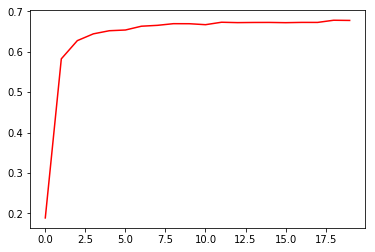

In [31]:
errors = []
growing_rf = ensemble.RandomForestClassifier(n_estimators=1, n_jobs=-1,  
                                    warm_start=True, random_state=1514)
for i in range(20):
    growing_rf.fit(df_train.fillna(df_train.mean()), y_train)
    growing_rf.n_estimators += 10
    metric_val = 2*metrics.roc_auc_score(y_test, growing_rf.predict_proba(df_test.fillna(df_train.mean()))[:,1]) - 1
    errors.append(metric_val)
    

0.7175650158474514

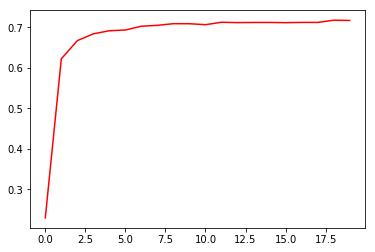

In [38]:
errors = np.array(errors)

final_errors = errors + 0.04
final_errors.max()
plt.plot(final_errors, '-r')

### Benchmarks

In [39]:
from sklearn import ensemble, model_selection
from sklearn import tree
from sklearn import neighbors

In [40]:
df_train.isnull().sum()

RevolvingUtilizationOfUnsecuredLines       0
age                                        0
NumberOfTime30-59DaysPastDueNotWorse       0
DebtRatio                                  0
MonthlyIncome                           4057
NumberOfOpenCreditLinesAndLoans            0
NumberOfTimes90DaysLate                    0
NumberRealEstateLoansOrLines               0
NumberOfTime60-89DaysPastDueNotWorse       0
NumberOfDependents                       526
dtype: int64

#### RF

In [41]:
np.random.seed(42)

In [42]:
param_grid = {
    'min_samples_leaf': [1,2,4,8,16,32],
    'min_samples_split': [2,4,8,16,32,64],
    'n_estimators': [500],
    'n_jobs': [-1],
    'verbose': [1]
}

In [43]:
Grid = list(model_selection.ParameterGrid(param_grid))

METRIC_LIST = []
for params in Grid:
    clf = ensemble.RandomForestClassifier(**params)
    clf.fit(df_train.fillna(df_train.mean()), y_train)
    METRIC_LIST.append({
        'train':2*metrics.roc_auc_score(y_train, clf.predict_proba(df_train.fillna(df_train.mean()))[:,1]) - 1,
        'test':2*metrics.roc_auc_score(y_test, clf.predict_proba(df_test.fillna(df_train.mean()))[:,1]) - 1
    })
    

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    2.4s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.3s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.5s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.2s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.4s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    2.3s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=4,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.3s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.3s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    2.3s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=8,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.4s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.5s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.3s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    2.3s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=16,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.4s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.6s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.3s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    2.4s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=32,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.2s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.4s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.5s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.3s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    2.5s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=64,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.9s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    1.2s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    1.3s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.2s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.4s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    2.8s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.2s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.5s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.7s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.3s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    2.2s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=4,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.4s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.5s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.3s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    2.2s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=8,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.3s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.5s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.3s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    2.4s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=16,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.2s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.3s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.3s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    2.4s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=32,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.3s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.5s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.7s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.8s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.9s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    2.2s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=64,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.3s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.5s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.3s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    2.1s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.4s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.5s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.3s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.4s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    2.3s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=4,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.3s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.3s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.4s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    2.7s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=8,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.3s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.5s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.6s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.3s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    2.2s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=16,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.2s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.4s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.6s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.3s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    2.1s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=32,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.3s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.5s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.6s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.3s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    2.1s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=64,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.3s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.5s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.3s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    2.3s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=8, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.3s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.5s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.6s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.3s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    2.1s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=8, min_samples_split=4,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.2s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.4s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.5s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.2s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.3s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    2.1s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=8, min_samples_split=8,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.2s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.5s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.6s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.3s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    2.2s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=8, min_samples_split=16,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.2s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.4s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.5s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.3s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    2.2s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=8, min_samples_split=32,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.5s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.6s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.3s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    2.1s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=8, min_samples_split=64,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.3s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.3s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    2.2s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=16, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.3s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.5s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.6s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.3s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.5s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    2.3s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=16, min_samples_split=4,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.4s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.5s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.3s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    2.2s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=16, min_samples_split=8,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.2s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.4s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.5s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.3s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    2.3s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=16, min_samples_split=16,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.2s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.4s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.5s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.2s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.4s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    2.2s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=16, min_samples_split=32,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.2s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.4s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.5s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.2s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.4s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    2.1s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=16, min_samples_split=64,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.4s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.5s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.3s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.5s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    2.1s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=32, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.3s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.3s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    2.0s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=32, min_samples_split=4,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.3s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.3s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    2.0s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=32, min_samples_split=8,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.3s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.3s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    2.0s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=32, min_samples_split=16,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.3s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.3s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    2.0s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=32, min_samples_split=32,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.3s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.3s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    2.1s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=32, min_samples_split=64,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.3s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.3s
[Parallel(n_jobs=64)]: Done 500 out of 500 | elapsed:    0.4s finished


In [44]:
pd.DataFrame(METRIC_LIST).max()

test     0.724966
train    1.000000
dtype: float64

#### DT

In [45]:
param_grid = {
    'min_samples_leaf': [1,2,4,8,16,32],
    'min_samples_split': [2,4,8,16,32,64],
}

In [46]:
np.random.seed(42)

In [47]:
Grid = list(model_selection.ParameterGrid(param_grid))

METRIC_LIST = []
for params in Grid:
    clf = tree.DecisionTreeClassifier(**params)
    clf.fit(df_train.fillna(df_train.mean()), y_train)
    METRIC_LIST.append({
        'train':2*metrics.roc_auc_score(y_train, clf.predict_proba(df_train.fillna(df_train.mean()))[:,1]) - 1,
        'test':2*metrics.roc_auc_score(y_test, clf.predict_proba(df_test.fillna(df_train.mean()))[:,1]) - 1
    })
    

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=4,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=8,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=16,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=32,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=64,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=4,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=8,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=16,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=32,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=64,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=4,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=8,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=16,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=32,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=64,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=8, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=8, min_samples_split=4,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=8, min_samples_split=8,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=8, min_samples_split=16,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=8, min_samples_split=32,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=8, min_samples_split=64,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=16, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=16, min_samples_split=4,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=16, min_samples_split=8,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=16, min_samples_split=16,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=16, min_samples_split=32,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=16, min_samples_split=64,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=32, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=32, min_samples_split=4,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=32, min_samples_split=8,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=32, min_samples_split=16,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=32, min_samples_split=32,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=32, min_samples_split=64,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [48]:
pd.DataFrame(METRIC_LIST).max()

test     0.607171
train    1.000000
dtype: float64

#### kNN

In [49]:
np.random.seed(42)

In [50]:
param_grid = {
    'leaf_size': [1,2,4,8,16,32,64],
    'n_neighbors': [1,2,4,8,16,32,64],
    'p': [1,2,3],
    'n_jobs': [-1],
}

In [51]:
Grid = list(model_selection.ParameterGrid(param_grid))

METRIC_LIST = []
for params in Grid:
    clf = neighbors.KNeighborsClassifier(**params)
    clf.fit(df_train.fillna(df_train.mean()), y_train)
    METRIC_LIST.append({
        'train':2*metrics.roc_auc_score(y_train, clf.predict_proba(df_train.fillna(df_train.mean()))[:,1]) - 1,
        'test':2*metrics.roc_auc_score(y_test, clf.predict_proba(df_test.fillna(df_train.mean()))[:,1]) - 1
    })
    

KNeighborsClassifier(algorithm='auto', leaf_size=1, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=1, p=1,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=1, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=1, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=1, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=1, p=3,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=1, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=2, p=1,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=1, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=2, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=1, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=2, p=3,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=1, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=4, p=1,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=1, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=4, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=1, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=4, p=3,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=1, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=8, p=1,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=1, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=8, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=1, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=8, p=3,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=1, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=16, p=1,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=1, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=16, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=1, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=16, p=3,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=1, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=32, p=1,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=1, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=32, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=1, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=32, p=3,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=1, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=64, p=1,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=1, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=64, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=1, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=64, p=3,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=2, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=1, p=1,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=2, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=1, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=2, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=1, p=3,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=2, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=2, p=1,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=2, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=2, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=2, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=2, p=3,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=2, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=4, p=1,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=2, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=4, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=2, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=4, p=3,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=2, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=8, p=1,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=2, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=8, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=2, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=8, p=3,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=2, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=16, p=1,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=2, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=16, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=2, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=16, p=3,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=2, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=32, p=1,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=2, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=32, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=2, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=32, p=3,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=2, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=64, p=1,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=2, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=64, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=2, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=64, p=3,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=4, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=1, p=1,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=4, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=1, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=4, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=1, p=3,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=4, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=2, p=1,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=4, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=2, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=4, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=2, p=3,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=4, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=4, p=1,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=4, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=4, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=4, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=4, p=3,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=4, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=8, p=1,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=4, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=8, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=4, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=8, p=3,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=4, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=16, p=1,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=4, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=16, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=4, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=16, p=3,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=4, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=32, p=1,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=4, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=32, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=4, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=32, p=3,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=4, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=64, p=1,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=4, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=64, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=4, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=64, p=3,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=8, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=1, p=1,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=8, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=1, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=8, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=1, p=3,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=8, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=2, p=1,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=8, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=2, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=8, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=2, p=3,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=8, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=4, p=1,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=8, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=4, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=8, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=4, p=3,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=8, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=8, p=1,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=8, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=8, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=8, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=8, p=3,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=8, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=16, p=1,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=8, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=16, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=8, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=16, p=3,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=8, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=32, p=1,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=8, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=32, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=8, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=32, p=3,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=8, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=64, p=1,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=8, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=64, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=8, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=64, p=3,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=16, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=1, p=1,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=16, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=1, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=16, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=1, p=3,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=16, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=2, p=1,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=16, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=2, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=16, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=2, p=3,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=16, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=4, p=1,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=16, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=4, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=16, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=4, p=3,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=16, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=8, p=1,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=16, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=8, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=16, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=8, p=3,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=16, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=16, p=1,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=16, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=16, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=16, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=16, p=3,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=16, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=32, p=1,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=16, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=32, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=16, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=32, p=3,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=16, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=64, p=1,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=16, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=64, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=16, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=64, p=3,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=32, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=1, p=1,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=32, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=1, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=32, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=1, p=3,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=32, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=2, p=1,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=32, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=2, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=32, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=2, p=3,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=32, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=4, p=1,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=32, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=4, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=32, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=4, p=3,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=32, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=8, p=1,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=32, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=8, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=32, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=8, p=3,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=32, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=16, p=1,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=32, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=16, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=32, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=16, p=3,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=32, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=32, p=1,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=32, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=32, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=32, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=32, p=3,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=32, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=64, p=1,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=32, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=64, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=32, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=64, p=3,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=64, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=1, p=1,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=64, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=1, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=64, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=1, p=3,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=64, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=2, p=1,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=64, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=2, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=64, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=2, p=3,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=64, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=4, p=1,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=64, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=4, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=64, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=4, p=3,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=64, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=8, p=1,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=64, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=8, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=64, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=8, p=3,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=64, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=16, p=1,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=64, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=16, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=64, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=16, p=3,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=64, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=32, p=1,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=64, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=32, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=64, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=32, p=3,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=64, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=64, p=1,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=64, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=64, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=64, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=64, p=3,
           weights='uniform')

In [52]:
pd.DataFrame(METRIC_LIST).max()

test     0.226747
train    0.999231
dtype: float64

#### xgboost

In [53]:
import xgboost as xgb

In [54]:
np.random.seed(42)

In [55]:
dtrain = xgb.DMatrix(df_train.fillna(df_train.mean()), label=y_train)
dtest = xgb.DMatrix(df_test.fillna(df_train.mean()), label=y_test)

In [56]:
param_grid = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5],
        'nthread': [-1],
        'eval_metric': ['auc'],
        }

In [57]:
Grid = list(model_selection.ParameterGrid(param_grid))

METRIC_LIST = []
for params in Grid:
    evallist = [(dtrain, 'train'), (dtest, 'eval')]
    num_round = 100
    bst = xgb.train(params, dtrain, num_round, evallist, early_stopping_rounds=10)
    METRIC_LIST.append({'best_score':2*bst.best_score - 1})
    

[07:35:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[0]	train-auc:0.797913	eval-auc:0.805283
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 10 rounds.
[07:35:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[1]	train-auc:0.821006	eval-auc:0.828336
[07:35:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[2]	train-auc:0.838158	eval-auc:0.83911
[07:35:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[3]	train-auc:0.853494	eval-auc:0.851322
[07:35:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=3
[4]	train-auc:0.853937	eval-auc:0.853164
[07:35:42] /workspace/src/tree/updater_p

[07:35:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[20]	train-auc:0.871273	eval-auc:0.861698
[07:35:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[21]	train-auc:0.871273	eval-auc:0.861698
[07:35:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[22]	train-auc:0.871388	eval-auc:0.861578
[07:35:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[23]	train-auc:0.871442	eval-auc:0.861595
[07:35:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=3
[24]	train-auc:0.87217	eval-auc:0.861354
[07:35:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[25]	train-auc:0.873081	eval-auc:0.861522
[07:35:42] /

[07:35:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=3
[12]	train-auc:0.86362	eval-auc:0.859393
[07:35:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[13]	train-auc:0.86468	eval-auc:0.858587
[07:35:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=3
[14]	train-auc:0.866117	eval-auc:0.858058
[07:35:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=3
[15]	train-auc:0.866244	eval-auc:0.857954
[07:35:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=3
[16]	train-auc:0.866608	eval-auc:0.857594
[07:35:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 8 pruned nodes, max_depth=2
[17]	train-auc:0.866959	eval-auc:0.857974
[07:35:43] /wo

[11]	train-auc:0.865415	eval-auc:0.859685
[07:35:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 6 pruned nodes, max_depth=3
[12]	train-auc:0.865901	eval-auc:0.859807
[07:35:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 4 pruned nodes, max_depth=3
[13]	train-auc:0.866086	eval-auc:0.860087
[07:35:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 4 pruned nodes, max_depth=3
[14]	train-auc:0.86621	eval-auc:0.860193
[07:35:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[15]	train-auc:0.867357	eval-auc:0.857523
[07:35:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 4 pruned nodes, max_depth=3
[16]	train-auc:0.867617	eval-auc:0.859378
[07:35:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 6 pruned nodes, max_depth=3
[17]	train-au

[11]	train-auc:0.863703	eval-auc:0.859118
[07:35:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=3
[12]	train-auc:0.863987	eval-auc:0.859106
[07:35:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 4 pruned nodes, max_depth=3
[13]	train-auc:0.863883	eval-auc:0.859369
[07:35:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 6 pruned nodes, max_depth=3
[14]	train-auc:0.863966	eval-auc:0.859349
[07:35:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=3
[15]	train-auc:0.865001	eval-auc:0.859397
[07:35:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 4 pruned nodes, max_depth=3
[16]	train-auc:0.865759	eval-auc:0.85822
[07:35:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 4 pruned nodes, max_depth=3
[17]	train-a

[1]	train-auc:0.836782	eval-auc:0.840878
[07:35:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 4 pruned nodes, max_depth=4
[2]	train-auc:0.845484	eval-auc:0.844219
[07:35:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 2 pruned nodes, max_depth=4
[3]	train-auc:0.859534	eval-auc:0.85599
[07:35:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[4]	train-auc:0.859623	eval-auc:0.856242
[07:35:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 2 pruned nodes, max_depth=4
[5]	train-auc:0.860299	eval-auc:0.856823
[07:35:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 4 pruned nodes, max_depth=4
[6]	train-auc:0.863252	eval-auc:0.856824
[07:35:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 4 pruned nodes, max_depth=4
[7]	train-auc:0.8

[07:35:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 8 pruned nodes, max_depth=4
[9]	train-auc:0.87001	eval-auc:0.854354
[07:35:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 6 pruned nodes, max_depth=4
[10]	train-auc:0.871445	eval-auc:0.856591
[07:35:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 6 pruned nodes, max_depth=4
[11]	train-auc:0.87296	eval-auc:0.856631
[07:35:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 12 pruned nodes, max_depth=4
[12]	train-auc:0.873191	eval-auc:0.857932
[07:35:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 8 pruned nodes, max_depth=4
[13]	train-auc:0.873385	eval-auc:0.85807
[07:35:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 2 pruned nodes, max_depth=4
[14]	train-auc:0.874077	eval-auc:0.859399
[07:35:44] /w

Will train until eval-auc hasn't improved in 10 rounds.
[07:35:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 2 pruned nodes, max_depth=4
[1]	train-auc:0.836858	eval-auc:0.838861
[07:35:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[2]	train-auc:0.844513	eval-auc:0.841694
[07:35:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 2 pruned nodes, max_depth=4
[3]	train-auc:0.852562	eval-auc:0.853243
[07:35:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 4 pruned nodes, max_depth=4
[4]	train-auc:0.853282	eval-auc:0.854051
[07:35:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 2 pruned nodes, max_depth=4
[5]	train-auc:0.859591	eval-auc:0.856829
[07:35:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 10 pruned nodes, max_depth=4


[07:35:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 6 pruned nodes, max_depth=4
[9]	train-auc:0.866604	eval-auc:0.855208
[07:35:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 4 pruned nodes, max_depth=4
[10]	train-auc:0.866374	eval-auc:0.855366
[07:35:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 10 pruned nodes, max_depth=4
[11]	train-auc:0.866609	eval-auc:0.855798
[07:35:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 14 pruned nodes, max_depth=4
[12]	train-auc:0.867958	eval-auc:0.856616
[07:35:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 2 pruned nodes, max_depth=4
[13]	train-auc:0.869222	eval-auc:0.857334
[07:35:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 8 pruned nodes, max_depth=4
[14]	train-auc:0.871022	eval-auc:0.859177
[07:35:45

[2]	train-auc:0.843141	eval-auc:0.84154
[07:35:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 2 pruned nodes, max_depth=4
[3]	train-auc:0.857169	eval-auc:0.851035
[07:35:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 6 pruned nodes, max_depth=4
[4]	train-auc:0.858879	eval-auc:0.85144
[07:35:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 4 pruned nodes, max_depth=4
[5]	train-auc:0.8643	eval-auc:0.856143
[07:35:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 2 pruned nodes, max_depth=4
[6]	train-auc:0.864957	eval-auc:0.855497
[07:35:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 6 pruned nodes, max_depth=4
[7]	train-auc:0.866779	eval-auc:0.856531
[07:35:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 2 pruned nodes, max_depth=4
[8]	train-auc:0.8679

[07:35:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 16 pruned nodes, max_depth=5
[29]	train-auc:0.887338	eval-auc:0.849839
Stopping. Best iteration:
[19]	train-auc:0.884262	eval-auc:0.855546

[07:35:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 2 pruned nodes, max_depth=5
[0]	train-auc:0.824789	eval-auc:0.822174
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 10 rounds.
[07:35:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 6 pruned nodes, max_depth=5
[1]	train-auc:0.847668	eval-auc:0.842722
[07:35:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 8 pruned nodes, max_depth=5
[2]	train-auc:0.856255	eval-auc:0.848569
[07:35:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 8 pruned nodes, max_depth=5
[3]	train

[07:35:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 8 pruned nodes, max_depth=5
[4]	train-auc:0.866634	eval-auc:0.854427
[07:35:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 10 pruned nodes, max_depth=5
[5]	train-auc:0.867286	eval-auc:0.856329
[07:35:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 14 pruned nodes, max_depth=5
[6]	train-auc:0.871043	eval-auc:0.854797
[07:35:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 4 pruned nodes, max_depth=5
[7]	train-auc:0.872329	eval-auc:0.855167
[07:35:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 10 pruned nodes, max_depth=5
[8]	train-auc:0.872948	eval-auc:0.85268
[07:35:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 22 pruned nodes, max_depth=5
[9]	train-auc:0.873012	eval-auc:0.852837
[07:35:47] /w

[07:35:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 20 pruned nodes, max_depth=5
[16]	train-auc:0.884717	eval-auc:0.858569
[07:35:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 32 pruned nodes, max_depth=3
[17]	train-auc:0.88538	eval-auc:0.858051
[07:35:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 12 pruned nodes, max_depth=5
[18]	train-auc:0.885579	eval-auc:0.858078
[07:35:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 22 pruned nodes, max_depth=5
[19]	train-auc:0.885689	eval-auc:0.858062
[07:35:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 34 pruned nodes, max_depth=5
[20]	train-auc:0.886494	eval-auc:0.857807
Stopping. Best iteration:
[10]	train-auc:0.876309	eval-auc:0.860355

[07:35:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 4 pruned

[14]	train-auc:0.875398	eval-auc:0.859365
[07:35:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 14 pruned nodes, max_depth=5
[15]	train-auc:0.875949	eval-auc:0.858837
[07:35:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 22 pruned nodes, max_depth=5
[16]	train-auc:0.877129	eval-auc:0.851749
[07:35:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 8 pruned nodes, max_depth=5
[17]	train-auc:0.879161	eval-auc:0.850648
[07:35:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 38 pruned nodes, max_depth=5
[18]	train-auc:0.879988	eval-auc:0.849799
[07:35:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 14 pruned nodes, max_depth=5
[19]	train-auc:0.880727	eval-auc:0.850442
[07:35:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 12 pruned nodes, max_depth=5
[20]	

[07:35:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 6 pruned nodes, max_depth=3
[15]	train-auc:0.864067	eval-auc:0.857958
[07:35:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[16]	train-auc:0.864067	eval-auc:0.857958
[07:35:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 12 pruned nodes, max_depth=0
[17]	train-auc:0.864067	eval-auc:0.857958
[07:35:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 6 pruned nodes, max_depth=3
[18]	train-auc:0.864148	eval-auc:0.858003
[07:35:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 8 pruned nodes, max_depth=3
[19]	train-auc:0.864772	eval-auc:0.859036
[07:35:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 6 pruned nodes, max_depth=3
[20]	train-auc:0.865005	eval-auc:0.859911
[07:35:48] /wo

[27]	train-auc:0.866796	eval-auc:0.855911
[07:35:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 8 pruned nodes, max_depth=3
[28]	train-auc:0.86686	eval-auc:0.855868
[07:35:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[29]	train-auc:0.867031	eval-auc:0.855265
[07:35:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[30]	train-auc:0.867031	eval-auc:0.855265
[07:35:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[31]	train-auc:0.867031	eval-auc:0.855265
[07:35:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 12 pruned nodes, max_depth=0
[32]	train-auc:0.867031	eval-auc:0.855265
[07:35:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[33]	train-au

[07:35:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 6 pruned nodes, max_depth=3
[13]	train-auc:0.861816	eval-auc:0.855718
[07:35:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 10 pruned nodes, max_depth=2
[14]	train-auc:0.861925	eval-auc:0.855449
[07:35:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 6 pruned nodes, max_depth=3
[15]	train-auc:0.861219	eval-auc:0.855523
[07:35:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 8 pruned nodes, max_depth=3
[16]	train-auc:0.861612	eval-auc:0.855316
[07:35:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[17]	train-auc:0.861612	eval-auc:0.855316
[07:35:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 6 pruned nodes, max_depth=3
[18]	train-auc:0.862129	eval-auc:0.85527
[07:35:49] /wor

[07:35:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[5]	train-auc:0.857596	eval-auc:0.85335
[07:35:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=3
[6]	train-auc:0.860142	eval-auc:0.854935
[07:35:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[7]	train-auc:0.860522	eval-auc:0.855246
[07:35:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=3
[8]	train-auc:0.862478	eval-auc:0.855759
[07:35:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 8 pruned nodes, max_depth=3
[9]	train-auc:0.86314	eval-auc:0.855344
[07:35:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 8 pruned nodes, max_depth=3
[10]	train-auc:0.863203	eval-auc:0.855509
[07:35:49] /workspa

[5]	train-auc:0.856249	eval-auc:0.852777
[07:35:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=3
[6]	train-auc:0.860507	eval-auc:0.855726
[07:35:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[7]	train-auc:0.86107	eval-auc:0.856177
[07:35:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=3
[8]	train-auc:0.86176	eval-auc:0.855267
[07:35:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 8 pruned nodes, max_depth=3
[9]	train-auc:0.861717	eval-auc:0.855128
[07:35:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 8 pruned nodes, max_depth=2
[10]	train-auc:0.861812	eval-auc:0.854876
[07:35:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 8 pruned nodes, max_depth=2
[11]	train-auc:0.8618

[2]	train-auc:0.837137	eval-auc:0.84277
[07:35:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 12 pruned nodes, max_depth=4
[3]	train-auc:0.850585	eval-auc:0.85197
[07:35:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 14 pruned nodes, max_depth=4
[4]	train-auc:0.851906	eval-auc:0.852776
[07:35:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 10 pruned nodes, max_depth=4
[5]	train-auc:0.852488	eval-auc:0.852096
[07:35:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 4 pruned nodes, max_depth=4
[6]	train-auc:0.860403	eval-auc:0.854924
[07:35:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 16 pruned nodes, max_depth=4
[7]	train-auc:0.860594	eval-auc:0.855298
[07:35:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 16 pruned nodes, max_depth=4
[8]	train-auc

[23]	train-auc:0.871142	eval-auc:0.859782
[07:35:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 16 pruned nodes, max_depth=4
[24]	train-auc:0.871849	eval-auc:0.860215
[07:35:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 18 pruned nodes, max_depth=4
[25]	train-auc:0.871899	eval-auc:0.860231
[07:35:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 30 pruned nodes, max_depth=0
[26]	train-auc:0.871899	eval-auc:0.860231
[07:35:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 28 pruned nodes, max_depth=0
[27]	train-auc:0.871899	eval-auc:0.860231
[07:35:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 18 pruned nodes, max_depth=0
[28]	train-auc:0.871899	eval-auc:0.860231
[07:35:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 16 pruned nodes, max_depth=0
[29]	tra

[07:35:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 22 pruned nodes, max_depth=0
[25]	train-auc:0.872905	eval-auc:0.859187
[07:35:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 22 pruned nodes, max_depth=0
[26]	train-auc:0.872905	eval-auc:0.859187
Stopping. Best iteration:
[16]	train-auc:0.871867	eval-auc:0.861001

[07:35:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 4 pruned nodes, max_depth=4
[0]	train-auc:0.816043	eval-auc:0.817602
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 10 rounds.
[07:35:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 2 pruned nodes, max_depth=4
[1]	train-auc:0.835109	eval-auc:0.836078
[07:35:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 10 pruned nodes, max_depth=4
[2]	trai

[22]	train-auc:0.869548	eval-auc:0.85918
[07:35:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 18 pruned nodes, max_depth=4
[23]	train-auc:0.869933	eval-auc:0.859294
[07:35:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 16 pruned nodes, max_depth=4
[24]	train-auc:0.870742	eval-auc:0.859847
[07:35:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 24 pruned nodes, max_depth=0
[25]	train-auc:0.870742	eval-auc:0.859847
[07:35:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 28 pruned nodes, max_depth=0
[26]	train-auc:0.870742	eval-auc:0.859847
[07:35:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 24 pruned nodes, max_depth=3
[27]	train-auc:0.871068	eval-auc:0.861294
[07:35:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 28 pruned nodes, max_depth=0
[28]	trai

[29]	train-auc:0.873728	eval-auc:0.860752
[07:35:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 26 pruned nodes, max_depth=0
[30]	train-auc:0.873728	eval-auc:0.860752
[07:35:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 10 pruned nodes, max_depth=0
[31]	train-auc:0.873728	eval-auc:0.860752
[07:35:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 10 pruned nodes, max_depth=0
[32]	train-auc:0.873728	eval-auc:0.860752
[07:35:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 10 pruned nodes, max_depth=0
[33]	train-auc:0.873728	eval-auc:0.860752
Stopping. Best iteration:
[23]	train-auc:0.873392	eval-auc:0.861091

[07:35:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 4 pruned nodes, max_depth=4
[0]	train-auc:0.816043	eval-auc:0.817602
Multiple eval metrics have been passed: 'eval-auc' will be used f

[07:35:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 4 pruned nodes, max_depth=4
[3]	train-auc:0.852333	eval-auc:0.853876
[07:35:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 14 pruned nodes, max_depth=4
[4]	train-auc:0.852896	eval-auc:0.8546
[07:35:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 8 pruned nodes, max_depth=4
[5]	train-auc:0.853269	eval-auc:0.854352
[07:35:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 12 pruned nodes, max_depth=4
[6]	train-auc:0.862042	eval-auc:0.853963
[07:35:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 8 pruned nodes, max_depth=4
[7]	train-auc:0.862267	eval-auc:0.854199
[07:35:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 12 pruned nodes, max_depth=4
[8]	train-auc:0.862955	eval-auc:0.854162
[07:35:52] /wor

Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 10 rounds.
[07:35:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 24 pruned nodes, max_depth=5
[1]	train-auc:0.837164	eval-auc:0.837003
[07:35:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 16 pruned nodes, max_depth=5
[2]	train-auc:0.84538	eval-auc:0.841151
[07:35:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 38 pruned nodes, max_depth=4
[3]	train-auc:0.859382	eval-auc:0.853119
[07:35:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 32 pruned nodes, max_depth=5
[4]	train-auc:0.859843	eval-auc:0.852648
[07:35:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 32 pruned nodes, max_depth=4
[5]	train-auc:0.861089	eval-auc:0.855343
[07:35:52] /workspace/src/tree/upda

[12]	train-auc:0.870949	eval-auc:0.856591
[07:35:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 38 pruned nodes, max_depth=5
[13]	train-auc:0.872383	eval-auc:0.855856
[07:35:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 40 pruned nodes, max_depth=3
[14]	train-auc:0.873628	eval-auc:0.856117
[07:35:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 20 pruned nodes, max_depth=5
[15]	train-auc:0.873729	eval-auc:0.855936
[07:35:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 46 pruned nodes, max_depth=0
[16]	train-auc:0.873729	eval-auc:0.855936
[07:35:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 46 pruned nodes, max_depth=5
[17]	train-auc:0.874181	eval-auc:0.855753
[07:35:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 50 pruned nodes, max_depth=0
[18]	t

[07:35:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 24 pruned nodes, max_depth=5
[7]	train-auc:0.86273	eval-auc:0.857818
[07:35:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 24 pruned nodes, max_depth=5
[8]	train-auc:0.865784	eval-auc:0.855883
[07:35:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 30 pruned nodes, max_depth=5
[9]	train-auc:0.867391	eval-auc:0.857644
[07:35:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 32 pruned nodes, max_depth=4
[10]	train-auc:0.867644	eval-auc:0.857766
[07:35:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 22 pruned nodes, max_depth=5
[11]	train-auc:0.867778	eval-auc:0.857458
[07:35:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 38 pruned nodes, max_depth=5
[12]	train-auc:0.868835	eval-auc:0.857909
[07:35:5

[29]	train-auc:0.877654	eval-auc:0.862749
[07:35:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 34 pruned nodes, max_depth=3
[30]	train-auc:0.87781	eval-auc:0.862457
[07:35:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 26 pruned nodes, max_depth=0
[31]	train-auc:0.87781	eval-auc:0.862457
[07:35:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 14 pruned nodes, max_depth=5
[32]	train-auc:0.878112	eval-auc:0.861163
[07:35:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 16 pruned nodes, max_depth=5
[33]	train-auc:0.878473	eval-auc:0.861199
[07:35:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 26 pruned nodes, max_depth=5
[34]	train-auc:0.878561	eval-auc:0.861421
[07:35:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 40 pruned nodes, max_depth=0
[35]	trai

[07:35:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 10 pruned nodes, max_depth=5
[5]	train-auc:0.8607	eval-auc:0.856075
[07:35:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 28 pruned nodes, max_depth=5
[6]	train-auc:0.861404	eval-auc:0.856063
[07:35:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 30 pruned nodes, max_depth=2
[7]	train-auc:0.861518	eval-auc:0.856394
[07:35:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 26 pruned nodes, max_depth=5
[8]	train-auc:0.864175	eval-auc:0.858107
[07:35:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 18 pruned nodes, max_depth=5
[9]	train-auc:0.864474	eval-auc:0.857578
[07:35:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 20 pruned nodes, max_depth=5
[10]	train-auc:0.864426	eval-auc:0.856124
[07:35:54] /

[07:35:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 52 pruned nodes, max_depth=0
[13]	train-auc:0.873306	eval-auc:0.860494
[07:35:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 20 pruned nodes, max_depth=5
[14]	train-auc:0.873597	eval-auc:0.860704
[07:35:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 32 pruned nodes, max_depth=5
[15]	train-auc:0.875555	eval-auc:0.859084
[07:35:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 46 pruned nodes, max_depth=3
[16]	train-auc:0.875542	eval-auc:0.859088
[07:35:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 28 pruned nodes, max_depth=5
[17]	train-auc:0.875612	eval-auc:0.859078
[07:35:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 18 pruned nodes, max_depth=4
[18]	train-auc:0.875862	eval-auc:0.859249
[07:35

[07:35:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[37]	train-auc:0.863403	eval-auc:0.860474
[07:35:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[38]	train-auc:0.863403	eval-auc:0.860474
[07:35:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[39]	train-auc:0.863403	eval-auc:0.860474
[07:35:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[40]	train-auc:0.863403	eval-auc:0.860474
Stopping. Best iteration:
[30]	train-auc:0.862867	eval-auc:0.861103

[07:35:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[0]	train-auc:0.78458	eval-auc:0.779993
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-a

[07:35:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[18]	train-auc:0.864546	eval-auc:0.85578
[07:35:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[19]	train-auc:0.864546	eval-auc:0.85578
[07:35:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[20]	train-auc:0.864546	eval-auc:0.85578
[07:35:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[21]	train-auc:0.864546	eval-auc:0.85578
Stopping. Best iteration:
[11]	train-auc:0.864478	eval-auc:0.856074

[07:35:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[0]	train-auc:0.800616	eval-auc:0.804423
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc 

Stopping. Best iteration:
[34]	train-auc:0.862042	eval-auc:0.859392

[07:35:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[0]	train-auc:0.78458	eval-auc:0.779993
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 10 rounds.
[07:35:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[1]	train-auc:0.826076	eval-auc:0.832961
[07:35:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[2]	train-auc:0.836091	eval-auc:0.838319
[07:35:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=3
[3]	train-auc:0.845621	eval-auc:0.848327
[07:35:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 6 pruned nodes, max_depth=3
[4]	train-auc

[21]	train-auc:0.864546	eval-auc:0.85578
Stopping. Best iteration:
[11]	train-auc:0.864478	eval-auc:0.856074

[07:35:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[0]	train-auc:0.800616	eval-auc:0.804423
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 10 rounds.
[07:35:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[1]	train-auc:0.823082	eval-auc:0.827512
[07:35:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=3
[2]	train-auc:0.840234	eval-auc:0.83959
[07:35:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=3
[3]	train-auc:0.84685	eval-auc:0.847782
[07:35:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 8

[07:35:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[2]	train-auc:0.829969	eval-auc:0.830312
[07:35:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[3]	train-auc:0.853552	eval-auc:0.84757
[07:35:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 4 pruned nodes, max_depth=3
[4]	train-auc:0.855719	eval-auc:0.850386
[07:35:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 6 pruned nodes, max_depth=3
[5]	train-auc:0.856363	eval-auc:0.850961
[07:35:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 6 pruned nodes, max_depth=3
[6]	train-auc:0.856685	eval-auc:0.851178
[07:35:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 4 pruned nodes, max_depth=3
[7]	train-auc:0.857051	eval-auc:0.851225
[07:35:57] /workspa

[28]	train-auc:0.862979	eval-auc:0.857527
[07:35:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 22 pruned nodes, max_depth=0
[29]	train-auc:0.862979	eval-auc:0.857527
[07:35:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 24 pruned nodes, max_depth=2
[30]	train-auc:0.863026	eval-auc:0.857249
[07:35:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 20 pruned nodes, max_depth=4
[31]	train-auc:0.863402	eval-auc:0.856844
[07:35:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 22 pruned nodes, max_depth=0
[32]	train-auc:0.863402	eval-auc:0.856844
[07:35:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 26 pruned nodes, max_depth=0
[33]	train-auc:0.863402	eval-auc:0.856844
[07:35:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 18 pruned nodes, max_depth=3
[34]	train

[07:35:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 28 pruned nodes, max_depth=0
[13]	train-auc:0.864912	eval-auc:0.858554
[07:35:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 24 pruned nodes, max_depth=0
[14]	train-auc:0.864912	eval-auc:0.858554
[07:35:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 30 pruned nodes, max_depth=0
[15]	train-auc:0.864912	eval-auc:0.858554
[07:35:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 30 pruned nodes, max_depth=0
[16]	train-auc:0.864912	eval-auc:0.858554
[07:35:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 30 pruned nodes, max_depth=0
[17]	train-auc:0.864912	eval-auc:0.858554
[07:35:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 30 pruned nodes, max_depth=0
[18]	train-auc:0.864912	eval-auc:0.858554
[07:35:58]

[07:35:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 20 pruned nodes, max_depth=4
[13]	train-auc:0.86374	eval-auc:0.859772
[07:35:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 22 pruned nodes, max_depth=3
[14]	train-auc:0.863873	eval-auc:0.859706
[07:35:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 20 pruned nodes, max_depth=4
[15]	train-auc:0.865071	eval-auc:0.861096
[07:35:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 28 pruned nodes, max_depth=0
[16]	train-auc:0.865071	eval-auc:0.861096
[07:35:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 22 pruned nodes, max_depth=4
[17]	train-auc:0.864825	eval-auc:0.862735
[07:35:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 22 pruned nodes, max_depth=0
[18]	train-auc:0.864825	eval-auc:0.862735
[07:35:58] 

[07:35:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 14 pruned nodes, max_depth=4
[12]	train-auc:0.862106	eval-auc:0.855725
[07:35:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 26 pruned nodes, max_depth=0
[13]	train-auc:0.862106	eval-auc:0.855725
[07:35:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 30 pruned nodes, max_depth=0
[14]	train-auc:0.862106	eval-auc:0.855725
[07:35:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 10 pruned nodes, max_depth=2
[15]	train-auc:0.862301	eval-auc:0.856039
[07:35:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 16 pruned nodes, max_depth=4
[16]	train-auc:0.862545	eval-auc:0.855783
[07:35:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 22 pruned nodes, max_depth=0
[17]	train-auc:0.862545	eval-auc:0.855783
[07:35:58

Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 10 rounds.
[07:35:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 2 pruned nodes, max_depth=4
[1]	train-auc:0.82618	eval-auc:0.824841
[07:35:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 8 pruned nodes, max_depth=4
[2]	train-auc:0.84204	eval-auc:0.840434
[07:35:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 18 pruned nodes, max_depth=3
[3]	train-auc:0.856451	eval-auc:0.85099
[07:35:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 16 pruned nodes, max_depth=4
[4]	train-auc:0.858752	eval-auc:0.851716
[07:35:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 14 pruned nodes, max_depth=4
[5]	train-auc:0.859635	eval-auc:0.851792
[07:35:59] /workspace/src/tree/updater_

[18]	train-auc:0.86494	eval-auc:0.858865
[07:35:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 54 pruned nodes, max_depth=0
[19]	train-auc:0.86494	eval-auc:0.858865
[07:35:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 44 pruned nodes, max_depth=3
[20]	train-auc:0.864974	eval-auc:0.859574
[07:35:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 50 pruned nodes, max_depth=0
[21]	train-auc:0.864974	eval-auc:0.859574
[07:35:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 52 pruned nodes, max_depth=0
[22]	train-auc:0.864974	eval-auc:0.859574
[07:35:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 28 pruned nodes, max_depth=0
[23]	train-auc:0.864974	eval-auc:0.859574
[07:35:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 30 pruned nodes, max_depth=5
[24]	train-

[07:36:00] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 54 pruned nodes, max_depth=0
[33]	train-auc:0.868611	eval-auc:0.86018
[07:36:00] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 52 pruned nodes, max_depth=0
[34]	train-auc:0.868611	eval-auc:0.86018
[07:36:00] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 46 pruned nodes, max_depth=0
[35]	train-auc:0.868611	eval-auc:0.86018
Stopping. Best iteration:
[25]	train-auc:0.868611	eval-auc:0.86018

[07:36:00] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 26 pruned nodes, max_depth=5
[0]	train-auc:0.814851	eval-auc:0.81649
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 10 rounds.
[07:36:00] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 24 pruned nodes, max_depth=5
[1]	train-a

[19]	train-auc:0.862615	eval-auc:0.85402
[07:36:00] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 40 pruned nodes, max_depth=4
[20]	train-auc:0.86298	eval-auc:0.85494
[07:36:00] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 40 pruned nodes, max_depth=0
[21]	train-auc:0.86298	eval-auc:0.85494
[07:36:00] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 42 pruned nodes, max_depth=0
[22]	train-auc:0.86298	eval-auc:0.85494
[07:36:00] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 40 pruned nodes, max_depth=0
[23]	train-auc:0.86298	eval-auc:0.85494
[07:36:00] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 18 pruned nodes, max_depth=5
[24]	train-auc:0.863003	eval-auc:0.855226
[07:36:00] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 44 pruned nodes, max_depth=0
[25]	train-auc:0.8

[07:36:01] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 42 pruned nodes, max_depth=3
[14]	train-auc:0.862622	eval-auc:0.859536
[07:36:01] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 26 pruned nodes, max_depth=2
[15]	train-auc:0.862794	eval-auc:0.85979
[07:36:01] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 56 pruned nodes, max_depth=0
[16]	train-auc:0.862794	eval-auc:0.85979
[07:36:01] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 50 pruned nodes, max_depth=5
[17]	train-auc:0.865694	eval-auc:0.862449
[07:36:01] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 32 pruned nodes, max_depth=0
[18]	train-auc:0.865694	eval-auc:0.862449
[07:36:01] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 46 pruned nodes, max_depth=0
[19]	train-auc:0.865694	eval-auc:0.862449
[07:36:01] 

[07:36:01] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 38 pruned nodes, max_depth=4
[22]	train-auc:0.866239	eval-auc:0.860966
[07:36:01] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 40 pruned nodes, max_depth=0
[23]	train-auc:0.866239	eval-auc:0.860966
[07:36:01] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 26 pruned nodes, max_depth=5
[24]	train-auc:0.867936	eval-auc:0.859641
Stopping. Best iteration:
[14]	train-auc:0.866156	eval-auc:0.861037

[07:36:01] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 28 pruned nodes, max_depth=5
[0]	train-auc:0.81684	eval-auc:0.818871
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 10 rounds.
[07:36:01] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 30 pruned nodes, max_depth=5
[1]	tr

[18]	train-auc:0.865612	eval-auc:0.863313
[07:36:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 40 pruned nodes, max_depth=0
[19]	train-auc:0.865612	eval-auc:0.863313
[07:36:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 20 pruned nodes, max_depth=5
[20]	train-auc:0.865808	eval-auc:0.863655
[07:36:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 48 pruned nodes, max_depth=0
[21]	train-auc:0.865808	eval-auc:0.863655
[07:36:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 40 pruned nodes, max_depth=0
[22]	train-auc:0.865808	eval-auc:0.863655
[07:36:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 24 pruned nodes, max_depth=0
[23]	train-auc:0.865808	eval-auc:0.863655
[07:36:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 54 pruned nodes, max_depth=0
[24]	trai

[07:36:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 12 pruned nodes, max_depth=1
[10]	train-auc:0.858591	eval-auc:0.85439
[07:36:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[11]	train-auc:0.858591	eval-auc:0.85439
[07:36:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[12]	train-auc:0.858591	eval-auc:0.85439
[07:36:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[13]	train-auc:0.858591	eval-auc:0.85439
[07:36:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[14]	train-auc:0.858591	eval-auc:0.85439
[07:36:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 12 pruned nodes, max_depth=0
[15]	train-auc:0.858591	eval-auc:0.85439
[07:36:02] /work

[5]	train-auc:0.856203	eval-auc:0.850833
[07:36:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 6 pruned nodes, max_depth=3
[6]	train-auc:0.8565	eval-auc:0.850969
[07:36:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 12 pruned nodes, max_depth=1
[7]	train-auc:0.85637	eval-auc:0.850885
[07:36:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 12 pruned nodes, max_depth=1
[8]	train-auc:0.856345	eval-auc:0.850854
[07:36:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 10 pruned nodes, max_depth=2
[9]	train-auc:0.857047	eval-auc:0.850693
[07:36:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 8 pruned nodes, max_depth=3
[10]	train-auc:0.861034	eval-auc:0.853421
[07:36:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 10 pruned nodes, max_depth=2
[11]	train-auc:0.861

[07:36:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[27]	train-auc:0.857337	eval-auc:0.852402
[07:36:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[28]	train-auc:0.857337	eval-auc:0.852402
[07:36:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 12 pruned nodes, max_depth=0
[29]	train-auc:0.857337	eval-auc:0.852402
[07:36:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[30]	train-auc:0.857337	eval-auc:0.852402
Stopping. Best iteration:
[20]	train-auc:0.857337	eval-auc:0.852402

[07:36:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[0]	train-auc:0.78458	eval-auc:0.779993
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-a

[07:36:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 8 pruned nodes, max_depth=3
[10]	train-auc:0.861034	eval-auc:0.853421
[07:36:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 10 pruned nodes, max_depth=2
[11]	train-auc:0.861183	eval-auc:0.853561
[07:36:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 10 pruned nodes, max_depth=2
[12]	train-auc:0.861256	eval-auc:0.853065
[07:36:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[13]	train-auc:0.861256	eval-auc:0.853065
[07:36:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 12 pruned nodes, max_depth=0
[14]	train-auc:0.861256	eval-auc:0.853065
[07:36:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[15]	train-auc:0.861256	eval-auc:0.853065
[07:36:03] 

Stopping. Best iteration:
[20]	train-auc:0.857337	eval-auc:0.852402

[07:36:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[0]	train-auc:0.78458	eval-auc:0.779993
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 10 rounds.
[07:36:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=3
[1]	train-auc:0.82599	eval-auc:0.832885
[07:36:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=3
[2]	train-auc:0.836207	eval-auc:0.838325
[07:36:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 4 pruned nodes, max_depth=3
[3]	train-auc:0.84517	eval-auc:0.848306
[07:36:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 6 pruned nodes, max_depth=3
[4]	train-auc:0

[07:36:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 12 pruned nodes, max_depth=0
[14]	train-auc:0.861256	eval-auc:0.853065
[07:36:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[15]	train-auc:0.861256	eval-auc:0.853065
[07:36:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 8 pruned nodes, max_depth=3
[16]	train-auc:0.862518	eval-auc:0.856822
[07:36:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 10 pruned nodes, max_depth=2
[17]	train-auc:0.862591	eval-auc:0.856911
[07:36:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[18]	train-auc:0.862591	eval-auc:0.856911
[07:36:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[19]	train-auc:0.862591	eval-auc:0.856911
[07:36:04] 

[5]	train-auc:0.849716	eval-auc:0.850095
[07:36:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 24 pruned nodes, max_depth=2
[6]	train-auc:0.849961	eval-auc:0.8502
[07:36:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 16 pruned nodes, max_depth=4
[7]	train-auc:0.850155	eval-auc:0.850359
[07:36:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 26 pruned nodes, max_depth=1
[8]	train-auc:0.850018	eval-auc:0.850675
[07:36:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 22 pruned nodes, max_depth=4
[9]	train-auc:0.855548	eval-auc:0.854327
[07:36:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 30 pruned nodes, max_depth=0
[10]	train-auc:0.855548	eval-auc:0.854327
[07:36:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 18 pruned nodes, max_depth=4
[11]	train-auc:0.

[07:36:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 24 pruned nodes, max_depth=0
[21]	train-auc:0.861914	eval-auc:0.855417
[07:36:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 24 pruned nodes, max_depth=0
[22]	train-auc:0.861914	eval-auc:0.855417
[07:36:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 22 pruned nodes, max_depth=0
[23]	train-auc:0.861914	eval-auc:0.855417
[07:36:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 22 pruned nodes, max_depth=0
[24]	train-auc:0.861914	eval-auc:0.855417
[07:36:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 24 pruned nodes, max_depth=0
[25]	train-auc:0.861914	eval-auc:0.855417
[07:36:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 22 pruned nodes, max_depth=0
[26]	train-auc:0.861914	eval-auc:0.855417
[07:36:05]

[9]	train-auc:0.855548	eval-auc:0.854327
[07:36:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 28 pruned nodes, max_depth=0
[10]	train-auc:0.855548	eval-auc:0.854327
[07:36:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 20 pruned nodes, max_depth=4
[11]	train-auc:0.859703	eval-auc:0.85459
[07:36:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 18 pruned nodes, max_depth=4
[12]	train-auc:0.861119	eval-auc:0.854969
[07:36:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 28 pruned nodes, max_depth=0
[13]	train-auc:0.861119	eval-auc:0.854969
[07:36:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 28 pruned nodes, max_depth=0
[14]	train-auc:0.861119	eval-auc:0.854969
[07:36:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 24 pruned nodes, max_depth=2
[15]	train-

[07:36:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 28 pruned nodes, max_depth=0
[25]	train-auc:0.861914	eval-auc:0.855417
[07:36:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 22 pruned nodes, max_depth=0
[26]	train-auc:0.861914	eval-auc:0.855417
[07:36:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 28 pruned nodes, max_depth=0
[27]	train-auc:0.861914	eval-auc:0.855417
[07:36:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 30 pruned nodes, max_depth=0
[28]	train-auc:0.861914	eval-auc:0.855417
Stopping. Best iteration:
[18]	train-auc:0.861914	eval-auc:0.855417

[07:36:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 10 pruned nodes, max_depth=4
[0]	train-auc:0.805039	eval-auc:0.807364
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval

[07:36:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 26 pruned nodes, max_depth=0
[18]	train-auc:0.86061	eval-auc:0.856801
[07:36:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 26 pruned nodes, max_depth=0
[19]	train-auc:0.86061	eval-auc:0.856801
[07:36:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 22 pruned nodes, max_depth=3
[20]	train-auc:0.860822	eval-auc:0.857516
[07:36:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[21]	train-auc:0.860822	eval-auc:0.857516
[07:36:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 18 pruned nodes, max_depth=3
[22]	train-auc:0.863272	eval-auc:0.857842
[07:36:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 16 pruned nodes, max_depth=2
[23]	train-auc:0.863775	eval-auc:0.858247
[07:36:06] /

[2]	train-auc:0.836289	eval-auc:0.843069
[07:36:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 44 pruned nodes, max_depth=5
[3]	train-auc:0.849628	eval-auc:0.851302
[07:36:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 58 pruned nodes, max_depth=2
[4]	train-auc:0.849945	eval-auc:0.851062
[07:36:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 42 pruned nodes, max_depth=3
[5]	train-auc:0.850698	eval-auc:0.850719
[07:36:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 50 pruned nodes, max_depth=4
[6]	train-auc:0.850809	eval-auc:0.850306
[07:36:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 42 pruned nodes, max_depth=1
[7]	train-auc:0.850889	eval-auc:0.850405
[07:36:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 48 pruned nodes, max_depth=0
[8]	train-auc:0

[29]	train-auc:0.865249	eval-auc:0.85596
[07:36:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 52 pruned nodes, max_depth=0
[30]	train-auc:0.865249	eval-auc:0.85596
[07:36:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 42 pruned nodes, max_depth=0
[31]	train-auc:0.865249	eval-auc:0.85596
[07:36:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 50 pruned nodes, max_depth=0
[32]	train-auc:0.865249	eval-auc:0.85596
[07:36:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 56 pruned nodes, max_depth=0
[33]	train-auc:0.865249	eval-auc:0.85596
[07:36:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 50 pruned nodes, max_depth=0
[34]	train-auc:0.865249	eval-auc:0.85596
Stopping. Best iteration:
[24]	train-auc:0.862667	eval-auc:0.857326

[07:36:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 

[07:36:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 32 pruned nodes, max_depth=3
[13]	train-auc:0.859993	eval-auc:0.853353
[07:36:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 50 pruned nodes, max_depth=4
[14]	train-auc:0.860289	eval-auc:0.853015
[07:36:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 18 pruned nodes, max_depth=3
[15]	train-auc:0.86056	eval-auc:0.853385
[07:36:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 42 pruned nodes, max_depth=0
[16]	train-auc:0.86056	eval-auc:0.853385
[07:36:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 46 pruned nodes, max_depth=0
[17]	train-auc:0.86056	eval-auc:0.853385
[07:36:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 46 pruned nodes, max_depth=2
[18]	train-auc:0.860653	eval-auc:0.853349
[07:36:07] /w

Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 10 rounds.
[07:36:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 32 pruned nodes, max_depth=5
[1]	train-auc:0.826018	eval-auc:0.824406
[07:36:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 32 pruned nodes, max_depth=5
[2]	train-auc:0.841645	eval-auc:0.836535
[07:36:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 52 pruned nodes, max_depth=3
[3]	train-auc:0.855608	eval-auc:0.84822
[07:36:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 40 pruned nodes, max_depth=5
[4]	train-auc:0.858162	eval-auc:0.849671
[07:36:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 40 pruned nodes, max_depth=4
[5]	train-auc:0.858539	eval-auc:0.850488
[07:36:08] /workspace/src/tree/update

[19]	train-auc:0.859772	eval-auc:0.855398
[07:36:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 42 pruned nodes, max_depth=0
[20]	train-auc:0.859772	eval-auc:0.855398
[07:36:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 36 pruned nodes, max_depth=0
[21]	train-auc:0.859772	eval-auc:0.855398
[07:36:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 52 pruned nodes, max_depth=0
[22]	train-auc:0.859772	eval-auc:0.855398
[07:36:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 46 pruned nodes, max_depth=0
[23]	train-auc:0.859772	eval-auc:0.855398
[07:36:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 24 pruned nodes, max_depth=0
[24]	train-auc:0.859772	eval-auc:0.855398
[07:36:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 32 pruned nodes, max_depth=4
[25]	train

[24]	train-auc:0.859671	eval-auc:0.86139
[07:36:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 32 pruned nodes, max_depth=0
[25]	train-auc:0.859671	eval-auc:0.86139
[07:36:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 40 pruned nodes, max_depth=0
[26]	train-auc:0.859671	eval-auc:0.86139
[07:36:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 28 pruned nodes, max_depth=0
[27]	train-auc:0.859671	eval-auc:0.86139
[07:36:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 44 pruned nodes, max_depth=0
[28]	train-auc:0.859671	eval-auc:0.86139
[07:36:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 34 pruned nodes, max_depth=0
[29]	train-auc:0.859671	eval-auc:0.86139
[07:36:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 30 pruned nodes, max_depth=0
[30]	train-auc:0

[07:36:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[13]	train-auc:0.839302	eval-auc:0.844903
[07:36:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[14]	train-auc:0.839302	eval-auc:0.844903
[07:36:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[15]	train-auc:0.839302	eval-auc:0.844903
[07:36:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[16]	train-auc:0.839302	eval-auc:0.844903
[07:36:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[17]	train-auc:0.839302	eval-auc:0.844903
[07:36:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[18]	train-auc:0.839302	eval-auc:0.844903
[07:36:09]

[07:36:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 12 pruned nodes, max_depth=1
[4]	train-auc:0.83916	eval-auc:0.844434
[07:36:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 12 pruned nodes, max_depth=1
[5]	train-auc:0.83888	eval-auc:0.844653
[07:36:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 12 pruned nodes, max_depth=1
[6]	train-auc:0.838951	eval-auc:0.84462
[07:36:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 12 pruned nodes, max_depth=1
[7]	train-auc:0.839202	eval-auc:0.844666
[07:36:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[8]	train-auc:0.839202	eval-auc:0.844666
[07:36:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 12 pruned nodes, max_depth=0
[9]	train-auc:0.839202	eval-auc:0.844666
[07:36:10] /workspa

[12]	train-auc:0.844488	eval-auc:0.845897
[07:36:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[13]	train-auc:0.844488	eval-auc:0.845897
[07:36:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[14]	train-auc:0.844488	eval-auc:0.845897
[07:36:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[15]	train-auc:0.844488	eval-auc:0.845897
[07:36:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 12 pruned nodes, max_depth=0
[16]	train-auc:0.844488	eval-auc:0.845897
Stopping. Best iteration:
[6]	train-auc:0.844616	eval-auc:0.846099

[07:36:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 6 pruned nodes, max_depth=3
[0]	train-auc:0.79539	eval-auc:0.803388
Multiple eval metrics have been passed: 'eval-auc' will be used for 

[07:36:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 12 pruned nodes, max_depth=1
[3]	train-auc:0.839246	eval-auc:0.840387
[07:36:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 10 pruned nodes, max_depth=2
[4]	train-auc:0.840748	eval-auc:0.841336
[07:36:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 12 pruned nodes, max_depth=1
[5]	train-auc:0.840871	eval-auc:0.841995
[07:36:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 8 pruned nodes, max_depth=3
[6]	train-auc:0.844616	eval-auc:0.846099
[07:36:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 10 pruned nodes, max_depth=1
[7]	train-auc:0.844488	eval-auc:0.845897
[07:36:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[8]	train-auc:0.844488	eval-auc:0.845897
[07:36:10] /works

[07:36:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 30 pruned nodes, max_depth=0
[13]	train-auc:0.846459	eval-auc:0.850142
[07:36:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 30 pruned nodes, max_depth=0
[14]	train-auc:0.846459	eval-auc:0.850142
[07:36:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 30 pruned nodes, max_depth=0
[15]	train-auc:0.846459	eval-auc:0.850142
[07:36:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 28 pruned nodes, max_depth=0
[16]	train-auc:0.846459	eval-auc:0.850142
[07:36:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 30 pruned nodes, max_depth=0
[17]	train-auc:0.846459	eval-auc:0.850142
Stopping. Best iteration:
[7]	train-auc:0.846459	eval-auc:0.850142

[07:36:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 18 pruned no

[07:36:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 26 pruned nodes, max_depth=2
[3]	train-auc:0.845732	eval-auc:0.848014
[07:36:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 26 pruned nodes, max_depth=2
[4]	train-auc:0.846117	eval-auc:0.848519
[07:36:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 28 pruned nodes, max_depth=1
[5]	train-auc:0.845934	eval-auc:0.848223
[07:36:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 24 pruned nodes, max_depth=1
[6]	train-auc:0.846059	eval-auc:0.848267
[07:36:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 22 pruned nodes, max_depth=1
[7]	train-auc:0.846459	eval-auc:0.850142
[07:36:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 28 pruned nodes, max_depth=0
[8]	train-auc:0.846459	eval-auc:0.850142
[07:36:11] /work

[07:36:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 24 pruned nodes, max_depth=0
[16]	train-auc:0.846299	eval-auc:0.849713
[07:36:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 24 pruned nodes, max_depth=0
[17]	train-auc:0.846299	eval-auc:0.849713
[07:36:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 24 pruned nodes, max_depth=0
[18]	train-auc:0.846299	eval-auc:0.849713
[07:36:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 30 pruned nodes, max_depth=0
[19]	train-auc:0.846299	eval-auc:0.849713
[07:36:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 24 pruned nodes, max_depth=0
[20]	train-auc:0.846299	eval-auc:0.849713
Stopping. Best iteration:
[10]	train-auc:0.846299	eval-auc:0.849713

[07:36:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 20 pruned n

[07:36:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 56 pruned nodes, max_depth=1
[6]	train-auc:0.845974	eval-auc:0.84941
[07:36:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 48 pruned nodes, max_depth=1
[7]	train-auc:0.846197	eval-auc:0.849513
[07:36:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 50 pruned nodes, max_depth=0
[8]	train-auc:0.846197	eval-auc:0.849513
[07:36:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 60 pruned nodes, max_depth=0
[9]	train-auc:0.846197	eval-auc:0.849513
[07:36:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 58 pruned nodes, max_depth=1
[10]	train-auc:0.846299	eval-auc:0.849713
[07:36:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 52 pruned nodes, max_depth=0
[11]	train-auc:0.846299	eval-auc:0.849713
[07:36:12] /wor

[07:36:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 52 pruned nodes, max_depth=0
[15]	train-auc:0.843596	eval-auc:0.845485
[07:36:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 50 pruned nodes, max_depth=0
[16]	train-auc:0.843596	eval-auc:0.845485
Stopping. Best iteration:
[6]	train-auc:0.843692	eval-auc:0.845798

[07:36:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 50 pruned nodes, max_depth=3
[0]	train-auc:0.79539	eval-auc:0.803388
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 10 rounds.
[07:36:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 48 pruned nodes, max_depth=3
[1]	train-auc:0.819091	eval-auc:0.827405
[07:36:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 46 pruned nodes, max_depth=4
[2]	train-

[07:36:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 54 pruned nodes, max_depth=1
[5]	train-auc:0.841144	eval-auc:0.842991
[07:36:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 46 pruned nodes, max_depth=3
[6]	train-auc:0.843692	eval-auc:0.845798
[07:36:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 38 pruned nodes, max_depth=1
[7]	train-auc:0.843596	eval-auc:0.845485
[07:36:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 52 pruned nodes, max_depth=0
[8]	train-auc:0.843596	eval-auc:0.845485
[07:36:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 56 pruned nodes, max_depth=0
[9]	train-auc:0.843596	eval-auc:0.845485
[07:36:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 48 pruned nodes, max_depth=0
[10]	train-auc:0.843596	eval-auc:0.845485
[07:36:13] /wor

[07:36:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 40 pruned nodes, max_depth=0
[15]	train-auc:0.846459	eval-auc:0.850142
[07:36:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 32 pruned nodes, max_depth=0
[16]	train-auc:0.846459	eval-auc:0.850142
[07:36:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 56 pruned nodes, max_depth=0
[17]	train-auc:0.846459	eval-auc:0.850142
Stopping. Best iteration:
[7]	train-auc:0.846459	eval-auc:0.850142

[07:36:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 48 pruned nodes, max_depth=4
[0]	train-auc:0.794476	eval-auc:0.801855
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 10 rounds.
[07:36:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 54 pruned nodes, max_depth=2
[1]	trai

[07:36:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 10 pruned nodes, max_depth=1
[28]	train-auc:0.868402	eval-auc:0.859172
[07:36:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 4 pruned nodes, max_depth=3
[29]	train-auc:0.868543	eval-auc:0.859772
[07:36:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[30]	train-auc:0.868485	eval-auc:0.859561
Stopping. Best iteration:
[20]	train-auc:0.86776	eval-auc:0.860656

[07:36:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[0]	train-auc:0.789313	eval-auc:0.783815
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 10 rounds.
[07:36:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[1]	train-

[07:36:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[9]	train-auc:0.86179	eval-auc:0.853452
[07:36:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 4 pruned nodes, max_depth=3
[10]	train-auc:0.863665	eval-auc:0.856771
[07:36:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[11]	train-auc:0.86567	eval-auc:0.858569
[07:36:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=3
[12]	train-auc:0.866597	eval-auc:0.857089
[07:36:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=3
[13]	train-auc:0.867019	eval-auc:0.858114
[07:36:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[14]	train-auc:0.86819	eval-auc:0.857524
[07:36:14] /wo

[5]	train-auc:0.848377	eval-auc:0.845541
[07:36:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[6]	train-auc:0.848826	eval-auc:0.845212
[07:36:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[7]	train-auc:0.856794	eval-auc:0.849234
[07:36:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[8]	train-auc:0.858942	eval-auc:0.852555
[07:36:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[9]	train-auc:0.860206	eval-auc:0.856422
[07:36:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=3
[10]	train-auc:0.863165	eval-auc:0.85799
[07:36:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[11]	train-auc:0

[15]	train-auc:0.869327	eval-auc:0.857441
[07:36:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=3
[16]	train-auc:0.86946	eval-auc:0.857088
[07:36:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 4 pruned nodes, max_depth=3
[17]	train-auc:0.869995	eval-auc:0.857266
[07:36:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[18]	train-auc:0.870183	eval-auc:0.857055
[07:36:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 8 pruned nodes, max_depth=3
[19]	train-auc:0.871065	eval-auc:0.856622
[07:36:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 4 pruned nodes, max_depth=3
[20]	train-auc:0.871214	eval-auc:0.857893
[07:36:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=3
[21]	train-a

[07:36:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[11]	train-auc:0.86439	eval-auc:0.859458
[07:36:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 4 pruned nodes, max_depth=3
[12]	train-auc:0.864506	eval-auc:0.85951
[07:36:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[13]	train-auc:0.865706	eval-auc:0.858239
[07:36:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=3
[14]	train-auc:0.866003	eval-auc:0.860135
[07:36:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[15]	train-auc:0.866143	eval-auc:0.860078
[07:36:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16]	train-auc:0.867489	eval-auc:0.860835
[07:36:15] /

[07:36:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 4 pruned nodes, max_depth=3
[20]	train-auc:0.870639	eval-auc:0.855464
[07:36:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[21]	train-auc:0.87076	eval-auc:0.855528
[07:36:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 8 pruned nodes, max_depth=3
[22]	train-auc:0.871007	eval-auc:0.855986
[07:36:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[23]	train-auc:0.870913	eval-auc:0.855909
Stopping. Best iteration:
[13]	train-auc:0.866025	eval-auc:0.859529

[07:36:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[0]	train-auc:0.824025	eval-auc:0.829513
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc 

[07:36:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[5]	train-auc:0.852964	eval-auc:0.849531
[07:36:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[6]	train-auc:0.855389	eval-auc:0.852629
[07:36:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 4 pruned nodes, max_depth=4
[7]	train-auc:0.860723	eval-auc:0.858297
[07:36:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[8]	train-auc:0.863901	eval-auc:0.857332
[07:36:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 2 pruned nodes, max_depth=4
[9]	train-auc:0.867298	eval-auc:0.858448
[07:36:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 2 pruned nodes, max_depth=4
[10]	train-auc:0.869215	eval-auc:0.857629
[07:36:16] /wor

[22]	train-auc:0.872903	eval-auc:0.846196
[07:36:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 10 pruned nodes, max_depth=4
[23]	train-auc:0.873362	eval-auc:0.846019
Stopping. Best iteration:
[13]	train-auc:0.867976	eval-auc:0.851898

[07:36:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[0]	train-auc:0.807612	eval-auc:0.797408
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 10 rounds.
[07:36:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[1]	train-auc:0.836682	eval-auc:0.833363
[07:36:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 2 pruned nodes, max_depth=4
[2]	train-auc:0.844712	eval-auc:0.840116
[07:36:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra no

Stopping. Best iteration:
[7]	train-auc:0.859895	eval-auc:0.858638

[07:36:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 2 pruned nodes, max_depth=4
[0]	train-auc:0.825728	eval-auc:0.828581
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 10 rounds.
[07:36:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[1]	train-auc:0.835935	eval-auc:0.835576
[07:36:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[2]	train-auc:0.847424	eval-auc:0.847772
[07:36:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 2 pruned nodes, max_depth=4
[3]	train-auc:0.855423	eval-auc:0.852113
[07:36:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 4 pruned nodes, max_depth=4
[4]	train-au

[07:36:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 6 pruned nodes, max_depth=4
[13]	train-auc:0.87166	eval-auc:0.857913
[07:36:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 10 pruned nodes, max_depth=4
[14]	train-auc:0.872959	eval-auc:0.857355
[07:36:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 12 pruned nodes, max_depth=3
[15]	train-auc:0.873594	eval-auc:0.857938
[07:36:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 16 pruned nodes, max_depth=4
[16]	train-auc:0.87365	eval-auc:0.85791
[07:36:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 24 pruned nodes, max_depth=0
[17]	train-auc:0.87365	eval-auc:0.85791
[07:36:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 24 pruned nodes, max_depth=0
[18]	train-auc:0.87365	eval-auc:0.85791
[07:36:18] /wo

Stopping. Best iteration:
[8]	train-auc:0.873044	eval-auc:0.857153

[07:36:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 4 pruned nodes, max_depth=5
[0]	train-auc:0.839062	eval-auc:0.838757
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 10 rounds.
[07:36:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 2 pruned nodes, max_depth=5
[1]	train-auc:0.852441	eval-auc:0.849792
[07:36:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 2 pruned nodes, max_depth=5
[2]	train-auc:0.855547	eval-auc:0.850856
[07:36:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 6 pruned nodes, max_depth=5
[3]	train-auc:0.862519	eval-auc:0.854075
[07:36:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 12 pruned nodes, max_depth=5
[4]	train-a

[07:36:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 10 pruned nodes, max_depth=5
[15]	train-auc:0.874882	eval-auc:0.851086
Stopping. Best iteration:
[5]	train-auc:0.865022	eval-auc:0.858949

[07:36:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 4 pruned nodes, max_depth=5
[0]	train-auc:0.833584	eval-auc:0.829651
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 10 rounds.
[07:36:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 6 pruned nodes, max_depth=5
[1]	train-auc:0.846249	eval-auc:0.8396
[07:36:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 6 pruned nodes, max_depth=5
[2]	train-auc:0.856828	eval-auc:0.84734
[07:36:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 6 pruned nodes, max_depth=5
[3]	train-auc

[07:36:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 18 pruned nodes, max_depth=5
[25]	train-auc:0.889874	eval-auc:0.858149
[07:36:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 22 pruned nodes, max_depth=5
[26]	train-auc:0.890643	eval-auc:0.858199
[07:36:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 26 pruned nodes, max_depth=3
[27]	train-auc:0.890806	eval-auc:0.858121
[07:36:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 22 pruned nodes, max_depth=5
[28]	train-auc:0.891802	eval-auc:0.857304
[07:36:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 28 pruned nodes, max_depth=5
[29]	train-auc:0.892681	eval-auc:0.85766
Stopping. Best iteration:
[19]	train-auc:0.886533	eval-auc:0.859649

[07:36:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 12 prune

[07:36:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 24 pruned nodes, max_depth=5
[10]	train-auc:0.876887	eval-auc:0.85935
[07:36:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 12 pruned nodes, max_depth=5
[11]	train-auc:0.877722	eval-auc:0.858337
[07:36:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 20 pruned nodes, max_depth=5
[12]	train-auc:0.878318	eval-auc:0.858325
[07:36:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 14 pruned nodes, max_depth=5
[13]	train-auc:0.879601	eval-auc:0.858826
[07:36:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 10 pruned nodes, max_depth=5
[14]	train-auc:0.880622	eval-auc:0.858656
[07:36:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 26 pruned nodes, max_depth=5
[15]	train-auc:0.881972	eval-auc:0.859535
[07:3

[13]	train-auc:0.864906	eval-auc:0.853681
[07:36:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 8 pruned nodes, max_depth=3
[14]	train-auc:0.86582	eval-auc:0.853189
[07:36:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 10 pruned nodes, max_depth=2
[15]	train-auc:0.865968	eval-auc:0.853447
[07:36:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 8 pruned nodes, max_depth=3
[16]	train-auc:0.866104	eval-auc:0.853414
[07:36:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 6 pruned nodes, max_depth=3
[17]	train-auc:0.866894	eval-auc:0.854581
[07:36:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 12 pruned nodes, max_depth=0
[18]	train-auc:0.866894	eval-auc:0.854581
[07:36:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 8 pruned nodes, max_depth=3
[19]	train-auc:

[07:36:21] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[21]	train-auc:0.867525	eval-auc:0.860323
[07:36:21] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[22]	train-auc:0.867525	eval-auc:0.860323
[07:36:21] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[23]	train-auc:0.867525	eval-auc:0.860323
[07:36:21] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[24]	train-auc:0.867525	eval-auc:0.860323
Stopping. Best iteration:
[14]	train-auc:0.865925	eval-auc:0.860888

[07:36:21] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[0]	train-auc:0.81593	eval-auc:0.823016
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-a

[07:36:21] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 4 pruned nodes, max_depth=3
[10]	train-auc:0.860562	eval-auc:0.852093
[07:36:21] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=3
[11]	train-auc:0.86083	eval-auc:0.852097
[07:36:21] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 8 pruned nodes, max_depth=3
[12]	train-auc:0.863489	eval-auc:0.852294
[07:36:21] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=3
[13]	train-auc:0.864906	eval-auc:0.853681
[07:36:21] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 8 pruned nodes, max_depth=3
[14]	train-auc:0.86582	eval-auc:0.853189
[07:36:21] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 10 pruned nodes, max_depth=2
[15]	train-auc:0.865968	eval-auc:0.853447
[07:36:21] /work

[21]	train-auc:0.868773	eval-auc:0.858607
[07:36:21] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 8 pruned nodes, max_depth=3
[22]	train-auc:0.869128	eval-auc:0.858249
[07:36:21] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[23]	train-auc:0.869128	eval-auc:0.858249
[07:36:21] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 8 pruned nodes, max_depth=3
[24]	train-auc:0.869935	eval-auc:0.85812
Stopping. Best iteration:
[14]	train-auc:0.866027	eval-auc:0.860747

[07:36:21] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[0]	train-auc:0.81593	eval-auc:0.823016
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 10 rounds.
[07:36:21] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes

[07:36:22] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[4]	train-auc:0.847817	eval-auc:0.847683
[07:36:22] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=3
[5]	train-auc:0.848228	eval-auc:0.845498
[07:36:22] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=3
[6]	train-auc:0.848601	eval-auc:0.845398
[07:36:22] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=3
[7]	train-auc:0.856803	eval-auc:0.849373
[07:36:22] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 4 pruned nodes, max_depth=3
[8]	train-auc:0.859088	eval-auc:0.85142
[07:36:22] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 4 pruned nodes, max_depth=3
[9]	train-auc:0.859585	eval-auc:0.851496
[07:36:22] /works

[11]	train-auc:0.865226	eval-auc:0.858898
[07:36:22] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 6 pruned nodes, max_depth=3
[12]	train-auc:0.865537	eval-auc:0.858445
[07:36:22] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 8 pruned nodes, max_depth=3
[13]	train-auc:0.865592	eval-auc:0.858247
[07:36:22] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 6 pruned nodes, max_depth=3
[14]	train-auc:0.865459	eval-auc:0.857398
[07:36:22] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=3
[15]	train-auc:0.865613	eval-auc:0.857007
[07:36:22] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 4 pruned nodes, max_depth=3
[16]	train-auc:0.865987	eval-auc:0.859585
[07:36:22] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[17]	train-au

[07:36:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 22 pruned nodes, max_depth=4
[14]	train-auc:0.86748	eval-auc:0.854709
[07:36:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 20 pruned nodes, max_depth=2
[15]	train-auc:0.867592	eval-auc:0.85489
[07:36:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 18 pruned nodes, max_depth=4
[16]	train-auc:0.868987	eval-auc:0.856024
[07:36:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 28 pruned nodes, max_depth=0
[17]	train-auc:0.868987	eval-auc:0.856024
[07:36:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 16 pruned nodes, max_depth=4
[18]	train-auc:0.870399	eval-auc:0.859693
[07:36:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 18 pruned nodes, max_depth=4
[19]	train-auc:0.870658	eval-auc:0.859778
[07:36:23]

[8]	train-auc:0.863076	eval-auc:0.851359
[07:36:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 12 pruned nodes, max_depth=4
[9]	train-auc:0.863957	eval-auc:0.849097
[07:36:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 20 pruned nodes, max_depth=2
[10]	train-auc:0.863997	eval-auc:0.849099
[07:36:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 16 pruned nodes, max_depth=4
[11]	train-auc:0.864068	eval-auc:0.850322
[07:36:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 20 pruned nodes, max_depth=4
[12]	train-auc:0.86576	eval-auc:0.85045
[07:36:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 18 pruned nodes, max_depth=3
[13]	train-auc:0.866166	eval-auc:0.850055
[07:36:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 26 pruned nodes, max_depth=0
[14]	train-a

[07:36:24] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 28 pruned nodes, max_depth=0
[27]	train-auc:0.873464	eval-auc:0.856015
[07:36:24] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 18 pruned nodes, max_depth=0
[28]	train-auc:0.873464	eval-auc:0.856015
[07:36:24] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 20 pruned nodes, max_depth=4
[29]	train-auc:0.874324	eval-auc:0.855877
[07:36:24] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 26 pruned nodes, max_depth=0
[30]	train-auc:0.874324	eval-auc:0.855877
[07:36:24] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 14 pruned nodes, max_depth=4
[31]	train-auc:0.875259	eval-auc:0.856654
[07:36:24] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 20 pruned nodes, max_depth=0
[32]	train-auc:0.875259	eval-auc:0.856654
[07:36:24

[07:36:24] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 8 pruned nodes, max_depth=4
[8]	train-auc:0.863121	eval-auc:0.852425
[07:36:24] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 14 pruned nodes, max_depth=3
[9]	train-auc:0.863372	eval-auc:0.851959
[07:36:24] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 22 pruned nodes, max_depth=0
[10]	train-auc:0.863372	eval-auc:0.851959
[07:36:24] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 14 pruned nodes, max_depth=4
[11]	train-auc:0.863354	eval-auc:0.851711
[07:36:24] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 20 pruned nodes, max_depth=4
[12]	train-auc:0.865108	eval-auc:0.852251
[07:36:24] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 10 pruned nodes, max_depth=4
[13]	train-auc:0.866018	eval-auc:0.853438
[07:36:24

[15]	train-auc:0.86893	eval-auc:0.855548
[07:36:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 16 pruned nodes, max_depth=4
[16]	train-auc:0.870136	eval-auc:0.855634
[07:36:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 30 pruned nodes, max_depth=0
[17]	train-auc:0.870136	eval-auc:0.855634
[07:36:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 30 pruned nodes, max_depth=0
[18]	train-auc:0.870136	eval-auc:0.855634
[07:36:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 30 pruned nodes, max_depth=0
[19]	train-auc:0.870136	eval-auc:0.855634
[07:36:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 16 pruned nodes, max_depth=3
[20]	train-auc:0.870441	eval-auc:0.857948
[07:36:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 24 pruned nodes, max_depth=3
[21]	train

[07:36:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 26 pruned nodes, max_depth=0
[27]	train-auc:0.871347	eval-auc:0.858055
[07:36:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 16 pruned nodes, max_depth=0
[28]	train-auc:0.871347	eval-auc:0.858055
[07:36:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 8 pruned nodes, max_depth=4
[29]	train-auc:0.871645	eval-auc:0.858529
[07:36:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 28 pruned nodes, max_depth=0
[30]	train-auc:0.871645	eval-auc:0.858529
[07:36:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 20 pruned nodes, max_depth=4
[31]	train-auc:0.871926	eval-auc:0.858944
[07:36:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 24 pruned nodes, max_depth=0
[32]	train-auc:0.871926	eval-auc:0.858944
[07:36:25] 

[13]	train-auc:0.872968	eval-auc:0.855343
[07:36:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 34 pruned nodes, max_depth=5
[14]	train-auc:0.873781	eval-auc:0.858529
[07:36:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 46 pruned nodes, max_depth=2
[15]	train-auc:0.873811	eval-auc:0.858782
[07:36:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 34 pruned nodes, max_depth=5
[16]	train-auc:0.875075	eval-auc:0.858978
[07:36:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 46 pruned nodes, max_depth=4
[17]	train-auc:0.876018	eval-auc:0.858547
[07:36:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 44 pruned nodes, max_depth=0
[18]	train-auc:0.876018	eval-auc:0.858547
[07:36:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 32 pruned nodes, max_depth=0
[19]	tra

[07:36:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 38 pruned nodes, max_depth=3
[7]	train-auc:0.863173	eval-auc:0.852354
[07:36:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 24 pruned nodes, max_depth=5
[8]	train-auc:0.866718	eval-auc:0.85267
[07:36:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 22 pruned nodes, max_depth=5
[9]	train-auc:0.866815	eval-auc:0.851861
[07:36:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 42 pruned nodes, max_depth=3
[10]	train-auc:0.866738	eval-auc:0.85073
[07:36:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 30 pruned nodes, max_depth=5
[11]	train-auc:0.867116	eval-auc:0.853087
[07:36:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 46 pruned nodes, max_depth=4
[12]	train-auc:0.868138	eval-auc:0.853632
[07:36:26] 

[32]	train-auc:0.878753	eval-auc:0.85564
[07:36:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 24 pruned nodes, max_depth=5
[33]	train-auc:0.879325	eval-auc:0.8554
[07:36:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 42 pruned nodes, max_depth=0
[34]	train-auc:0.879325	eval-auc:0.8554
[07:36:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 32 pruned nodes, max_depth=0
[35]	train-auc:0.879325	eval-auc:0.8554
[07:36:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 28 pruned nodes, max_depth=5
[36]	train-auc:0.879952	eval-auc:0.85347
[07:36:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 44 pruned nodes, max_depth=0
[37]	train-auc:0.879952	eval-auc:0.85347
[07:36:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 44 pruned nodes, max_depth=4
[38]	train-auc:0.

[07:36:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 14 pruned nodes, max_depth=5
[15]	train-auc:0.868665	eval-auc:0.854695
[07:36:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 36 pruned nodes, max_depth=5
[16]	train-auc:0.869785	eval-auc:0.854653
[07:36:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 36 pruned nodes, max_depth=5
[17]	train-auc:0.871201	eval-auc:0.855383
[07:36:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 48 pruned nodes, max_depth=0
[18]	train-auc:0.871201	eval-auc:0.855383
[07:36:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 30 pruned nodes, max_depth=0
[19]	train-auc:0.871201	eval-auc:0.855383
[07:36:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 26 pruned nodes, max_depth=5
[20]	train-auc:0.871988	eval-auc:0.855305
[07:36

[07:36:28] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 36 pruned nodes, max_depth=4
[19]	train-auc:0.874469	eval-auc:0.862493
[07:36:28] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 34 pruned nodes, max_depth=0
[20]	train-auc:0.874469	eval-auc:0.862493
[07:36:28] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 48 pruned nodes, max_depth=0
[21]	train-auc:0.874469	eval-auc:0.862493
[07:36:28] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 24 pruned nodes, max_depth=5
[22]	train-auc:0.874942	eval-auc:0.861809
[07:36:28] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 18 pruned nodes, max_depth=5
[23]	train-auc:0.875702	eval-auc:0.862025
[07:36:28] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 26 pruned nodes, max_depth=5
[24]	train-auc:0.878131	eval-auc:0.859904
[07:36:

[12]	train-auc:0.860412	eval-auc:0.852907
[07:36:28] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 8 pruned nodes, max_depth=3
[13]	train-auc:0.86355	eval-auc:0.854639
[07:36:28] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 6 pruned nodes, max_depth=3
[14]	train-auc:0.863815	eval-auc:0.854847
[07:36:28] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 10 pruned nodes, max_depth=2
[15]	train-auc:0.863955	eval-auc:0.85506
[07:36:28] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 8 pruned nodes, max_depth=3
[16]	train-auc:0.864943	eval-auc:0.854828
[07:36:28] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[17]	train-auc:0.864943	eval-auc:0.854828
[07:36:28] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[18]	train-auc:

[07:36:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 8 pruned nodes, max_depth=3
[8]	train-auc:0.858349	eval-auc:0.853404
[07:36:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 8 pruned nodes, max_depth=3
[9]	train-auc:0.8584	eval-auc:0.853447
[07:36:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[10]	train-auc:0.8584	eval-auc:0.853447
[07:36:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 10 pruned nodes, max_depth=2
[11]	train-auc:0.859	eval-auc:0.853775
[07:36:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 8 pruned nodes, max_depth=3
[12]	train-auc:0.861809	eval-auc:0.856682
[07:36:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[13]	train-auc:0.861809	eval-auc:0.856682
[07:36:29] /workspace/

[07:36:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 8 pruned nodes, max_depth=3
[30]	train-auc:0.862853	eval-auc:0.859598
[07:36:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[31]	train-auc:0.862853	eval-auc:0.859598
[07:36:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[32]	train-auc:0.862853	eval-auc:0.859598
[07:36:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[33]	train-auc:0.862853	eval-auc:0.859598
[07:36:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[34]	train-auc:0.862853	eval-auc:0.859598
[07:36:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[35]	train-auc:0.862853	eval-auc:0.859598
[07:36:29] 

Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 10 rounds.
[07:36:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[1]	train-auc:0.830523	eval-auc:0.83665
[07:36:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[2]	train-auc:0.842666	eval-auc:0.844251
[07:36:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[3]	train-auc:0.845595	eval-auc:0.847588
[07:36:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 6 pruned nodes, max_depth=3
[4]	train-auc:0.848434	eval-auc:0.848823
[07:36:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 4 pruned nodes, max_depth=3
[5]	train-auc:0.849464	eval-auc:0.848816
[07:36:29] /workspace/src/tree/updater_pr

[07:36:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 12 pruned nodes, max_depth=0
[23]	train-auc:0.862196	eval-auc:0.853707
[07:36:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[24]	train-auc:0.862196	eval-auc:0.853707
[07:36:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[25]	train-auc:0.862196	eval-auc:0.853707
[07:36:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 12 pruned nodes, max_depth=0
[26]	train-auc:0.862196	eval-auc:0.853707
[07:36:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[27]	train-auc:0.862196	eval-auc:0.853707
[07:36:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[28]	train-auc:0.862196	eval-auc:0.853707
Stopping. 

[07:36:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 2 pruned nodes, max_depth=4
[0]	train-auc:0.807376	eval-auc:0.797304
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 10 rounds.
[07:36:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 8 pruned nodes, max_depth=4
[1]	train-auc:0.836312	eval-auc:0.833475
[07:36:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 12 pruned nodes, max_depth=4
[2]	train-auc:0.84425	eval-auc:0.840768
[07:36:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 12 pruned nodes, max_depth=4
[3]	train-auc:0.849704	eval-auc:0.847113
[07:36:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 18 pruned nodes, max_depth=4
[4]	train-auc:0.850408	eval-auc:0.848044
[07:36:30] /workspace/src/tree/update

[07:36:31] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 22 pruned nodes, max_depth=4
[7]	train-auc:0.85873	eval-auc:0.853841
[07:36:31] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 22 pruned nodes, max_depth=4
[8]	train-auc:0.858826	eval-auc:0.854073
[07:36:31] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 18 pruned nodes, max_depth=3
[9]	train-auc:0.86132	eval-auc:0.855564
[07:36:31] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 24 pruned nodes, max_depth=3
[10]	train-auc:0.863986	eval-auc:0.85551
[07:36:31] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 24 pruned nodes, max_depth=3
[11]	train-auc:0.864958	eval-auc:0.857789
[07:36:31] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 12 pruned nodes, max_depth=4
[12]	train-auc:0.865836	eval-auc:0.858653
[07:36:31] /wor

[07:36:31] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 28 pruned nodes, max_depth=0
[9]	train-auc:0.859352	eval-auc:0.853485
[07:36:31] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 30 pruned nodes, max_depth=0
[10]	train-auc:0.859352	eval-auc:0.853485
[07:36:31] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 18 pruned nodes, max_depth=4
[11]	train-auc:0.859411	eval-auc:0.85386
[07:36:31] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 16 pruned nodes, max_depth=4
[12]	train-auc:0.860628	eval-auc:0.856322
[07:36:31] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 20 pruned nodes, max_depth=2
[13]	train-auc:0.860702	eval-auc:0.856258
[07:36:31] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 24 pruned nodes, max_depth=0
[14]	train-auc:0.860702	eval-auc:0.856258
[07:36:31]

[16]	train-auc:0.866405	eval-auc:0.85852
[07:36:32] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 22 pruned nodes, max_depth=0
[17]	train-auc:0.866405	eval-auc:0.85852
[07:36:32] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 22 pruned nodes, max_depth=0
[18]	train-auc:0.866405	eval-auc:0.85852
[07:36:32] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 22 pruned nodes, max_depth=0
[19]	train-auc:0.866405	eval-auc:0.85852
[07:36:32] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 20 pruned nodes, max_depth=0
[20]	train-auc:0.866405	eval-auc:0.85852
[07:36:32] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 22 pruned nodes, max_depth=0
[21]	train-auc:0.866405	eval-auc:0.85852
[07:36:32] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 20 pruned nodes, max_depth=0
[22]	train-auc:0

[07:36:32] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 30 pruned nodes, max_depth=0
[19]	train-auc:0.863438	eval-auc:0.856421
[07:36:32] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 14 pruned nodes, max_depth=4
[20]	train-auc:0.863652	eval-auc:0.856467
[07:36:32] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 28 pruned nodes, max_depth=0
[21]	train-auc:0.863652	eval-auc:0.856467
[07:36:32] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 30 pruned nodes, max_depth=0
[22]	train-auc:0.863652	eval-auc:0.856467
[07:36:32] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 30 pruned nodes, max_depth=0
[23]	train-auc:0.863652	eval-auc:0.856467
[07:36:32] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 30 pruned nodes, max_depth=0
[24]	train-auc:0.863652	eval-auc:0.856467
[07:36:32

[07:36:33] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 28 pruned nodes, max_depth=5
[8]	train-auc:0.86222	eval-auc:0.854333
[07:36:33] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 46 pruned nodes, max_depth=4
[9]	train-auc:0.8624	eval-auc:0.854021
[07:36:33] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 44 pruned nodes, max_depth=0
[10]	train-auc:0.8624	eval-auc:0.854021
[07:36:33] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 42 pruned nodes, max_depth=2
[11]	train-auc:0.862476	eval-auc:0.853955
[07:36:33] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 50 pruned nodes, max_depth=5
[12]	train-auc:0.864072	eval-auc:0.854158
[07:36:33] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 42 pruned nodes, max_depth=0
[13]	train-auc:0.864072	eval-auc:0.854158
[07:36:33] /wo

[07:36:33] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 60 pruned nodes, max_depth=0
[21]	train-auc:0.868478	eval-auc:0.85998
[07:36:33] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 52 pruned nodes, max_depth=0
[22]	train-auc:0.868478	eval-auc:0.85998
[07:36:33] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 46 pruned nodes, max_depth=4
[23]	train-auc:0.868965	eval-auc:0.860018
[07:36:33] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 32 pruned nodes, max_depth=0
[24]	train-auc:0.868965	eval-auc:0.860018
[07:36:33] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 36 pruned nodes, max_depth=0
[25]	train-auc:0.868965	eval-auc:0.860018
[07:36:33] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 50 pruned nodes, max_depth=0
[26]	train-auc:0.868965	eval-auc:0.860018
[07:36:33] /

[07:36:34] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 20 pruned nodes, max_depth=4
[15]	train-auc:0.864351	eval-auc:0.854755
[07:36:34] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 54 pruned nodes, max_depth=0
[16]	train-auc:0.864351	eval-auc:0.854755
[07:36:34] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 34 pruned nodes, max_depth=5
[17]	train-auc:0.865013	eval-auc:0.856185
[07:36:34] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 44 pruned nodes, max_depth=4
[18]	train-auc:0.865747	eval-auc:0.858037
[07:36:34] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 42 pruned nodes, max_depth=0
[19]	train-auc:0.865747	eval-auc:0.858037
[07:36:34] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 32 pruned nodes, max_depth=0
[20]	train-auc:0.865747	eval-auc:0.858037
[07:36:34

[22]	train-auc:0.869729	eval-auc:0.862236
[07:36:34] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 52 pruned nodes, max_depth=0
[23]	train-auc:0.869729	eval-auc:0.862236
[07:36:34] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 48 pruned nodes, max_depth=0
[24]	train-auc:0.869729	eval-auc:0.862236
[07:36:34] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 58 pruned nodes, max_depth=0
[25]	train-auc:0.869729	eval-auc:0.862236
[07:36:34] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 50 pruned nodes, max_depth=0
[26]	train-auc:0.869729	eval-auc:0.862236
[07:36:34] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 54 pruned nodes, max_depth=0
[27]	train-auc:0.869729	eval-auc:0.862236
[07:36:34] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 42 pruned nodes, max_depth=0
[28]	train

[31]	train-auc:0.872036	eval-auc:0.86168
[07:36:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 28 pruned nodes, max_depth=0
[32]	train-auc:0.872036	eval-auc:0.86168
[07:36:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 32 pruned nodes, max_depth=0
[33]	train-auc:0.872036	eval-auc:0.86168
[07:36:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 34 pruned nodes, max_depth=0
[34]	train-auc:0.872036	eval-auc:0.86168
[07:36:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 38 pruned nodes, max_depth=0
[35]	train-auc:0.872036	eval-auc:0.86168
[07:36:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 40 pruned nodes, max_depth=0
[36]	train-auc:0.872036	eval-auc:0.86168
[07:36:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 38 pruned nodes, max_depth=0
[37]	train-auc:0

[07:36:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 40 pruned nodes, max_depth=0
[13]	train-auc:0.865817	eval-auc:0.854395
[07:36:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 20 pruned nodes, max_depth=5
[14]	train-auc:0.866528	eval-auc:0.858183
[07:36:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 16 pruned nodes, max_depth=5
[15]	train-auc:0.866756	eval-auc:0.858535
[07:36:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 52 pruned nodes, max_depth=0
[16]	train-auc:0.866756	eval-auc:0.858535
[07:36:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 50 pruned nodes, max_depth=0
[17]	train-auc:0.866756	eval-auc:0.858535
[07:36:36] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 44 pruned nodes, max_depth=0
[18]	train-auc:0.866756	eval-auc:0.858535
[07:36:3

[07:36:36] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 58 pruned nodes, max_depth=0
[27]	train-auc:0.867477	eval-auc:0.859472
[07:36:36] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 40 pruned nodes, max_depth=0
[28]	train-auc:0.867477	eval-auc:0.859472
[07:36:36] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 50 pruned nodes, max_depth=0
[29]	train-auc:0.867477	eval-auc:0.859472
Stopping. Best iteration:
[19]	train-auc:0.867477	eval-auc:0.859472

[07:36:36] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[0]	train-auc:0.81593	eval-auc:0.823016
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 10 rounds.
[07:36:36] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 4 pruned nodes, max_depth=3
[1]	train

[07:36:36] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 10 pruned nodes, max_depth=2
[9]	train-auc:0.85839	eval-auc:0.854514
[07:36:36] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[10]	train-auc:0.85839	eval-auc:0.854514
[07:36:36] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 10 pruned nodes, max_depth=2
[11]	train-auc:0.858478	eval-auc:0.854712
[07:36:36] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 10 pruned nodes, max_depth=2
[12]	train-auc:0.861836	eval-auc:0.855417
[07:36:36] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[13]	train-auc:0.861836	eval-auc:0.855417
[07:36:36] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 8 pruned nodes, max_depth=3
[14]	train-auc:0.861952	eval-auc:0.855386
[07:36:36] /wo

[3]	train-auc:0.844713	eval-auc:0.846419
[07:36:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 8 pruned nodes, max_depth=3
[4]	train-auc:0.845087	eval-auc:0.848162
[07:36:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 8 pruned nodes, max_depth=3
[5]	train-auc:0.848104	eval-auc:0.84947
[07:36:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 6 pruned nodes, max_depth=3
[6]	train-auc:0.848439	eval-auc:0.84947
[07:36:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 6 pruned nodes, max_depth=3
[7]	train-auc:0.848858	eval-auc:0.848802
[07:36:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 6 pruned nodes, max_depth=3
[8]	train-auc:0.850878	eval-auc:0.852129
[07:36:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 8 pruned nodes, max_depth=3
[9]	train-auc:0.851033	e

[07:36:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[19]	train-auc:0.862094	eval-auc:0.855557
[07:36:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 8 pruned nodes, max_depth=3
[20]	train-auc:0.862319	eval-auc:0.856053
[07:36:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[21]	train-auc:0.862319	eval-auc:0.856053
[07:36:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[22]	train-auc:0.862319	eval-auc:0.856053
[07:36:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[23]	train-auc:0.862319	eval-auc:0.856053
[07:36:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[24]	train-auc:0.862319	eval-auc:0.856053
[07:36:37] 

[07:36:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[14]	train-auc:0.858009	eval-auc:0.853869
[07:36:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 6 pruned nodes, max_depth=2
[15]	train-auc:0.858192	eval-auc:0.854053
[07:36:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 12 pruned nodes, max_depth=0
[16]	train-auc:0.858192	eval-auc:0.854053
[07:36:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[17]	train-auc:0.858192	eval-auc:0.854053
[07:36:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[18]	train-auc:0.858192	eval-auc:0.854053
[07:36:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 12 pruned nodes, max_depth=0
[19]	train-auc:0.858192	eval-auc:0.854053
[07:36:38] 

[28]	train-auc:0.862167	eval-auc:0.855522
[07:36:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 12 pruned nodes, max_depth=0
[29]	train-auc:0.862167	eval-auc:0.855522
[07:36:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[30]	train-auc:0.862167	eval-auc:0.855522
[07:36:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 12 pruned nodes, max_depth=0
[31]	train-auc:0.862167	eval-auc:0.855522
[07:36:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[32]	train-auc:0.862167	eval-auc:0.855522
[07:36:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[33]	train-auc:0.862167	eval-auc:0.855522
[07:36:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 8 pruned nodes, max_depth=2
[34]	train-

[19]	train-auc:0.859433	eval-auc:0.853932
Stopping. Best iteration:
[9]	train-auc:0.85837	eval-auc:0.854068

[07:36:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 6 pruned nodes, max_depth=4
[0]	train-auc:0.806974	eval-auc:0.797411
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 10 rounds.
[07:36:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 12 pruned nodes, max_depth=4
[1]	train-auc:0.832771	eval-auc:0.834244
[07:36:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 12 pruned nodes, max_depth=4
[2]	train-auc:0.84141	eval-auc:0.84052
[07:36:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 20 pruned nodes, max_depth=4
[3]	train-auc:0.846465	eval-auc:0.847054
[07:36:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes,

[07:36:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 18 pruned nodes, max_depth=4
[9]	train-auc:0.85837	eval-auc:0.854068
[07:36:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 24 pruned nodes, max_depth=0
[10]	train-auc:0.85837	eval-auc:0.854068
[07:36:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 18 pruned nodes, max_depth=2
[11]	train-auc:0.8585	eval-auc:0.853955
[07:36:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 22 pruned nodes, max_depth=0
[12]	train-auc:0.8585	eval-auc:0.853955
[07:36:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 26 pruned nodes, max_depth=2
[13]	train-auc:0.859266	eval-auc:0.853727
[07:36:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 26 pruned nodes, max_depth=0
[14]	train-auc:0.859266	eval-auc:0.853727
[07:36:39] /work

[17]	train-auc:0.857875	eval-auc:0.852872
Stopping. Best iteration:
[7]	train-auc:0.857875	eval-auc:0.852872

[07:36:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 6 pruned nodes, max_depth=4
[0]	train-auc:0.823595	eval-auc:0.828953
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 10 rounds.
[07:36:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 10 pruned nodes, max_depth=4
[1]	train-auc:0.832711	eval-auc:0.836843
[07:36:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 10 pruned nodes, max_depth=4
[2]	train-auc:0.846002	eval-auc:0.846591
[07:36:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 12 pruned nodes, max_depth=4
[3]	train-auc:0.847179	eval-auc:0.847205
[07:36:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nod

[07:36:40] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 28 pruned nodes, max_depth=0
[28]	train-auc:0.862324	eval-auc:0.857784
[07:36:40] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 28 pruned nodes, max_depth=0
[29]	train-auc:0.862324	eval-auc:0.857784
[07:36:40] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 18 pruned nodes, max_depth=0
[30]	train-auc:0.862324	eval-auc:0.857784
[07:36:40] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 26 pruned nodes, max_depth=0
[31]	train-auc:0.862324	eval-auc:0.857784
[07:36:40] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 26 pruned nodes, max_depth=0
[32]	train-auc:0.862324	eval-auc:0.857784
[07:36:40] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 28 pruned nodes, max_depth=0
[33]	train-auc:0.862324	eval-auc:0.857784
Stopping. 

[07:36:40] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 44 pruned nodes, max_depth=4
[21]	train-auc:0.86178	eval-auc:0.855865
[07:36:40] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 32 pruned nodes, max_depth=0
[22]	train-auc:0.86178	eval-auc:0.855865
[07:36:40] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 48 pruned nodes, max_depth=0
[23]	train-auc:0.86178	eval-auc:0.855865
[07:36:40] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 46 pruned nodes, max_depth=0
[24]	train-auc:0.86178	eval-auc:0.855865
[07:36:40] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 38 pruned nodes, max_depth=0
[25]	train-auc:0.86178	eval-auc:0.855865
[07:36:40] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 44 pruned nodes, max_depth=0
[26]	train-auc:0.86178	eval-auc:0.855865
[07:36:40] /work

[07:36:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 46 pruned nodes, max_depth=4
[3]	train-auc:0.851093	eval-auc:0.849289
[07:36:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 44 pruned nodes, max_depth=5
[4]	train-auc:0.856271	eval-auc:0.852269
[07:36:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 48 pruned nodes, max_depth=3
[5]	train-auc:0.85603	eval-auc:0.852646
[07:36:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 50 pruned nodes, max_depth=4
[6]	train-auc:0.857238	eval-auc:0.855107
[07:36:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 58 pruned nodes, max_depth=1
[7]	train-auc:0.857194	eval-auc:0.855022
[07:36:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 56 pruned nodes, max_depth=0
[8]	train-auc:0.857194	eval-auc:0.855022
[07:36:41] /wo

[07:36:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 48 pruned nodes, max_depth=4
[28]	train-auc:0.863348	eval-auc:0.853528
[07:36:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 58 pruned nodes, max_depth=0
[29]	train-auc:0.863348	eval-auc:0.853528
[07:36:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 36 pruned nodes, max_depth=0
[30]	train-auc:0.863348	eval-auc:0.853528
[07:36:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 50 pruned nodes, max_depth=0
[31]	train-auc:0.863348	eval-auc:0.853528
Stopping. Best iteration:
[21]	train-auc:0.862964	eval-auc:0.855468

[07:36:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 30 pruned nodes, max_depth=5
[0]	train-auc:0.831474	eval-auc:0.832176
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval

[19]	train-auc:0.86097	eval-auc:0.857441
[07:36:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 54 pruned nodes, max_depth=0
[20]	train-auc:0.86097	eval-auc:0.857441
[07:36:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 46 pruned nodes, max_depth=0
[21]	train-auc:0.86097	eval-auc:0.857441
[07:36:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 46 pruned nodes, max_depth=0
[22]	train-auc:0.86097	eval-auc:0.857441
[07:36:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 46 pruned nodes, max_depth=0
[23]	train-auc:0.86097	eval-auc:0.857441
Stopping. Best iteration:
[13]	train-auc:0.86097	eval-auc:0.857441

[07:36:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 30 pruned nodes, max_depth=5
[0]	train-auc:0.826752	eval-auc:0.829961
Multiple eval metrics have been passed: 'eval-auc' will be used for ea

[07:36:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 16 pruned nodes, max_depth=2
[15]	train-auc:0.863742	eval-auc:0.861055
[07:36:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 50 pruned nodes, max_depth=0
[16]	train-auc:0.863742	eval-auc:0.861055
[07:36:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 52 pruned nodes, max_depth=0
[17]	train-auc:0.863742	eval-auc:0.861055
[07:36:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 44 pruned nodes, max_depth=0
[18]	train-auc:0.863742	eval-auc:0.861055
[07:36:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 30 pruned nodes, max_depth=4
[19]	train-auc:0.863862	eval-auc:0.861201
[07:36:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 46 pruned nodes, max_depth=0
[20]	train-auc:0.863862	eval-auc:0.861201
[07:36:43]

[07:36:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[13]	train-auc:0.839302	eval-auc:0.844903
[07:36:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[14]	train-auc:0.839302	eval-auc:0.844903
[07:36:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[15]	train-auc:0.839302	eval-auc:0.844903
[07:36:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 12 pruned nodes, max_depth=1
[16]	train-auc:0.842803	eval-auc:0.845031
[07:36:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[17]	train-auc:0.842803	eval-auc:0.845031
[07:36:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[18]	train-auc:0.842803	eval-auc:0.845031
[07:36:43]

[07:36:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[14]	train-auc:0.844905	eval-auc:0.847085
[07:36:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[15]	train-auc:0.844905	eval-auc:0.847085
[07:36:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[16]	train-auc:0.844905	eval-auc:0.847085
[07:36:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[17]	train-auc:0.844905	eval-auc:0.847085
[07:36:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[18]	train-auc:0.844905	eval-auc:0.847085
Stopping. Best iteration:
[8]	train-auc:0.844905	eval-auc:0.847085

[07:36:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 6 pruned node

[07:36:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[16]	train-auc:0.845069	eval-auc:0.84722
[07:36:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[17]	train-auc:0.845069	eval-auc:0.84722
[07:36:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 12 pruned nodes, max_depth=0
[18]	train-auc:0.845069	eval-auc:0.84722
[07:36:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 12 pruned nodes, max_depth=1
[19]	train-auc:0.845152	eval-auc:0.84722
Stopping. Best iteration:
[9]	train-auc:0.845069	eval-auc:0.84722

[07:36:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=3
[0]	train-auc:0.801833	eval-auc:0.803746
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc ha

[07:36:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[25]	train-auc:0.842803	eval-auc:0.845031
[07:36:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 12 pruned nodes, max_depth=0
[26]	train-auc:0.842803	eval-auc:0.845031
Stopping. Best iteration:
[16]	train-auc:0.842803	eval-auc:0.845031

[07:36:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 4 pruned nodes, max_depth=3
[0]	train-auc:0.788187	eval-auc:0.783452
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 10 rounds.
[07:36:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 6 pruned nodes, max_depth=3
[1]	train-auc:0.818955	eval-auc:0.823105
[07:36:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 6 pruned nodes, max_depth=3
[2]	train-a

[07:36:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 28 pruned nodes, max_depth=1
[6]	train-auc:0.845988	eval-auc:0.85058
[07:36:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 26 pruned nodes, max_depth=1
[7]	train-auc:0.846116	eval-auc:0.85051
[07:36:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 22 pruned nodes, max_depth=1
[8]	train-auc:0.846258	eval-auc:0.850715
[07:36:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 26 pruned nodes, max_depth=0
[9]	train-auc:0.846258	eval-auc:0.850715
[07:36:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 28 pruned nodes, max_depth=0
[10]	train-auc:0.846258	eval-auc:0.850715
[07:36:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 30 pruned nodes, max_depth=0
[11]	train-auc:0.846258	eval-auc:0.850715
[07:36:45] /work

[07:36:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 30 pruned nodes, max_depth=0
[11]	train-auc:0.845024	eval-auc:0.84728
[07:36:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 30 pruned nodes, max_depth=0
[12]	train-auc:0.845024	eval-auc:0.84728
[07:36:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 30 pruned nodes, max_depth=0
[13]	train-auc:0.845024	eval-auc:0.84728
[07:36:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 28 pruned nodes, max_depth=0
[14]	train-auc:0.845024	eval-auc:0.84728
[07:36:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 28 pruned nodes, max_depth=0
[15]	train-auc:0.845024	eval-auc:0.84728
[07:36:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 24 pruned nodes, max_depth=0
[16]	train-auc:0.845024	eval-auc:0.84728
Stopping. Best i

[07:36:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 30 pruned nodes, max_depth=0
[23]	train-auc:0.84524	eval-auc:0.846672
Stopping. Best iteration:
[13]	train-auc:0.84524	eval-auc:0.846672

[07:36:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 16 pruned nodes, max_depth=4
[0]	train-auc:0.802418	eval-auc:0.803597
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 10 rounds.
[07:36:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 18 pruned nodes, max_depth=4
[1]	train-auc:0.828901	eval-auc:0.834676
[07:36:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 22 pruned nodes, max_depth=3
[2]	train-auc:0.831952	eval-auc:0.837478
[07:36:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 26 pruned nodes, max_depth=2
[3]	train-

[07:36:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 22 pruned nodes, max_depth=0
[10]	train-auc:0.845078	eval-auc:0.846591
[07:36:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 20 pruned nodes, max_depth=0
[11]	train-auc:0.845078	eval-auc:0.846591
[07:36:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 22 pruned nodes, max_depth=0
[12]	train-auc:0.845078	eval-auc:0.846591
[07:36:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 18 pruned nodes, max_depth=1
[13]	train-auc:0.84524	eval-auc:0.846672
[07:36:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 28 pruned nodes, max_depth=0
[14]	train-auc:0.84524	eval-auc:0.846672
[07:36:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 28 pruned nodes, max_depth=0
[15]	train-auc:0.84524	eval-auc:0.846672
[07:36:46] /w

[07:36:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 46 pruned nodes, max_depth=0
[17]	train-auc:0.846258	eval-auc:0.850715
[07:36:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 42 pruned nodes, max_depth=0
[18]	train-auc:0.846258	eval-auc:0.850715
Stopping. Best iteration:
[8]	train-auc:0.846258	eval-auc:0.850715

[07:36:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 50 pruned nodes, max_depth=4
[0]	train-auc:0.788798	eval-auc:0.783243
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 10 rounds.
[07:36:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 54 pruned nodes, max_depth=3
[1]	train-auc:0.819465	eval-auc:0.822956
[07:36:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 44 pruned nodes, max_depth=3
[2]	train

[07:36:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 56 pruned nodes, max_depth=1
[4]	train-auc:0.845858	eval-auc:0.849934
[07:36:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 42 pruned nodes, max_depth=1
[5]	train-auc:0.845853	eval-auc:0.850039
[07:36:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 46 pruned nodes, max_depth=1
[6]	train-auc:0.845988	eval-auc:0.85058
[07:36:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 50 pruned nodes, max_depth=1
[7]	train-auc:0.846116	eval-auc:0.85051
[07:36:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 44 pruned nodes, max_depth=1
[8]	train-auc:0.846258	eval-auc:0.850715
[07:36:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 44 pruned nodes, max_depth=0
[9]	train-auc:0.846258	eval-auc:0.850715
[07:36:47] /worksp

[07:36:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 42 pruned nodes, max_depth=0
[9]	train-auc:0.845024	eval-auc:0.84728
[07:36:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 54 pruned nodes, max_depth=0
[10]	train-auc:0.845024	eval-auc:0.84728
[07:36:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 48 pruned nodes, max_depth=0
[11]	train-auc:0.845024	eval-auc:0.84728
[07:36:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 48 pruned nodes, max_depth=0
[12]	train-auc:0.845024	eval-auc:0.84728
[07:36:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 52 pruned nodes, max_depth=0
[13]	train-auc:0.845024	eval-auc:0.84728
[07:36:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 44 pruned nodes, max_depth=0
[14]	train-auc:0.845024	eval-auc:0.84728
[07:36:48] /works

[20]	train-auc:0.84524	eval-auc:0.846672
[07:36:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 32 pruned nodes, max_depth=0
[21]	train-auc:0.84524	eval-auc:0.846672
[07:36:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 34 pruned nodes, max_depth=0
[22]	train-auc:0.84524	eval-auc:0.846672
[07:36:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 48 pruned nodes, max_depth=0
[23]	train-auc:0.84524	eval-auc:0.846672
Stopping. Best iteration:
[13]	train-auc:0.84524	eval-auc:0.846672

[07:36:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 42 pruned nodes, max_depth=4
[0]	train-auc:0.802418	eval-auc:0.803597
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 10 rounds.
[07:36:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes

[27]	train-auc:0.869963	eval-auc:0.857721
[07:36:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[28]	train-auc:0.870108	eval-auc:0.85782
[07:36:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 6 pruned nodes, max_depth=0
[29]	train-auc:0.870108	eval-auc:0.85782
[07:36:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 4 pruned nodes, max_depth=1
[30]	train-auc:0.870105	eval-auc:0.857837
[07:36:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 4 pruned nodes, max_depth=3
[31]	train-auc:0.870249	eval-auc:0.856599
[07:36:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[32]	train-auc:0.870277	eval-auc:0.856822
[07:36:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=3
[33]	train-auc

[14]	train-auc:0.866508	eval-auc:0.859322
[07:36:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=3
[15]	train-auc:0.868595	eval-auc:0.859167
[07:36:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[16]	train-auc:0.869299	eval-auc:0.859638
[07:36:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 8 pruned nodes, max_depth=3
[17]	train-auc:0.869576	eval-auc:0.859946
[07:36:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 4 pruned nodes, max_depth=3
[18]	train-auc:0.869929	eval-auc:0.859418
[07:36:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=3
[19]	train-auc:0.871357	eval-auc:0.859825
[07:36:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=3
[20]	train-a

[07:36:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[3]	train-auc:0.840755	eval-auc:0.843636
[07:36:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[4]	train-auc:0.841521	eval-auc:0.844128
[07:36:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=3
[5]	train-auc:0.845032	eval-auc:0.84463
[07:36:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=3
[6]	train-auc:0.845606	eval-auc:0.844252
[07:36:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=3
[7]	train-auc:0.854125	eval-auc:0.851219
[07:36:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[8]	train-auc:0.857664	eval-auc:0.854465
[07:36:50] /works

[07:36:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[14]	train-auc:0.867389	eval-auc:0.856995
[07:36:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[15]	train-auc:0.868291	eval-auc:0.857404
[07:36:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16]	train-auc:0.868663	eval-auc:0.857472
[07:36:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 4 pruned nodes, max_depth=3
[17]	train-auc:0.868791	eval-auc:0.857484
[07:36:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 4 pruned nodes, max_depth=3
[18]	train-auc:0.869452	eval-auc:0.85616
[07:36:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 4 pruned nodes, max_depth=3
[19]	train-auc:0.870332	eval-auc:0.857049
[07:36:50] 

[07:36:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[9]	train-auc:0.855805	eval-auc:0.852493
[07:36:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=3
[10]	train-auc:0.856759	eval-auc:0.853175
[07:36:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=3
[11]	train-auc:0.862028	eval-auc:0.856318
[07:36:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[12]	train-auc:0.863737	eval-auc:0.858623
[07:36:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=3
[13]	train-auc:0.865473	eval-auc:0.857866
[07:36:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=3
[14]	train-auc:0.867812	eval-auc:0.858548
[07:36:50] /

Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 10 rounds.
[07:36:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[1]	train-auc:0.839439	eval-auc:0.841014
[07:36:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[2]	train-auc:0.847642	eval-auc:0.849533
[07:36:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[3]	train-auc:0.854936	eval-auc:0.852137
[07:36:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 2 pruned nodes, max_depth=4
[4]	train-auc:0.857734	eval-auc:0.852328
[07:36:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 2 pruned nodes, max_depth=4
[5]	train-auc:0.860521	eval-auc:0.855725
[07:36:51] /workspace/src/tree/updater_

[2]	train-auc:0.844725	eval-auc:0.845652
[07:36:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 2 pruned nodes, max_depth=4
[3]	train-auc:0.849478	eval-auc:0.848786
[07:36:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[4]	train-auc:0.857924	eval-auc:0.852373
[07:36:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 2 pruned nodes, max_depth=4
[5]	train-auc:0.860418	eval-auc:0.852995
[07:36:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[6]	train-auc:0.861797	eval-auc:0.853767
[07:36:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 2 pruned nodes, max_depth=4
[7]	train-auc:0.864554	eval-auc:0.855422
[07:36:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 2 pruned nodes, max_depth=4
[8]	train-auc:0.

[07:36:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 2 pruned nodes, max_depth=4
[26]	train-auc:0.876453	eval-auc:0.848368
[07:36:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 12 pruned nodes, max_depth=4
[27]	train-auc:0.876476	eval-auc:0.848682
Stopping. Best iteration:
[17]	train-auc:0.871961	eval-auc:0.857755

[07:36:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[0]	train-auc:0.807612	eval-auc:0.797408
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 10 rounds.
[07:36:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[1]	train-auc:0.837553	eval-auc:0.836094
[07:36:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 4 pruned nodes, max_depth=4
[2]	trai

[07:36:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 6 pruned nodes, max_depth=4
[15]	train-auc:0.875786	eval-auc:0.859429
[07:36:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 14 pruned nodes, max_depth=4
[16]	train-auc:0.876784	eval-auc:0.859067
[07:36:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 14 pruned nodes, max_depth=4
[17]	train-auc:0.876979	eval-auc:0.858364
[07:36:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=4
[18]	train-auc:0.877054	eval-auc:0.859586
[07:36:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 10 pruned nodes, max_depth=4
[19]	train-auc:0.878094	eval-auc:0.858967
[07:36:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 4 pruned nodes, max_depth=4
[20]	train-auc:0.878676	eval-auc:0.859388
[07:36:5

[07:36:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 4 pruned nodes, max_depth=4
[12]	train-auc:0.86885	eval-auc:0.856534
[07:36:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 4 pruned nodes, max_depth=4
[13]	train-auc:0.869886	eval-auc:0.854342
[07:36:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 2 pruned nodes, max_depth=4
[14]	train-auc:0.870514	eval-auc:0.85397
[07:36:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 8 pruned nodes, max_depth=4
[15]	train-auc:0.870719	eval-auc:0.853392
[07:36:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 8 pruned nodes, max_depth=4
[16]	train-auc:0.872332	eval-auc:0.856605
[07:36:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 18 pruned nodes, max_depth=3
[17]	train-auc:0.873373	eval-auc:0.854941
[07:36:53] 

[7]	train-auc:0.87028	eval-auc:0.855994
[07:36:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 10 pruned nodes, max_depth=5
[8]	train-auc:0.873354	eval-auc:0.853818
[07:36:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 14 pruned nodes, max_depth=5
[9]	train-auc:0.873485	eval-auc:0.852112
[07:36:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 26 pruned nodes, max_depth=5
[10]	train-auc:0.873873	eval-auc:0.851241
[07:36:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 22 pruned nodes, max_depth=5
[11]	train-auc:0.873892	eval-auc:0.850792
[07:36:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 22 pruned nodes, max_depth=5
[12]	train-auc:0.876497	eval-auc:0.851355
[07:36:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 18 pruned nodes, max_depth=5
[13]	tra

[07:36:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 4 pruned nodes, max_depth=5
[0]	train-auc:0.837988	eval-auc:0.84044
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 10 rounds.
[07:36:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 2 pruned nodes, max_depth=5
[1]	train-auc:0.850418	eval-auc:0.850661
[07:36:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 2 pruned nodes, max_depth=5
[2]	train-auc:0.853806	eval-auc:0.849272
[07:36:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 8 pruned nodes, max_depth=5
[3]	train-auc:0.855007	eval-auc:0.850169
[07:36:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 4 pruned nodes, max_depth=5
[4]	train-auc:0.861019	eval-auc:0.85374
[07:36:54] /workspace/src/tree/updater_pr

[07:36:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 10 pruned nodes, max_depth=5
[10]	train-auc:0.875277	eval-auc:0.856754
[07:36:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 10 pruned nodes, max_depth=5
[11]	train-auc:0.876725	eval-auc:0.858387
[07:36:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 14 pruned nodes, max_depth=5
[12]	train-auc:0.87741	eval-auc:0.858247
[07:36:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 12 pruned nodes, max_depth=5
[13]	train-auc:0.880348	eval-auc:0.858945
[07:36:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 16 pruned nodes, max_depth=5
[14]	train-auc:0.881277	eval-auc:0.859913
[07:36:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 24 pruned nodes, max_depth=2
[15]	train-auc:0.881351	eval-auc:0.859774
[07:36

[07:36:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 12 pruned nodes, max_depth=0
[28]	train-auc:0.888461	eval-auc:0.855754
[07:36:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 12 pruned nodes, max_depth=0
[29]	train-auc:0.888461	eval-auc:0.855754
Stopping. Best iteration:
[19]	train-auc:0.886079	eval-auc:0.857658

[07:36:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 8 pruned nodes, max_depth=5
[0]	train-auc:0.832059	eval-auc:0.826151
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 10 rounds.
[07:36:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 6 pruned nodes, max_depth=5
[1]	train-auc:0.84589	eval-auc:0.838624
[07:36:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 6 pruned nodes, max_depth=5
[2]	train-

[07:36:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 2 pruned nodes, max_depth=5
[3]	train-auc:0.856339	eval-auc:0.853019
[07:36:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 6 pruned nodes, max_depth=5
[4]	train-auc:0.862661	eval-auc:0.855987
[07:36:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 4 pruned nodes, max_depth=5
[5]	train-auc:0.866717	eval-auc:0.856998
[07:36:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 8 pruned nodes, max_depth=5
[6]	train-auc:0.868605	eval-auc:0.859624
[07:36:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 6 pruned nodes, max_depth=5
[7]	train-auc:0.87059	eval-auc:0.859738
[07:36:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 10 pruned nodes, max_depth=5
[8]	train-auc:0.871998	eval-auc:0.860034
[07:36:56] /work

Stopping. Best iteration:
[20]	train-auc:0.868696	eval-auc:0.859299

[07:36:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[0]	train-auc:0.789313	eval-auc:0.783815
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 10 rounds.
[07:36:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[1]	train-auc:0.830752	eval-auc:0.834481
[07:36:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[2]	train-auc:0.831201	eval-auc:0.836636
[07:36:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[3]	train-auc:0.840755	eval-auc:0.843636
[07:36:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[4]	train-a

[21]	train-auc:0.869337	eval-auc:0.854729
[07:36:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[22]	train-auc:0.869337	eval-auc:0.854729
[07:36:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[23]	train-auc:0.869337	eval-auc:0.854729
[07:36:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[24]	train-auc:0.869337	eval-auc:0.854729
[07:36:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[25]	train-auc:0.869337	eval-auc:0.854729
[07:36:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[26]	train-auc:0.869337	eval-auc:0.854729
[07:36:57] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[27]	train

[07:36:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 12 pruned nodes, max_depth=0
[43]	train-auc:0.87091	eval-auc:0.852551
Stopping. Best iteration:
[33]	train-auc:0.870872	eval-auc:0.853581

[07:36:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[0]	train-auc:0.789313	eval-auc:0.783815
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 10 rounds.
[07:36:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[1]	train-auc:0.830752	eval-auc:0.834481
[07:36:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[2]	train-auc:0.831201	eval-auc:0.836636
[07:36:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[3]	train-a

[07:36:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=3
[5]	train-auc:0.849139	eval-auc:0.84847
[07:36:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=3
[6]	train-auc:0.850211	eval-auc:0.848755
[07:36:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=3
[7]	train-auc:0.857164	eval-auc:0.852332
[07:36:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=3
[8]	train-auc:0.859665	eval-auc:0.853743
[07:36:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 4 pruned nodes, max_depth=3
[9]	train-auc:0.859696	eval-auc:0.853636
[07:36:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=3
[10]	train-auc:0.862494	eval-auc:0.85502
[07:36:58] /works

[25]	train-auc:0.868832	eval-auc:0.854722
[07:36:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 6 pruned nodes, max_depth=3
[26]	train-auc:0.868968	eval-auc:0.854728
[07:36:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 10 pruned nodes, max_depth=0
[27]	train-auc:0.868968	eval-auc:0.854728
[07:36:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 12 pruned nodes, max_depth=0
[28]	train-auc:0.868968	eval-auc:0.854728
[07:36:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 8 pruned nodes, max_depth=3
[29]	train-auc:0.869162	eval-auc:0.854436
[07:36:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 8 pruned nodes, max_depth=3
[30]	train-auc:0.869815	eval-auc:0.854904
[07:36:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 8 pruned nodes, max_depth=3
[31]	train-auc

[33]	train-auc:0.86888	eval-auc:0.860574
[07:36:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 8 pruned nodes, max_depth=3
[34]	train-auc:0.869771	eval-auc:0.86117
[07:36:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 8 pruned nodes, max_depth=3
[35]	train-auc:0.869622	eval-auc:0.860325
[07:36:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 6 pruned nodes, max_depth=3
[36]	train-auc:0.869964	eval-auc:0.858694
[07:36:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 12 pruned nodes, max_depth=0
[37]	train-auc:0.869964	eval-auc:0.858694
[07:36:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 8 pruned nodes, max_depth=3
[38]	train-auc:0.870217	eval-auc:0.857986
[07:36:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 12 pruned nodes, max_depth=0
[39]	train-auc:0

[07:37:00] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 22 pruned nodes, max_depth=4
[10]	train-auc:0.863713	eval-auc:0.8556
[07:37:00] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 12 pruned nodes, max_depth=4
[11]	train-auc:0.863113	eval-auc:0.854563
[07:37:00] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 20 pruned nodes, max_depth=4
[12]	train-auc:0.863966	eval-auc:0.852733
[07:37:00] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 8 pruned nodes, max_depth=4
[13]	train-auc:0.866034	eval-auc:0.853896
[07:37:00] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 18 pruned nodes, max_depth=2
[14]	train-auc:0.866659	eval-auc:0.854968
[07:37:00] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 16 pruned nodes, max_depth=3
[15]	train-auc:0.866299	eval-auc:0.85387
[07:37:00]

[07:37:00] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 12 pruned nodes, max_depth=4
[13]	train-auc:0.870383	eval-auc:0.859436
[07:37:00] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 12 pruned nodes, max_depth=4
[14]	train-auc:0.871805	eval-auc:0.860118
[07:37:00] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 10 pruned nodes, max_depth=4
[15]	train-auc:0.872318	eval-auc:0.860462
[07:37:00] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 30 pruned nodes, max_depth=0
[16]	train-auc:0.872318	eval-auc:0.860462
[07:37:00] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 30 pruned nodes, max_depth=0
[17]	train-auc:0.872318	eval-auc:0.860462
[07:37:00] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 30 pruned nodes, max_depth=0
[18]	train-auc:0.872318	eval-auc:0.860462
[07:37:0

[07:37:01] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 26 pruned nodes, max_depth=0
[17]	train-auc:0.868869	eval-auc:0.856821
[07:37:01] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 14 pruned nodes, max_depth=4
[18]	train-auc:0.869967	eval-auc:0.857346
[07:37:01] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 14 pruned nodes, max_depth=4
[19]	train-auc:0.87009	eval-auc:0.857435
[07:37:01] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 18 pruned nodes, max_depth=4
[20]	train-auc:0.870685	eval-auc:0.859273
[07:37:01] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 26 pruned nodes, max_depth=0
[21]	train-auc:0.870685	eval-auc:0.859273
[07:37:01] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 14 pruned nodes, max_depth=4
[22]	train-auc:0.871682	eval-auc:0.859865
[07:37:01]

[07:37:01] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 4 pruned nodes, max_depth=4
[5]	train-auc:0.852718	eval-auc:0.854071
[07:37:01] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 2 pruned nodes, max_depth=4
[6]	train-auc:0.859924	eval-auc:0.857494
[07:37:01] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 14 pruned nodes, max_depth=4
[7]	train-auc:0.860057	eval-auc:0.8573
[07:37:01] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 6 pruned nodes, max_depth=4
[8]	train-auc:0.861813	eval-auc:0.857828
[07:37:01] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 8 pruned nodes, max_depth=4
[9]	train-auc:0.861987	eval-auc:0.857822
[07:37:01] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 8 pruned nodes, max_depth=4
[10]	train-auc:0.862419	eval-auc:0.857587
[07:37:01] /work

Will train until eval-auc hasn't improved in 10 rounds.
[07:37:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 4 pruned nodes, max_depth=4
[1]	train-auc:0.840916	eval-auc:0.844045
[07:37:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 2 pruned nodes, max_depth=4
[2]	train-auc:0.844329	eval-auc:0.845746
[07:37:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 2 pruned nodes, max_depth=4
[3]	train-auc:0.848499	eval-auc:0.849188
[07:37:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 4 pruned nodes, max_depth=4
[4]	train-auc:0.852524	eval-auc:0.851909
[07:37:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 4 pruned nodes, max_depth=4
[5]	train-auc:0.852908	eval-auc:0.851688
[07:37:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 14 pruned nodes, max_depth=4


[07:37:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 16 pruned nodes, max_depth=5
[3]	train-auc:0.854134	eval-auc:0.849291
[07:37:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 26 pruned nodes, max_depth=5
[4]	train-auc:0.855892	eval-auc:0.851253
[07:37:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 20 pruned nodes, max_depth=5
[5]	train-auc:0.86443	eval-auc:0.855631
[07:37:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 38 pruned nodes, max_depth=5
[6]	train-auc:0.864768	eval-auc:0.856215
[07:37:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 34 pruned nodes, max_depth=5
[7]	train-auc:0.8665	eval-auc:0.859521
[07:37:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 40 pruned nodes, max_depth=5
[8]	train-auc:0.866755	eval-auc:0.859453
[07:37:02] /w

[20]	train-auc:0.87665	eval-auc:0.858714
[07:37:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 54 pruned nodes, max_depth=0
[21]	train-auc:0.87665	eval-auc:0.858714
[07:37:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 54 pruned nodes, max_depth=0
[22]	train-auc:0.87665	eval-auc:0.858714
[07:37:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 54 pruned nodes, max_depth=0
[23]	train-auc:0.87665	eval-auc:0.858714
[07:37:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 54 pruned nodes, max_depth=0
[24]	train-auc:0.87665	eval-auc:0.858714
[07:37:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 54 pruned nodes, max_depth=0
[25]	train-auc:0.87665	eval-auc:0.858714
Stopping. Best iteration:
[15]	train-auc:0.87665	eval-auc:0.858714

[07:37:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1

[07:37:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 38 pruned nodes, max_depth=0
[18]	train-auc:0.872134	eval-auc:0.860941
[07:37:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 26 pruned nodes, max_depth=0
[19]	train-auc:0.872134	eval-auc:0.860941
[07:37:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 42 pruned nodes, max_depth=0
[20]	train-auc:0.872134	eval-auc:0.860941
[07:37:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 32 pruned nodes, max_depth=4
[21]	train-auc:0.872422	eval-auc:0.860753
[07:37:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 26 pruned nodes, max_depth=5
[22]	train-auc:0.873927	eval-auc:0.859165
[07:37:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 30 pruned nodes, max_depth=5
[23]	train-auc:0.875497	eval-auc:0.859943
[07:37:

[07:37:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 34 pruned nodes, max_depth=0
[13]	train-auc:0.865857	eval-auc:0.856392
[07:37:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 38 pruned nodes, max_depth=5
[14]	train-auc:0.867717	eval-auc:0.856182
[07:37:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 14 pruned nodes, max_depth=5
[15]	train-auc:0.868377	eval-auc:0.853735
[07:37:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 32 pruned nodes, max_depth=4
[16]	train-auc:0.869094	eval-auc:0.854309
[07:37:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 34 pruned nodes, max_depth=5
[17]	train-auc:0.869636	eval-auc:0.855583
[07:37:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 26 pruned nodes, max_depth=4
[18]	train-auc:0.869819	eval-auc:0.85552
Stopping

[16]	train-auc:0.876031	eval-auc:0.856151
[07:37:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 52 pruned nodes, max_depth=0
[17]	train-auc:0.876031	eval-auc:0.856151
[07:37:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 52 pruned nodes, max_depth=0
[18]	train-auc:0.876031	eval-auc:0.856151
[07:37:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 52 pruned nodes, max_depth=0
[19]	train-auc:0.876031	eval-auc:0.856151
[07:37:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 52 pruned nodes, max_depth=0
[20]	train-auc:0.876031	eval-auc:0.856151
[07:37:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 52 pruned nodes, max_depth=0
[21]	train-auc:0.876031	eval-auc:0.856151
Stopping. Best iteration:
[11]	train-auc:0.872982	eval-auc:0.859503

[07:37:05] /workspace/src/tree/updater_prune.cc:74: tree pruning

[07:37:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 10 pruned nodes, max_depth=2
[15]	train-auc:0.861882	eval-auc:0.849696
[07:37:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 6 pruned nodes, max_depth=3
[16]	train-auc:0.861942	eval-auc:0.849639
[07:37:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 8 pruned nodes, max_depth=3
[17]	train-auc:0.862955	eval-auc:0.849973
[07:37:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 8 pruned nodes, max_depth=2
[18]	train-auc:0.863233	eval-auc:0.850192
[07:37:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 12 pruned nodes, max_depth=0
[19]	train-auc:0.863233	eval-auc:0.850192
[07:37:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 12 pruned nodes, max_depth=0
[20]	train-auc:0.863233	eval-auc:0.850192
[07:37:05] /w

[07:37:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 6 pruned nodes, max_depth=3
[7]	train-auc:0.84983	eval-auc:0.849671
[07:37:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 6 pruned nodes, max_depth=3
[8]	train-auc:0.854996	eval-auc:0.853782
[07:37:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 6 pruned nodes, max_depth=3
[9]	train-auc:0.85953	eval-auc:0.853749
[07:37:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 6 pruned nodes, max_depth=3
[10]	train-auc:0.859684	eval-auc:0.853501
[07:37:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 8 pruned nodes, max_depth=3
[11]	train-auc:0.861812	eval-auc:0.853332
[07:37:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 10 pruned nodes, max_depth=2
[12]	train-auc:0.86296	eval-auc:0.855015
[07:37:06] /workspace

[07:37:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 8 pruned nodes, max_depth=3
[31]	train-auc:0.864929	eval-auc:0.858073
[07:37:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 12 pruned nodes, max_depth=0
[32]	train-auc:0.864929	eval-auc:0.858073
[07:37:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[33]	train-auc:0.86501	eval-auc:0.858021
[07:37:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[34]	train-auc:0.86501	eval-auc:0.858021
[07:37:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 12 pruned nodes, max_depth=0
[35]	train-auc:0.86501	eval-auc:0.858021
Stopping. Best iteration:
[25]	train-auc:0.864866	eval-auc:0.858093

[07:37:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, 

[07:37:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 12 pruned nodes, max_depth=0
[44]	train-auc:0.868134	eval-auc:0.859364
[07:37:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[45]	train-auc:0.868134	eval-auc:0.859364
[07:37:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[46]	train-auc:0.868134	eval-auc:0.859364
[07:37:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 12 pruned nodes, max_depth=0
[47]	train-auc:0.868134	eval-auc:0.859364
[07:37:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 8 pruned nodes, max_depth=3
[48]	train-auc:0.868915	eval-auc:0.858819
[07:37:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 12 pruned nodes, max_depth=0
[49]	train-auc:0.868915	eval-auc:0.858819
[07:37:07] 

[07:37:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 12 pruned nodes, max_depth=0
[16]	train-auc:0.862183	eval-auc:0.853348
[07:37:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 8 pruned nodes, max_depth=3
[17]	train-auc:0.86286	eval-auc:0.857682
[07:37:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 6 pruned nodes, max_depth=2
[18]	train-auc:0.863596	eval-auc:0.857637
[07:37:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[19]	train-auc:0.863596	eval-auc:0.857637
[07:37:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[20]	train-auc:0.863596	eval-auc:0.857637
[07:37:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 12 pruned nodes, max_depth=0
[21]	train-auc:0.863596	eval-auc:0.857637
[07:37:07] /w

[07:37:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=3
[4]	train-auc:0.842853	eval-auc:0.8454
[07:37:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 6 pruned nodes, max_depth=3
[5]	train-auc:0.847845	eval-auc:0.849313
[07:37:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 4 pruned nodes, max_depth=3
[6]	train-auc:0.849826	eval-auc:0.849392
[07:37:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 6 pruned nodes, max_depth=3
[7]	train-auc:0.84983	eval-auc:0.849671
[07:37:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 8 pruned nodes, max_depth=3
[8]	train-auc:0.854996	eval-auc:0.853782
[07:37:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 8 pruned nodes, max_depth=3
[9]	train-auc:0.85943	eval-auc:0.853783
[07:37:08] /workspace/sr

[27]	train-auc:0.863169	eval-auc:0.860917
[07:37:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 26 pruned nodes, max_depth=0
[28]	train-auc:0.863169	eval-auc:0.860917
[07:37:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 20 pruned nodes, max_depth=3
[29]	train-auc:0.864728	eval-auc:0.862161
[07:37:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 18 pruned nodes, max_depth=3
[30]	train-auc:0.865202	eval-auc:0.863245
[07:37:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 26 pruned nodes, max_depth=0
[31]	train-auc:0.865202	eval-auc:0.863245
[07:37:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 24 pruned nodes, max_depth=0
[32]	train-auc:0.865202	eval-auc:0.863245
[07:37:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 28 pruned nodes, max_depth=0
[33]	train

[07:37:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 12 pruned nodes, max_depth=4
[7]	train-auc:0.859727	eval-auc:0.85429
[07:37:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 18 pruned nodes, max_depth=3
[8]	train-auc:0.860213	eval-auc:0.853483
[07:37:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 20 pruned nodes, max_depth=4
[9]	train-auc:0.861461	eval-auc:0.856401
[07:37:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 30 pruned nodes, max_depth=0
[10]	train-auc:0.861461	eval-auc:0.856401
[07:37:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 30 pruned nodes, max_depth=0
[11]	train-auc:0.861461	eval-auc:0.856401
[07:37:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 30 pruned nodes, max_depth=0
[12]	train-auc:0.861461	eval-auc:0.856401
[07:37:09] /

[07:37:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 16 pruned nodes, max_depth=4
[9]	train-auc:0.855029	eval-auc:0.851905
[07:37:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 22 pruned nodes, max_depth=4
[10]	train-auc:0.861121	eval-auc:0.854167
[07:37:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 14 pruned nodes, max_depth=3
[11]	train-auc:0.861415	eval-auc:0.854196
[07:37:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 24 pruned nodes, max_depth=0
[12]	train-auc:0.861415	eval-auc:0.854196
[07:37:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 22 pruned nodes, max_depth=3
[13]	train-auc:0.864361	eval-auc:0.854433
[07:37:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 16 pruned nodes, max_depth=4
[14]	train-auc:0.866393	eval-auc:0.856337
[07:37:09]

[07:37:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 20 pruned nodes, max_depth=4
[14]	train-auc:0.864555	eval-auc:0.854753
[07:37:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 12 pruned nodes, max_depth=2
[15]	train-auc:0.864893	eval-auc:0.855214
[07:37:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 22 pruned nodes, max_depth=0
[16]	train-auc:0.864893	eval-auc:0.855214
[07:37:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 20 pruned nodes, max_depth=4
[17]	train-auc:0.866336	eval-auc:0.857651
[07:37:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 10 pruned nodes, max_depth=4
[18]	train-auc:0.866818	eval-auc:0.857681
[07:37:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 12 pruned nodes, max_depth=4
[19]	train-auc:0.867521	eval-auc:0.857252
[07:37:10]

[07:37:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 14 pruned nodes, max_depth=4
[6]	train-auc:0.859267	eval-auc:0.85547
[07:37:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 14 pruned nodes, max_depth=4
[7]	train-auc:0.859714	eval-auc:0.854545
[07:37:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 16 pruned nodes, max_depth=4
[8]	train-auc:0.862518	eval-auc:0.855217
[07:37:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 20 pruned nodes, max_depth=3
[9]	train-auc:0.863601	eval-auc:0.856506
[07:37:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 16 pruned nodes, max_depth=4
[10]	train-auc:0.86388	eval-auc:0.856553
[07:37:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 22 pruned nodes, max_depth=3
[11]	train-auc:0.865267	eval-auc:0.855992
[07:37:10] /wo

[33]	train-auc:0.871716	eval-auc:0.857095
[07:37:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 34 pruned nodes, max_depth=3
[34]	train-auc:0.871929	eval-auc:0.857165
[07:37:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 16 pruned nodes, max_depth=0
[35]	train-auc:0.871929	eval-auc:0.857165
[07:37:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 36 pruned nodes, max_depth=0
[36]	train-auc:0.871929	eval-auc:0.857165
Stopping. Best iteration:
[26]	train-auc:0.871507	eval-auc:0.857486

[07:37:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 16 pruned nodes, max_depth=5
[0]	train-auc:0.832803	eval-auc:0.832176
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 10 rounds.
[07:37:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra 

[2]	train-auc:0.843064	eval-auc:0.840334
[07:37:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 38 pruned nodes, max_depth=4
[3]	train-auc:0.845206	eval-auc:0.840712
[07:37:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 32 pruned nodes, max_depth=5
[4]	train-auc:0.850718	eval-auc:0.846538
[07:37:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 30 pruned nodes, max_depth=4
[5]	train-auc:0.851489	eval-auc:0.847351
[07:37:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 30 pruned nodes, max_depth=5
[6]	train-auc:0.86097	eval-auc:0.852605
[07:37:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 48 pruned nodes, max_depth=1
[7]	train-auc:0.860963	eval-auc:0.852701
[07:37:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 40 pruned nodes, max_depth=4
[8]	train-au

[07:37:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 42 pruned nodes, max_depth=4
[21]	train-auc:0.86807	eval-auc:0.857334
[07:37:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 34 pruned nodes, max_depth=2
[22]	train-auc:0.868942	eval-auc:0.857399
[07:37:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 32 pruned nodes, max_depth=0
[23]	train-auc:0.868942	eval-auc:0.857399
[07:37:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 28 pruned nodes, max_depth=5
[24]	train-auc:0.869838	eval-auc:0.858116
[07:37:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 40 pruned nodes, max_depth=3
[25]	train-auc:0.870628	eval-auc:0.861734
[07:37:12] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 44 pruned nodes, max_depth=4
[26]	train-auc:0.871628	eval-auc:0.86066
[07:37:12] 

[12]	train-auc:0.861796	eval-auc:0.853673
[07:37:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 30 pruned nodes, max_depth=0
[13]	train-auc:0.861796	eval-auc:0.853673
[07:37:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 36 pruned nodes, max_depth=4
[14]	train-auc:0.862306	eval-auc:0.853859
[07:37:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 20 pruned nodes, max_depth=0
[15]	train-auc:0.862306	eval-auc:0.853859
[07:37:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 46 pruned nodes, max_depth=5
[16]	train-auc:0.864462	eval-auc:0.854456
[07:37:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 44 pruned nodes, max_depth=0
[17]	train-auc:0.864462	eval-auc:0.854456
[07:37:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 22 pruned nodes, max_depth=5
[18]	tra

[07:37:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 28 pruned nodes, max_depth=5
[18]	train-auc:0.868807	eval-auc:0.857937
[07:37:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 50 pruned nodes, max_depth=0
[19]	train-auc:0.868807	eval-auc:0.857937
[07:37:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 42 pruned nodes, max_depth=5
[20]	train-auc:0.87026	eval-auc:0.862577
[07:37:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 44 pruned nodes, max_depth=0
[21]	train-auc:0.87026	eval-auc:0.862577
[07:37:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 36 pruned nodes, max_depth=0
[22]	train-auc:0.87026	eval-auc:0.862577
[07:37:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 26 pruned nodes, max_depth=0
[23]	train-auc:0.87026	eval-auc:0.862577
[07:37:14] /

[07:37:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[15]	train-auc:0.859626	eval-auc:0.852556
[07:37:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 10 pruned nodes, max_depth=2
[16]	train-auc:0.859722	eval-auc:0.852579
[07:37:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[17]	train-auc:0.859722	eval-auc:0.852579
[07:37:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 8 pruned nodes, max_depth=2
[18]	train-auc:0.86089	eval-auc:0.852531
[07:37:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 8 pruned nodes, max_depth=3
[19]	train-auc:0.862384	eval-auc:0.853427
[07:37:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[20]	train-auc:0.862384	eval-auc:0.853427
[07:37:14] /wo

[07:37:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 6 pruned nodes, max_depth=3
[6]	train-auc:0.849416	eval-auc:0.848832
[07:37:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 6 pruned nodes, max_depth=3
[7]	train-auc:0.849823	eval-auc:0.849048
[07:37:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 6 pruned nodes, max_depth=3
[8]	train-auc:0.854998	eval-auc:0.853344
[07:37:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[9]	train-auc:0.854998	eval-auc:0.853344
[07:37:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[10]	train-auc:0.854998	eval-auc:0.853344
[07:37:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[11]	train-auc:0.854998	eval-auc:0.853344
[07:37:15] /works

[07:37:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 10 pruned nodes, max_depth=2
[8]	train-auc:0.847647	eval-auc:0.844719
[07:37:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 10 pruned nodes, max_depth=2
[9]	train-auc:0.847673	eval-auc:0.844837
[07:37:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[10]	train-auc:0.847673	eval-auc:0.844837
[07:37:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 8 pruned nodes, max_depth=3
[11]	train-auc:0.856227	eval-auc:0.850426
[07:37:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 6 pruned nodes, max_depth=3
[12]	train-auc:0.857832	eval-auc:0.854028
[07:37:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 8 pruned nodes, max_depth=3
[13]	train-auc:0.860929	eval-auc:0.851735
[07:37:15] /wor

[9]	train-auc:0.848954	eval-auc:0.845222
[07:37:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 8 pruned nodes, max_depth=2
[10]	train-auc:0.849269	eval-auc:0.845081
[07:37:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 8 pruned nodes, max_depth=2
[11]	train-auc:0.849986	eval-auc:0.846645
[07:37:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 8 pruned nodes, max_depth=3
[12]	train-auc:0.859028	eval-auc:0.85209
[07:37:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 10 pruned nodes, max_depth=2
[13]	train-auc:0.859753	eval-auc:0.850501
[07:37:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[14]	train-auc:0.859753	eval-auc:0.850501
[07:37:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 6 pruned nodes, max_depth=2
[15]	train-auc:0

[07:37:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[12]	train-auc:0.854998	eval-auc:0.853344
[07:37:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[13]	train-auc:0.854998	eval-auc:0.853344
[07:37:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[14]	train-auc:0.854998	eval-auc:0.853344
[07:37:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[15]	train-auc:0.854998	eval-auc:0.853344
[07:37:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[16]	train-auc:0.854998	eval-auc:0.853344
[07:37:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[17]	train-auc:0.854998	eval-auc:0.853344
[07:37:16]

[07:37:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 22 pruned nodes, max_depth=3
[10]	train-auc:0.852643	eval-auc:0.850438
[07:37:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 30 pruned nodes, max_depth=0
[11]	train-auc:0.852643	eval-auc:0.850438
[07:37:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 28 pruned nodes, max_depth=0
[12]	train-auc:0.852643	eval-auc:0.850438
[07:37:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 28 pruned nodes, max_depth=0
[13]	train-auc:0.852643	eval-auc:0.850438
[07:37:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 28 pruned nodes, max_depth=0
[14]	train-auc:0.852643	eval-auc:0.850438
[07:37:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 22 pruned nodes, max_depth=0
[15]	train-auc:0.852643	eval-auc:0.850438
[07:37:16]

[8]	train-auc:0.850856	eval-auc:0.851133
[07:37:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 24 pruned nodes, max_depth=0
[9]	train-auc:0.850856	eval-auc:0.851133
[07:37:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 16 pruned nodes, max_depth=3
[10]	train-auc:0.851503	eval-auc:0.850902
[07:37:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 18 pruned nodes, max_depth=3
[11]	train-auc:0.851712	eval-auc:0.850654
[07:37:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 20 pruned nodes, max_depth=4
[12]	train-auc:0.858741	eval-auc:0.85366
[07:37:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 26 pruned nodes, max_depth=2
[13]	train-auc:0.85955	eval-auc:0.854588
[07:37:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 28 pruned nodes, max_depth=0
[14]	train-auc

[07:37:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 28 pruned nodes, max_depth=0
[27]	train-auc:0.864782	eval-auc:0.852952
[07:37:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 28 pruned nodes, max_depth=0
[28]	train-auc:0.864782	eval-auc:0.852952
Stopping. Best iteration:
[18]	train-auc:0.861651	eval-auc:0.854081

[07:37:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 6 pruned nodes, max_depth=4
[0]	train-auc:0.815916	eval-auc:0.819104
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 10 rounds.
[07:37:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 6 pruned nodes, max_depth=4
[1]	train-auc:0.839405	eval-auc:0.843431
[07:37:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 16 pruned nodes, max_depth=4
[2]	trai

Stopping. Best iteration:
[15]	train-auc:0.861025	eval-auc:0.854492

[07:37:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 6 pruned nodes, max_depth=4
[0]	train-auc:0.806974	eval-auc:0.797411
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 10 rounds.
[07:37:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 10 pruned nodes, max_depth=4
[1]	train-auc:0.833896	eval-auc:0.837564
[07:37:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 14 pruned nodes, max_depth=4
[2]	train-auc:0.840348	eval-auc:0.84093
[07:37:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 18 pruned nodes, max_depth=3
[3]	train-auc:0.847016	eval-auc:0.847554
[07:37:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 22 pruned nodes, max_depth=4
[4]	train

Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 10 rounds.
[07:37:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 34 pruned nodes, max_depth=5
[1]	train-auc:0.839196	eval-auc:0.842476
[07:37:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 52 pruned nodes, max_depth=3
[2]	train-auc:0.839259	eval-auc:0.844064
[07:37:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 42 pruned nodes, max_depth=5
[3]	train-auc:0.841339	eval-auc:0.844531
[07:37:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 38 pruned nodes, max_depth=3
[4]	train-auc:0.848242	eval-auc:0.84843
[07:37:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 46 pruned nodes, max_depth=2
[5]	train-auc:0.849326	eval-auc:0.847931
[07:37:19] /workspace/src/tree/update

[07:37:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 50 pruned nodes, max_depth=0
[19]	train-auc:0.859728	eval-auc:0.855971
[07:37:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 28 pruned nodes, max_depth=0
[20]	train-auc:0.859728	eval-auc:0.855971
[07:37:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 54 pruned nodes, max_depth=0
[21]	train-auc:0.859728	eval-auc:0.855971
[07:37:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 40 pruned nodes, max_depth=2
[22]	train-auc:0.861764	eval-auc:0.855947
[07:37:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 50 pruned nodes, max_depth=2
[23]	train-auc:0.861882	eval-auc:0.856084
[07:37:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 34 pruned nodes, max_depth=0
[24]	train-auc:0.861882	eval-auc:0.856084
[07:37:19]

[12]	train-auc:0.858815	eval-auc:0.8543
[07:37:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 46 pruned nodes, max_depth=0
[13]	train-auc:0.858815	eval-auc:0.8543
[07:37:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 46 pruned nodes, max_depth=0
[14]	train-auc:0.858815	eval-auc:0.8543
[07:37:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 20 pruned nodes, max_depth=4
[15]	train-auc:0.859131	eval-auc:0.854676
[07:37:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 44 pruned nodes, max_depth=5
[16]	train-auc:0.862592	eval-auc:0.852304
[07:37:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 48 pruned nodes, max_depth=0
[17]	train-auc:0.862592	eval-auc:0.852304
[07:37:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 48 pruned nodes, max_depth=0
[18]	train-auc:

[07:37:21] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 38 pruned nodes, max_depth=2
[22]	train-auc:0.861764	eval-auc:0.855947
[07:37:21] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 48 pruned nodes, max_depth=2
[23]	train-auc:0.861882	eval-auc:0.856084
[07:37:21] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 32 pruned nodes, max_depth=0
[24]	train-auc:0.861882	eval-auc:0.856084
[07:37:21] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 56 pruned nodes, max_depth=0
[25]	train-auc:0.861882	eval-auc:0.856084
[07:37:21] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 58 pruned nodes, max_depth=0
[26]	train-auc:0.861882	eval-auc:0.856084
[07:37:21] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 44 pruned nodes, max_depth=0
[27]	train-auc:0.861882	eval-auc:0.856084
[07:37:21]

[07:37:21] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 44 pruned nodes, max_depth=3
[16]	train-auc:0.862714	eval-auc:0.8557
[07:37:21] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 36 pruned nodes, max_depth=0
[17]	train-auc:0.862714	eval-auc:0.8557
[07:37:21] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 36 pruned nodes, max_depth=0
[18]	train-auc:0.862714	eval-auc:0.8557
[07:37:21] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 42 pruned nodes, max_depth=0
[19]	train-auc:0.862714	eval-auc:0.8557
[07:37:21] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 26 pruned nodes, max_depth=3
[20]	train-auc:0.862874	eval-auc:0.855769
[07:37:21] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 28 pruned nodes, max_depth=0
[21]	train-auc:0.862874	eval-auc:0.855769
[07:37:21] /worksp

[0]	train-auc:0.816835	eval-auc:0.819139
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 10 rounds.
[07:37:22] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 36 pruned nodes, max_depth=5
[1]	train-auc:0.840362	eval-auc:0.844065
[07:37:22] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 34 pruned nodes, max_depth=5
[2]	train-auc:0.85332	eval-auc:0.851158
[07:37:22] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 42 pruned nodes, max_depth=4
[3]	train-auc:0.853577	eval-auc:0.851771
[07:37:22] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 34 pruned nodes, max_depth=4
[4]	train-auc:0.854408	eval-auc:0.850933
[07:37:22] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 44 pruned nodes, max_depth=5
[5]	train-auc:0.855923	eval-auc:0.8

[07:37:22] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[11]	train-auc:0.841483	eval-auc:0.844911
[07:37:22] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[12]	train-auc:0.841483	eval-auc:0.844911
[07:37:22] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[13]	train-auc:0.841483	eval-auc:0.844911
[07:37:22] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 12 pruned nodes, max_depth=1
[14]	train-auc:0.84151	eval-auc:0.845316
[07:37:22] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[15]	train-auc:0.84151	eval-auc:0.845316
[07:37:22] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 12 pruned nodes, max_depth=1
[16]	train-auc:0.841537	eval-auc:0.845241
[07:37:22] /

[07:37:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[16]	train-auc:0.838418	eval-auc:0.844217
[07:37:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 12 pruned nodes, max_depth=0
[17]	train-auc:0.838418	eval-auc:0.844217
[07:37:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[18]	train-auc:0.838418	eval-auc:0.844217
Stopping. Best iteration:
[8]	train-auc:0.838418	eval-auc:0.844217

[07:37:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 4 pruned nodes, max_depth=3
[0]	train-auc:0.788187	eval-auc:0.783452
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 10 rounds.
[07:37:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 6 pruned nodes, max_depth=3
[1]	train-

Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 10 rounds.
[07:37:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 4 pruned nodes, max_depth=3
[1]	train-auc:0.819091	eval-auc:0.827405
[07:37:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 8 pruned nodes, max_depth=3
[2]	train-auc:0.838624	eval-auc:0.843649
[07:37:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 8 pruned nodes, max_depth=3
[3]	train-auc:0.837841	eval-auc:0.842913
[07:37:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 12 pruned nodes, max_depth=1
[4]	train-auc:0.838017	eval-auc:0.843999
[07:37:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 12 pruned nodes, max_depth=1
[5]	train-auc:0.837968	eval-auc:0.84388
[07:37:23] /workspace/src/tree/updater_pru

[07:37:24] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 6 pruned nodes, max_depth=3
[4]	train-auc:0.840729	eval-auc:0.843729
[07:37:24] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 12 pruned nodes, max_depth=1
[5]	train-auc:0.84082	eval-auc:0.843943
[07:37:24] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 12 pruned nodes, max_depth=1
[6]	train-auc:0.840958	eval-auc:0.844629
[07:37:24] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 12 pruned nodes, max_depth=1
[7]	train-auc:0.844835	eval-auc:0.84727
[07:37:24] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 12 pruned nodes, max_depth=0
[8]	train-auc:0.844835	eval-auc:0.84727
[07:37:24] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 12 pruned nodes, max_depth=0
[9]	train-auc:0.844835	eval-auc:0.84727
[07:37:24] /workspace

[07:37:24] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 28 pruned nodes, max_depth=0
[15]	train-auc:0.845224	eval-auc:0.847754
Stopping. Best iteration:
[5]	train-auc:0.845278	eval-auc:0.847803

[07:37:24] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 16 pruned nodes, max_depth=4
[0]	train-auc:0.802418	eval-auc:0.803597
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 10 rounds.
[07:37:24] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 18 pruned nodes, max_depth=4
[1]	train-auc:0.828674	eval-auc:0.836732
[07:37:24] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 20 pruned nodes, max_depth=3
[2]	train-auc:0.837224	eval-auc:0.842981
[07:37:24] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 24 pruned nodes, max_depth=2
[3]	trai

[9]	train-auc:0.845255	eval-auc:0.847583
[07:37:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 30 pruned nodes, max_depth=0
[10]	train-auc:0.845255	eval-auc:0.847583
[07:37:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 28 pruned nodes, max_depth=0
[11]	train-auc:0.845255	eval-auc:0.847583
[07:37:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 28 pruned nodes, max_depth=0
[12]	train-auc:0.845255	eval-auc:0.847583
[07:37:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 30 pruned nodes, max_depth=0
[13]	train-auc:0.845255	eval-auc:0.847583
[07:37:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 26 pruned nodes, max_depth=1
[14]	train-auc:0.845224	eval-auc:0.847754
[07:37:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 24 pruned nodes, max_depth=0
[15]	train-

[07:37:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 20 pruned nodes, max_depth=2
[4]	train-auc:0.845315	eval-auc:0.847657
[07:37:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 22 pruned nodes, max_depth=1
[5]	train-auc:0.845278	eval-auc:0.847803
[07:37:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 20 pruned nodes, max_depth=1
[6]	train-auc:0.845255	eval-auc:0.847583
[07:37:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 26 pruned nodes, max_depth=0
[7]	train-auc:0.845255	eval-auc:0.847583
[07:37:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 28 pruned nodes, max_depth=0
[8]	train-auc:0.845255	eval-auc:0.847583
[07:37:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 20 pruned nodes, max_depth=0
[9]	train-auc:0.845255	eval-auc:0.847583
[07:37:25] /work

Stopping. Best iteration:
[8]	train-auc:0.838963	eval-auc:0.845033

[07:37:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 50 pruned nodes, max_depth=4
[0]	train-auc:0.788798	eval-auc:0.783243
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 10 rounds.
[07:37:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 52 pruned nodes, max_depth=4
[1]	train-auc:0.823928	eval-auc:0.830711
[07:37:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 44 pruned nodes, max_depth=3
[2]	train-auc:0.838654	eval-auc:0.839502
[07:37:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 54 pruned nodes, max_depth=2
[3]	train-auc:0.845051	eval-auc:0.847031
[07:37:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 50 pruned nodes, max_depth=2
[4]	train-

[07:37:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 52 pruned nodes, max_depth=0
[14]	train-auc:0.838963	eval-auc:0.845033
[07:37:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 36 pruned nodes, max_depth=0
[15]	train-auc:0.838963	eval-auc:0.845033
[07:37:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 42 pruned nodes, max_depth=0
[16]	train-auc:0.838963	eval-auc:0.845033
[07:37:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 40 pruned nodes, max_depth=0
[17]	train-auc:0.838963	eval-auc:0.845033
[07:37:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 42 pruned nodes, max_depth=0
[18]	train-auc:0.838963	eval-auc:0.845033
Stopping. Best iteration:
[8]	train-auc:0.838963	eval-auc:0.845033

[07:37:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 48 pruned no

[07:37:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 38 pruned nodes, max_depth=0
[9]	train-auc:0.838963	eval-auc:0.845033
[07:37:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 38 pruned nodes, max_depth=0
[10]	train-auc:0.838963	eval-auc:0.845033
[07:37:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 40 pruned nodes, max_depth=0
[11]	train-auc:0.838963	eval-auc:0.845033
[07:37:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 36 pruned nodes, max_depth=0
[12]	train-auc:0.838963	eval-auc:0.845033
[07:37:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 54 pruned nodes, max_depth=0
[13]	train-auc:0.838963	eval-auc:0.845033
[07:37:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 50 pruned nodes, max_depth=0
[14]	train-auc:0.838963	eval-auc:0.845033
[07:37:27] 

In [58]:
pd.DataFrame(METRIC_LIST).max()

best_score    0.73043
dtype: float64